In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1418448, 828)
(1418448, 1)
validation
(214736, 828)
(214736, 1)
test
(156944, 828)
(156944, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/142 [..............................] - ETA: 2:59 - loss: 0.2318 - STD: 1.4274e-04 - MAE: 0.4682

  4/142 [..............................] - ETA: 4s - loss: 0.0855 - STD: 4.8306e-04 - MAE: 0.2289  

  5/142 [>.............................] - ETA: 5s - loss: 0.0738 - STD: 4.2995e-04 - MAE: 0.2069

  6/142 [>.............................] - ETA: 6s - loss: 0.0670 - STD: 3.7867e-04 - MAE: 0.1965

  7/142 [>.............................] - ETA: 6s - loss: 0.0630 - STD: 3.3472e-04 - MAE: 0.1916

  8/142 [>.............................] - ETA: 6s - loss: 0.0604 - STD: 2.9816e-04 - MAE: 0.1887

  9/142 [>.............................] - ETA: 7s - loss: 0.0583 - STD: 2.6777e-04 - MAE: 0.1866

 10/142 [=>............................] - ETA: 7s - loss: 0.0567 - STD: 2.4288e-04 - MAE: 0.1848

 11/142 [=>............................] - ETA: 7s - loss: 0.0550 - STD: 2.2278e-04 - MAE: 0.1827

 12/142 [=>............................] - ETA: 7s - loss: 0.0534 - STD: 2.0664e-04 - MAE: 0.1802

 13/142 [=>............................] - ETA: 7s - loss: 0.0519 - STD: 1.9356e-04 - MAE: 0.1773

 14/142 [=>............................] - ETA: 7s - loss: 0.0503 - STD: 1.8283e-04 - MAE: 0.1738

 15/142 [==>...........................] - ETA: 7s - loss: 0.0486 - STD: 1.7407e-04 - MAE: 0.1698

 16/142 [==>...........................] - ETA: 7s - loss: 0.0468 - STD: 1.6682e-04 - MAE: 0.1649

 17/142 [==>...........................] - ETA: 7s - loss: 0.0450 - STD: 1.6054e-04 - MAE: 0.1595

 18/142 [==>...........................] - ETA: 7s - loss: 0.0433 - STD: 1.5515e-04 - MAE: 0.1542

 19/142 [===>..........................] - ETA: 7s - loss: 0.0417 - STD: 1.5030e-04 - MAE: 0.1497

 20/142 [===>..........................] - ETA: 7s - loss: 0.0403 - STD: 1.4610e-04 - MAE: 0.1463

 21/142 [===>..........................] - ETA: 7s - loss: 0.0391 - STD: 1.4217e-04 - MAE: 0.1438

 22/142 [===>..........................] - ETA: 7s - loss: 0.0380 - STD: 1.3845e-04 - MAE: 0.1420

 23/142 [===>..........................] - ETA: 7s - loss: 0.0371 - STD: 1.3496e-04 - MAE: 0.1409

 24/142 [====>.........................] - ETA: 7s - loss: 0.0364 - STD: 1.3164e-04 - MAE: 0.1400

 25/142 [====>.........................] - ETA: 7s - loss: 0.0356 - STD: 1.2832e-04 - MAE: 0.1392

 26/142 [====>.........................] - ETA: 7s - loss: 0.0349 - STD: 1.2521e-04 - MAE: 0.1382

 27/142 [====>.........................] - ETA: 7s - loss: 0.0342 - STD: 1.2215e-04 - MAE: 0.1371

 28/142 [====>.........................] - ETA: 7s - loss: 0.0335 - STD: 1.1927e-04 - MAE: 0.1357

 29/142 [=====>........................] - ETA: 7s - loss: 0.0328 - STD: 1.1625e-04 - MAE: 0.1340

 30/142 [=====>........................] - ETA: 7s - loss: 0.0322 - STD: 1.1352e-04 - MAE: 0.1322

 31/142 [=====>........................] - ETA: 7s - loss: 0.0315 - STD: 1.1077e-04 - MAE: 0.1303

 32/142 [=====>........................] - ETA: 7s - loss: 0.0310 - STD: 1.0814e-04 - MAE: 0.1283

 33/142 [=====>........................] - ETA: 7s - loss: 0.0304 - STD: 1.0565e-04 - MAE: 0.1264

 34/142 [======>.......................] - ETA: 7s - loss: 0.0299 - STD: 1.0323e-04 - MAE: 0.1245

 35/142 [======>.......................] - ETA: 6s - loss: 0.0294 - STD: 1.0088e-04 - MAE: 0.1227

 36/142 [======>.......................] - ETA: 6s - loss: 0.0290 - STD: 9.8566e-05 - MAE: 0.1211

 37/142 [======>.......................] - ETA: 6s - loss: 0.0286 - STD: 9.6384e-05 - MAE: 0.1196

 38/142 [=======>......................] - ETA: 6s - loss: 0.0283 - STD: 9.4368e-05 - MAE: 0.1181

 39/142 [=======>......................] - ETA: 6s - loss: 0.0279 - STD: 9.2539e-05 - MAE: 0.1168

 40/142 [=======>......................] - ETA: 6s - loss: 0.0276 - STD: 9.0763e-05 - MAE: 0.1155

 41/142 [=======>......................] - ETA: 6s - loss: 0.0272 - STD: 8.9089e-05 - MAE: 0.1142

 42/142 [=======>......................] - ETA: 6s - loss: 0.0269 - STD: 8.7495e-05 - MAE: 0.1131

 43/142 [========>.....................] - ETA: 6s - loss: 0.0266 - STD: 8.5971e-05 - MAE: 0.1120

 44/142 [========>.....................] - ETA: 6s - loss: 0.0262 - STD: 8.4584e-05 - MAE: 0.1111

 45/142 [========>.....................] - ETA: 6s - loss: 0.0260 - STD: 8.3344e-05 - MAE: 0.1104

 46/142 [========>.....................] - ETA: 6s - loss: 0.0257 - STD: 8.2070e-05 - MAE: 0.1097

 47/142 [========>.....................] - ETA: 6s - loss: 0.0254 - STD: 8.0887e-05 - MAE: 0.1091

 48/142 [=========>....................] - ETA: 6s - loss: 0.0251 - STD: 7.9749e-05 - MAE: 0.1085

 49/142 [=========>....................] - ETA: 6s - loss: 0.0249 - STD: 7.8694e-05 - MAE: 0.1080

 50/142 [=========>....................] - ETA: 6s - loss: 0.0247 - STD: 7.7711e-05 - MAE: 0.1076

 51/142 [=========>....................] - ETA: 5s - loss: 0.0245 - STD: 7.6750e-05 - MAE: 0.1071

 52/142 [=========>....................] - ETA: 5s - loss: 0.0242 - STD: 7.5827e-05 - MAE: 0.1066

 53/142 [==========>...................] - ETA: 5s - loss: 0.0240 - STD: 7.4945e-05 - MAE: 0.1060

 54/142 [==========>...................] - ETA: 5s - loss: 0.0238 - STD: 7.4090e-05 - MAE: 0.1055

 55/142 [==========>...................] - ETA: 5s - loss: 0.0236 - STD: 7.3223e-05 - MAE: 0.1049

 56/142 [==========>...................] - ETA: 5s - loss: 0.0234 - STD: 7.2368e-05 - MAE: 0.1043

 57/142 [===========>..................] - ETA: 5s - loss: 0.0232 - STD: 7.1566e-05 - MAE: 0.1037

 58/142 [===========>..................] - ETA: 5s - loss: 0.0231 - STD: 7.0812e-05 - MAE: 0.1031

 59/142 [===========>..................] - ETA: 5s - loss: 0.0229 - STD: 7.0050e-05 - MAE: 0.1025

 60/142 [===========>..................] - ETA: 5s - loss: 0.0227 - STD: 6.9322e-05 - MAE: 0.1019

 61/142 [===========>..................] - ETA: 5s - loss: 0.0226 - STD: 6.8653e-05 - MAE: 0.1014

 62/142 [============>.................] - ETA: 5s - loss: 0.0224 - STD: 6.7997e-05 - MAE: 0.1008

 63/142 [============>.................] - ETA: 5s - loss: 0.0223 - STD: 6.7373e-05 - MAE: 0.1003

 64/142 [============>.................] - ETA: 5s - loss: 0.0221 - STD: 6.6782e-05 - MAE: 0.0998

 65/142 [============>.................] - ETA: 5s - loss: 0.0220 - STD: 6.6234e-05 - MAE: 0.0994

 66/142 [============>.................] - ETA: 5s - loss: 0.0218 - STD: 6.5748e-05 - MAE: 0.0989

 67/142 [=============>................] - ETA: 4s - loss: 0.0217 - STD: 6.5282e-05 - MAE: 0.0985

 68/142 [=============>................] - ETA: 4s - loss: 0.0216 - STD: 6.4823e-05 - MAE: 0.0981

 69/142 [=============>................] - ETA: 4s - loss: 0.0214 - STD: 6.4364e-05 - MAE: 0.0978

 70/142 [=============>................] - ETA: 4s - loss: 0.0213 - STD: 6.3945e-05 - MAE: 0.0975

 71/142 [==============>...............] - ETA: 4s - loss: 0.0212 - STD: 6.3536e-05 - MAE: 0.0972

 72/142 [==============>...............] - ETA: 4s - loss: 0.0211 - STD: 6.3135e-05 - MAE: 0.0968

 73/142 [==============>...............] - ETA: 4s - loss: 0.0210 - STD: 6.2780e-05 - MAE: 0.0966

 74/142 [==============>...............] - ETA: 4s - loss: 0.0208 - STD: 6.2441e-05 - MAE: 0.0963

 75/142 [==============>...............] - ETA: 4s - loss: 0.0207 - STD: 6.2122e-05 - MAE: 0.0960

 76/142 [===============>..............] - ETA: 4s - loss: 0.0206 - STD: 6.1806e-05 - MAE: 0.0957

 77/142 [===============>..............] - ETA: 4s - loss: 0.0205 - STD: 6.1524e-05 - MAE: 0.0954

 81/142 [================>.............] - ETA: 4s - loss: 0.0202 - STD: 6.0655e-05 - MAE: 0.0942

 82/142 [================>.............] - ETA: 4s - loss: 0.0201 - STD: 6.0437e-05 - MAE: 0.0939

 83/142 [================>.............] - ETA: 4s - loss: 0.0200 - STD: 6.0246e-05 - MAE: 0.0936

 84/142 [================>.............] - ETA: 4s - loss: 0.0199 - STD: 6.0096e-05 - MAE: 0.0934

 85/142 [================>.............] - ETA: 4s - loss: 0.0198 - STD: 5.9968e-05 - MAE: 0.0931

 86/142 [=================>............] - ETA: 4s - loss: 0.0197 - STD: 5.9891e-05 - MAE: 0.0928

 87/142 [=================>............] - ETA: 3s - loss: 0.0197 - STD: 5.9781e-05 - MAE: 0.0926

 88/142 [=================>............] - ETA: 3s - loss: 0.0196 - STD: 5.9683e-05 - MAE: 0.0924

 89/142 [=================>............] - ETA: 3s - loss: 0.0195 - STD: 5.9606e-05 - MAE: 0.0922

 90/142 [==================>...........] - ETA: 3s - loss: 0.0194 - STD: 5.9545e-05 - MAE: 0.0920

 91/142 [==================>...........] - ETA: 3s - loss: 0.0194 - STD: 5.9500e-05 - MAE: 0.0918

 92/142 [==================>...........] - ETA: 3s - loss: 0.0193 - STD: 5.9475e-05 - MAE: 0.0916

 93/142 [==================>...........] - ETA: 3s - loss: 0.0192 - STD: 5.9470e-05 - MAE: 0.0914

 94/142 [==================>...........] - ETA: 3s - loss: 0.0191 - STD: 5.9487e-05 - MAE: 0.0912

 95/142 [===================>..........] - ETA: 3s - loss: 0.0191 - STD: 5.9516e-05 - MAE: 0.0910

 96/142 [===================>..........] - ETA: 3s - loss: 0.0190 - STD: 5.9552e-05 - MAE: 0.0908

 97/142 [===================>..........] - ETA: 3s - loss: 0.0190 - STD: 5.9599e-05 - MAE: 0.0906

 98/142 [===================>..........] - ETA: 3s - loss: 0.0189 - STD: 5.9652e-05 - MAE: 0.0904

 99/142 [===================>..........] - ETA: 3s - loss: 0.0188 - STD: 5.9723e-05 - MAE: 0.0903

100/142 [====================>.........] - ETA: 2s - loss: 0.0188 - STD: 5.9808e-05 - MAE: 0.0901

101/142 [====================>.........] - ETA: 2s - loss: 0.0187 - STD: 5.9902e-05 - MAE: 0.0899

102/142 [====================>.........] - ETA: 2s - loss: 0.0187 - STD: 6.0014e-05 - MAE: 0.0897

103/142 [====================>.........] - ETA: 2s - loss: 0.0186 - STD: 6.0141e-05 - MAE: 0.0895

104/142 [====================>.........] - ETA: 2s - loss: 0.0185 - STD: 6.0275e-05 - MAE: 0.0893

105/142 [=====================>........] - ETA: 2s - loss: 0.0185 - STD: 6.0417e-05 - MAE: 0.0892

106/142 [=====================>........] - ETA: 2s - loss: 0.0184 - STD: 6.0563e-05 - MAE: 0.0890

107/142 [=====================>........] - ETA: 2s - loss: 0.0184 - STD: 6.0727e-05 - MAE: 0.0888

108/142 [=====================>........] - ETA: 2s - loss: 0.0183 - STD: 6.0927e-05 - MAE: 0.0887

109/142 [======================>.......] - ETA: 2s - loss: 0.0183 - STD: 6.1144e-05 - MAE: 0.0885

110/142 [======================>.......] - ETA: 2s - loss: 0.0182 - STD: 6.1382e-05 - MAE: 0.0884

111/142 [======================>.......] - ETA: 2s - loss: 0.0182 - STD: 6.1648e-05 - MAE: 0.0882

112/142 [======================>.......] - ETA: 2s - loss: 0.0181 - STD: 6.1918e-05 - MAE: 0.0881

113/142 [======================>.......] - ETA: 2s - loss: 0.0181 - STD: 6.2208e-05 - MAE: 0.0879

114/142 [=======================>......] - ETA: 1s - loss: 0.0180 - STD: 6.2509e-05 - MAE: 0.0878

115/142 [=======================>......] - ETA: 1s - loss: 0.0180 - STD: 6.2827e-05 - MAE: 0.0877

116/142 [=======================>......] - ETA: 1s - loss: 0.0179 - STD: 6.3160e-05 - MAE: 0.0876

117/142 [=======================>......] - ETA: 1s - loss: 0.0179 - STD: 6.3506e-05 - MAE: 0.0874

118/142 [=======================>......] - ETA: 1s - loss: 0.0178 - STD: 6.3867e-05 - MAE: 0.0873

119/142 [========================>.....] - ETA: 1s - loss: 0.0178 - STD: 6.4260e-05 - MAE: 0.0872

120/142 [========================>.....] - ETA: 1s - loss: 0.0178 - STD: 6.4679e-05 - MAE: 0.0870

121/142 [========================>.....] - ETA: 1s - loss: 0.0177 - STD: 6.5114e-05 - MAE: 0.0869

122/142 [========================>.....] - ETA: 1s - loss: 0.0177 - STD: 6.5581e-05 - MAE: 0.0868

123/142 [========================>.....] - ETA: 1s - loss: 0.0177 - STD: 6.6070e-05 - MAE: 0.0867

124/142 [=========================>....] - ETA: 1s - loss: 0.0176 - STD: 6.6585e-05 - MAE: 0.0866

125/142 [=========================>....] - ETA: 1s - loss: 0.0176 - STD: 6.7129e-05 - MAE: 0.0865

126/142 [=========================>....] - ETA: 1s - loss: 0.0175 - STD: 6.7699e-05 - MAE: 0.0864

127/142 [=========================>....] - ETA: 1s - loss: 0.0175 - STD: 6.8287e-05 - MAE: 0.0863

128/142 [==========================>...] - ETA: 0s - loss: 0.0175 - STD: 6.8898e-05 - MAE: 0.0862

129/142 [==========================>...] - ETA: 0s - loss: 0.0174 - STD: 6.9527e-05 - MAE: 0.0861

130/142 [==========================>...] - ETA: 0s - loss: 0.0174 - STD: 7.0189e-05 - MAE: 0.0860

131/142 [==========================>...] - ETA: 0s - loss: 0.0174 - STD: 7.0885e-05 - MAE: 0.0859

132/142 [==========================>...] - ETA: 0s - loss: 0.0173 - STD: 7.1607e-05 - MAE: 0.0858

133/142 [===========================>..] - ETA: 0s - loss: 0.0173 - STD: 7.2356e-05 - MAE: 0.0857

134/142 [===========================>..] - ETA: 0s - loss: 0.0173 - STD: 7.3154e-05 - MAE: 0.0856

135/142 [===========================>..] - ETA: 0s - loss: 0.0172 - STD: 7.3973e-05 - MAE: 0.0855

136/142 [===========================>..] - ETA: 0s - loss: 0.0172 - STD: 7.4830e-05 - MAE: 0.0854

137/142 [===========================>..] - ETA: 0s - loss: 0.0172 - STD: 7.5713e-05 - MAE: 0.0853

138/142 [============================>.] - ETA: 0s - loss: 0.0171 - STD: 7.6645e-05 - MAE: 0.0852

139/142 [============================>.] - ETA: 0s - loss: 0.0171 - STD: 7.7591e-05 - MAE: 0.0851

140/142 [============================>.] - ETA: 0s - loss: 0.0171 - STD: 7.8597e-05 - MAE: 0.0850

141/142 [============================>.] - ETA: 0s - loss: 0.0170 - STD: 7.9641e-05 - MAE: 0.0849

142/142 [==============================] - ETA: 0s - loss: 0.0170 - STD: 8.0734e-05 - MAE: 0.0848

142/142 [==============================] - 12s 77ms/step - loss: 0.0170 - STD: 8.0734e-05 - MAE: 0.0848 - val_loss: 0.0143 - val_STD: 1.7778e-04 - val_MAE: 0.0750


Epoch 2/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0129 - STD: 2.4533e-04 - MAE: 0.0713

  2/142 [..............................] - ETA: 10s - loss: 0.0134 - STD: 2.5311e-04 - MAE: 0.0727

  3/142 [..............................] - ETA: 10s - loss: 0.0133 - STD: 2.5815e-04 - MAE: 0.0728

  4/142 [..............................] - ETA: 9s - loss: 0.0131 - STD: 2.6253e-04 - MAE: 0.0725 

  5/142 [>.............................] - ETA: 9s - loss: 0.0131 - STD: 2.6805e-04 - MAE: 0.0726

  6/142 [>.............................] - ETA: 9s - loss: 0.0130 - STD: 2.7402e-04 - MAE: 0.0725

  7/142 [>.............................] - ETA: 9s - loss: 0.0130 - STD: 2.8003e-04 - MAE: 0.0728

  8/142 [>.............................] - ETA: 9s - loss: 0.0130 - STD: 2.8666e-04 - MAE: 0.0728

  9/142 [>.............................] - ETA: 9s - loss: 0.0129 - STD: 2.9292e-04 - MAE: 0.0728

 10/142 [=>............................] - ETA: 8s - loss: 0.0129 - STD: 2.9899e-04 - MAE: 0.0728

 11/142 [=>............................] - ETA: 8s - loss: 0.0129 - STD: 3.0581e-04 - MAE: 0.0728

 12/142 [=>............................] - ETA: 8s - loss: 0.0129 - STD: 3.1247e-04 - MAE: 0.0729

 13/142 [=>............................] - ETA: 8s - loss: 0.0129 - STD: 3.1941e-04 - MAE: 0.0728

 14/142 [=>............................] - ETA: 8s - loss: 0.0129 - STD: 3.2611e-04 - MAE: 0.0727

 15/142 [==>...........................] - ETA: 8s - loss: 0.0129 - STD: 3.3336e-04 - MAE: 0.0727

 16/142 [==>...........................] - ETA: 8s - loss: 0.0129 - STD: 3.4112e-04 - MAE: 0.0726

 17/142 [==>...........................] - ETA: 8s - loss: 0.0129 - STD: 3.4939e-04 - MAE: 0.0725

 18/142 [==>...........................] - ETA: 8s - loss: 0.0128 - STD: 3.5795e-04 - MAE: 0.0725

 19/142 [===>..........................] - ETA: 8s - loss: 0.0128 - STD: 3.6672e-04 - MAE: 0.0725

 20/142 [===>..........................] - ETA: 8s - loss: 0.0128 - STD: 3.7592e-04 - MAE: 0.0724

 21/142 [===>..........................] - ETA: 8s - loss: 0.0128 - STD: 3.8561e-04 - MAE: 0.0724

 22/142 [===>..........................] - ETA: 8s - loss: 0.0128 - STD: 3.9594e-04 - MAE: 0.0724

 23/142 [===>..........................] - ETA: 7s - loss: 0.0128 - STD: 4.0635e-04 - MAE: 0.0723

 24/142 [====>.........................] - ETA: 7s - loss: 0.0128 - STD: 4.1739e-04 - MAE: 0.0723

 25/142 [====>.........................] - ETA: 7s - loss: 0.0128 - STD: 4.2896e-04 - MAE: 0.0722

 26/142 [====>.........................] - ETA: 7s - loss: 0.0127 - STD: 4.4121e-04 - MAE: 0.0722

 27/142 [====>.........................] - ETA: 7s - loss: 0.0128 - STD: 4.5368e-04 - MAE: 0.0723

 28/142 [====>.........................] - ETA: 7s - loss: 0.0127 - STD: 4.6699e-04 - MAE: 0.0722

 29/142 [=====>........................] - ETA: 7s - loss: 0.0128 - STD: 4.8058e-04 - MAE: 0.0723

 30/142 [=====>........................] - ETA: 7s - loss: 0.0128 - STD: 4.9466e-04 - MAE: 0.0723

 31/142 [=====>........................] - ETA: 7s - loss: 0.0127 - STD: 5.0945e-04 - MAE: 0.0723

 32/142 [=====>........................] - ETA: 7s - loss: 0.0127 - STD: 5.2484e-04 - MAE: 0.0723

 33/142 [=====>........................] - ETA: 7s - loss: 0.0127 - STD: 5.4088e-04 - MAE: 0.0723

 34/142 [======>.......................] - ETA: 7s - loss: 0.0127 - STD: 5.5780e-04 - MAE: 0.0723

 35/142 [======>.......................] - ETA: 7s - loss: 0.0127 - STD: 5.7573e-04 - MAE: 0.0722

 36/142 [======>.......................] - ETA: 7s - loss: 0.0127 - STD: 5.9400e-04 - MAE: 0.0722

 37/142 [======>.......................] - ETA: 7s - loss: 0.0127 - STD: 6.1340e-04 - MAE: 0.0722

 38/142 [=======>......................] - ETA: 7s - loss: 0.0127 - STD: 6.3360e-04 - MAE: 0.0722

 39/142 [=======>......................] - ETA: 6s - loss: 0.0127 - STD: 6.5462e-04 - MAE: 0.0721

 40/142 [=======>......................] - ETA: 6s - loss: 0.0127 - STD: 6.7671e-04 - MAE: 0.0721

 41/142 [=======>......................] - ETA: 6s - loss: 0.0127 - STD: 7.0016e-04 - MAE: 0.0721

 42/142 [=======>......................] - ETA: 6s - loss: 0.0127 - STD: 7.2513e-04 - MAE: 0.0720

 43/142 [========>.....................] - ETA: 6s - loss: 0.0127 - STD: 7.5117e-04 - MAE: 0.0720

 44/142 [========>.....................] - ETA: 6s - loss: 0.0127 - STD: 7.7903e-04 - MAE: 0.0720

 45/142 [========>.....................] - ETA: 6s - loss: 0.0127 - STD: 8.0755e-04 - MAE: 0.0720

 46/142 [========>.....................] - ETA: 6s - loss: 0.0127 - STD: 8.3853e-04 - MAE: 0.0720

 47/142 [========>.....................] - ETA: 6s - loss: 0.0127 - STD: 8.7081e-04 - MAE: 0.0720

 48/142 [=========>....................] - ETA: 6s - loss: 0.0127 - STD: 9.0511e-04 - MAE: 0.0720

 49/142 [=========>....................] - ETA: 6s - loss: 0.0127 - STD: 9.4196e-04 - MAE: 0.0719

 50/142 [=========>....................] - ETA: 6s - loss: 0.0127 - STD: 9.8080e-04 - MAE: 0.0719

 51/142 [=========>....................] - ETA: 6s - loss: 0.0127 - STD: 0.0010 - MAE: 0.0719    

 52/142 [=========>....................] - ETA: 6s - loss: 0.0127 - STD: 0.0011 - MAE: 0.0719

 53/142 [==========>...................] - ETA: 6s - loss: 0.0126 - STD: 0.0011 - MAE: 0.0719

 54/142 [==========>...................] - ETA: 5s - loss: 0.0127 - STD: 0.0012 - MAE: 0.0719

 55/142 [==========>...................] - ETA: 5s - loss: 0.0126 - STD: 0.0012 - MAE: 0.0718

 56/142 [==========>...................] - ETA: 5s - loss: 0.0126 - STD: 0.0013 - MAE: 0.0718

 57/142 [===========>..................] - ETA: 5s - loss: 0.0126 - STD: 0.0013 - MAE: 0.0718

 58/142 [===========>..................] - ETA: 5s - loss: 0.0126 - STD: 0.0014 - MAE: 0.0717

 59/142 [===========>..................] - ETA: 5s - loss: 0.0126 - STD: 0.0014 - MAE: 0.0717

 60/142 [===========>..................] - ETA: 5s - loss: 0.0126 - STD: 0.0015 - MAE: 0.0716

 61/142 [===========>..................] - ETA: 5s - loss: 0.0126 - STD: 0.0016 - MAE: 0.0716

 62/142 [============>.................] - ETA: 5s - loss: 0.0126 - STD: 0.0017 - MAE: 0.0716

 63/142 [============>.................] - ETA: 5s - loss: 0.0126 - STD: 0.0018 - MAE: 0.0715

 64/142 [============>.................] - ETA: 5s - loss: 0.0125 - STD: 0.0018 - MAE: 0.0715

 65/142 [============>.................] - ETA: 5s - loss: 0.0125 - STD: 0.0019 - MAE: 0.0714

 66/142 [============>.................] - ETA: 5s - loss: 0.0125 - STD: 0.0020 - MAE: 0.0714

 67/142 [=============>................] - ETA: 5s - loss: 0.0125 - STD: 0.0022 - MAE: 0.0713

 68/142 [=============>................] - ETA: 4s - loss: 0.0125 - STD: 0.0023 - MAE: 0.0713

 69/142 [=============>................] - ETA: 4s - loss: 0.0125 - STD: 0.0024 - MAE: 0.0712

 70/142 [=============>................] - ETA: 4s - loss: 0.0125 - STD: 0.0025 - MAE: 0.0712

 71/142 [==============>...............] - ETA: 4s - loss: 0.0124 - STD: 0.0027 - MAE: 0.0711

 72/142 [==============>...............] - ETA: 4s - loss: 0.0124 - STD: 0.0028 - MAE: 0.0710

 73/142 [==============>...............] - ETA: 4s - loss: 0.0124 - STD: 0.0030 - MAE: 0.0710

 74/142 [==============>...............] - ETA: 4s - loss: 0.0124 - STD: 0.0031 - MAE: 0.0709

 75/142 [==============>...............] - ETA: 4s - loss: 0.0123 - STD: 0.0033 - MAE: 0.0708

 76/142 [===============>..............] - ETA: 4s - loss: 0.0123 - STD: 0.0035 - MAE: 0.0707

 77/142 [===============>..............] - ETA: 4s - loss: 0.0123 - STD: 0.0037 - MAE: 0.0707

 78/142 [===============>..............] - ETA: 4s - loss: 0.0123 - STD: 0.0039 - MAE: 0.0706

 79/142 [===============>..............] - ETA: 4s - loss: 0.0122 - STD: 0.0041 - MAE: 0.0705

 80/142 [===============>..............] - ETA: 4s - loss: 0.0122 - STD: 0.0044 - MAE: 0.0704

 81/142 [================>.............] - ETA: 4s - loss: 0.0122 - STD: 0.0046 - MAE: 0.0702

 82/142 [================>.............] - ETA: 3s - loss: 0.0121 - STD: 0.0049 - MAE: 0.0701

 83/142 [================>.............] - ETA: 3s - loss: 0.0121 - STD: 0.0052 - MAE: 0.0700

 84/142 [================>.............] - ETA: 3s - loss: 0.0121 - STD: 0.0054 - MAE: 0.0699

 85/142 [================>.............] - ETA: 3s - loss: 0.0120 - STD: 0.0058 - MAE: 0.0698

 86/142 [=================>............] - ETA: 3s - loss: 0.0120 - STD: 0.0061 - MAE: 0.0696

 87/142 [=================>............] - ETA: 3s - loss: 0.0119 - STD: 0.0064 - MAE: 0.0695

 88/142 [=================>............] - ETA: 3s - loss: 0.0119 - STD: 0.0068 - MAE: 0.0694

 89/142 [=================>............] - ETA: 3s - loss: 0.0119 - STD: 0.0071 - MAE: 0.0692

 90/142 [==================>...........] - ETA: 3s - loss: 0.0118 - STD: 0.0075 - MAE: 0.0691

 91/142 [==================>...........] - ETA: 3s - loss: 0.0118 - STD: 0.0078 - MAE: 0.0689

 92/142 [==================>...........] - ETA: 3s - loss: 0.0117 - STD: 0.0082 - MAE: 0.0687

 93/142 [==================>...........] - ETA: 3s - loss: 0.0117 - STD: 0.0087 - MAE: 0.0686

 94/142 [==================>...........] - ETA: 3s - loss: 0.0116 - STD: 0.0091 - MAE: 0.0684

 95/142 [===================>..........] - ETA: 3s - loss: 0.0116 - STD: 0.0095 - MAE: 0.0682

 96/142 [===================>..........] - ETA: 3s - loss: 0.0115 - STD: 0.0100 - MAE: 0.0680

 97/142 [===================>..........] - ETA: 2s - loss: 0.0115 - STD: 0.0104 - MAE: 0.0678

 98/142 [===================>..........] - ETA: 2s - loss: 0.0114 - STD: 0.0109 - MAE: 0.0676

 99/142 [===================>..........] - ETA: 2s - loss: 0.0113 - STD: 0.0114 - MAE: 0.0675

100/142 [====================>.........] - ETA: 2s - loss: 0.0113 - STD: 0.0119 - MAE: 0.0673

101/142 [====================>.........] - ETA: 2s - loss: 0.0112 - STD: 0.0124 - MAE: 0.0671

102/142 [====================>.........] - ETA: 2s - loss: 0.0112 - STD: 0.0129 - MAE: 0.0669

103/142 [====================>.........] - ETA: 2s - loss: 0.0111 - STD: 0.0134 - MAE: 0.0667

104/142 [====================>.........] - ETA: 2s - loss: 0.0111 - STD: 0.0140 - MAE: 0.0665

105/142 [=====================>........] - ETA: 2s - loss: 0.0110 - STD: 0.0145 - MAE: 0.0663

106/142 [=====================>........] - ETA: 2s - loss: 0.0110 - STD: 0.0151 - MAE: 0.0661

107/142 [=====================>........] - ETA: 2s - loss: 0.0109 - STD: 0.0156 - MAE: 0.0659

108/142 [=====================>........] - ETA: 2s - loss: 0.0108 - STD: 0.0161 - MAE: 0.0657

109/142 [======================>.......] - ETA: 2s - loss: 0.0108 - STD: 0.0167 - MAE: 0.0655

110/142 [======================>.......] - ETA: 2s - loss: 0.0107 - STD: 0.0173 - MAE: 0.0654

111/142 [======================>.......] - ETA: 2s - loss: 0.0107 - STD: 0.0178 - MAE: 0.0652

112/142 [======================>.......] - ETA: 1s - loss: 0.0106 - STD: 0.0183 - MAE: 0.0650

113/142 [======================>.......] - ETA: 1s - loss: 0.0106 - STD: 0.0189 - MAE: 0.0648

114/142 [=======================>......] - ETA: 1s - loss: 0.0105 - STD: 0.0194 - MAE: 0.0646

115/142 [=======================>......] - ETA: 1s - loss: 0.0105 - STD: 0.0200 - MAE: 0.0644

116/142 [=======================>......] - ETA: 1s - loss: 0.0104 - STD: 0.0205 - MAE: 0.0642

117/142 [=======================>......] - ETA: 1s - loss: 0.0104 - STD: 0.0210 - MAE: 0.0641

118/142 [=======================>......] - ETA: 1s - loss: 0.0103 - STD: 0.0215 - MAE: 0.0639

119/142 [========================>.....] - ETA: 1s - loss: 0.0103 - STD: 0.0220 - MAE: 0.0637

120/142 [========================>.....] - ETA: 1s - loss: 0.0102 - STD: 0.0226 - MAE: 0.0635

121/142 [========================>.....] - ETA: 1s - loss: 0.0102 - STD: 0.0231 - MAE: 0.0634

122/142 [========================>.....] - ETA: 1s - loss: 0.0101 - STD: 0.0236 - MAE: 0.0632

123/142 [========================>.....] - ETA: 1s - loss: 0.0101 - STD: 0.0241 - MAE: 0.0630

124/142 [=========================>....] - ETA: 1s - loss: 0.0100 - STD: 0.0246 - MAE: 0.0629

125/142 [=========================>....] - ETA: 1s - loss: 0.0100 - STD: 0.0251 - MAE: 0.0627

126/142 [=========================>....] - ETA: 1s - loss: 0.0099 - STD: 0.0256 - MAE: 0.0625

127/142 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 0.0261 - MAE: 0.0624

128/142 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 0.0266 - MAE: 0.0622

129/142 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 0.0271 - MAE: 0.0621

130/142 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 0.0276 - MAE: 0.0619

131/142 [==========================>...] - ETA: 0s - loss: 0.0097 - STD: 0.0280 - MAE: 0.0618

132/142 [==========================>...] - ETA: 0s - loss: 0.0097 - STD: 0.0284 - MAE: 0.0616

133/142 [===========================>..] - ETA: 0s - loss: 0.0096 - STD: 0.0289 - MAE: 0.0614

134/142 [===========================>..] - ETA: 0s - loss: 0.0096 - STD: 0.0293 - MAE: 0.0613

135/142 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 0.0298 - MAE: 0.0611

136/142 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 0.0302 - MAE: 0.0610

137/142 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 0.0306 - MAE: 0.0608

138/142 [============================>.] - ETA: 0s - loss: 0.0094 - STD: 0.0311 - MAE: 0.0607

139/142 [============================>.] - ETA: 0s - loss: 0.0094 - STD: 0.0315 - MAE: 0.0606

140/142 [============================>.] - ETA: 0s - loss: 0.0093 - STD: 0.0319 - MAE: 0.0604

141/142 [============================>.] - ETA: 0s - loss: 0.0093 - STD: 0.0323 - MAE: 0.0603

142/142 [==============================] - ETA: 0s - loss: 0.0093 - STD: 0.0327 - MAE: 0.0601

142/142 [==============================] - 10s 69ms/step - loss: 0.0093 - STD: 0.0327 - MAE: 0.0601 - val_loss: 0.0046 - val_STD: 0.0663 - val_MAE: 0.0443


Epoch 3/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0037 - STD: 0.0906 - MAE: 0.0407

  2/142 [..............................] - ETA: 9s - loss: 0.0038 - STD: 0.0908 - MAE: 0.0407 

  3/142 [..............................] - ETA: 9s - loss: 0.0038 - STD: 0.0889 - MAE: 0.0404

  4/142 [..............................] - ETA: 9s - loss: 0.0038 - STD: 0.0885 - MAE: 0.0404

  5/142 [>.............................] - ETA: 9s - loss: 0.0038 - STD: 0.0893 - MAE: 0.0405

  6/142 [>.............................] - ETA: 9s - loss: 0.0038 - STD: 0.0896 - MAE: 0.0404

  7/142 [>.............................] - ETA: 9s - loss: 0.0038 - STD: 0.0893 - MAE: 0.0404

  8/142 [>.............................] - ETA: 9s - loss: 0.0038 - STD: 0.0894 - MAE: 0.0404

  9/142 [>.............................] - ETA: 9s - loss: 0.0038 - STD: 0.0898 - MAE: 0.0404

 10/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0901 - MAE: 0.0403

 11/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0905 - MAE: 0.0404

 12/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0905 - MAE: 0.0403

 13/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0905 - MAE: 0.0402

 14/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0906 - MAE: 0.0402

 15/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0909 - MAE: 0.0402

 16/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0909 - MAE: 0.0401

 17/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0908 - MAE: 0.0400

 18/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0910 - MAE: 0.0400

 19/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0912 - MAE: 0.0400

 20/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0914 - MAE: 0.0400

 21/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0915 - MAE: 0.0399

 22/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0915 - MAE: 0.0398

 23/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0914 - MAE: 0.0398

 24/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0914 - MAE: 0.0397

 25/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0912 - MAE: 0.0397

 26/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0912 - MAE: 0.0396

 27/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0913 - MAE: 0.0396

 28/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0914 - MAE: 0.0396

 29/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0915 - MAE: 0.0396

 30/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0917 - MAE: 0.0395

 31/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0917 - MAE: 0.0395

 32/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0917 - MAE: 0.0395

 33/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0917 - MAE: 0.0395

 34/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0917 - MAE: 0.0394

 35/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0918 - MAE: 0.0394

 36/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0919 - MAE: 0.0394

 37/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0919 - MAE: 0.0394

 38/142 [=======>......................] - ETA: 7s - loss: 0.0036 - STD: 0.0920 - MAE: 0.0393

 39/142 [=======>......................] - ETA: 7s - loss: 0.0036 - STD: 0.0921 - MAE: 0.0393

 40/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0922 - MAE: 0.0393

 41/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0922 - MAE: 0.0393

 42/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0921 - MAE: 0.0393

 43/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0922 - MAE: 0.0392

 44/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0922 - MAE: 0.0392

 45/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0922 - MAE: 0.0392

 46/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0922 - MAE: 0.0392

 47/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0923 - MAE: 0.0392

 48/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0923 - MAE: 0.0391

 49/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0923 - MAE: 0.0391

 50/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0924 - MAE: 0.0391

 51/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0924 - MAE: 0.0390

 52/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0924 - MAE: 0.0390

 53/142 [==========>...................] - ETA: 6s - loss: 0.0036 - STD: 0.0924 - MAE: 0.0390

 54/142 [==========>...................] - ETA: 5s - loss: 0.0035 - STD: 0.0924 - MAE: 0.0389

 55/142 [==========>...................] - ETA: 5s - loss: 0.0035 - STD: 0.0924 - MAE: 0.0389

 56/142 [==========>...................] - ETA: 5s - loss: 0.0035 - STD: 0.0925 - MAE: 0.0389

 57/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0925 - MAE: 0.0389

 58/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0926 - MAE: 0.0388

 59/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0926 - MAE: 0.0388

 60/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0926 - MAE: 0.0388

 61/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0926 - MAE: 0.0387

 62/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0927 - MAE: 0.0387

 63/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0927 - MAE: 0.0387

 64/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0928 - MAE: 0.0387

 65/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0928 - MAE: 0.0386

 66/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0928 - MAE: 0.0386

 67/142 [=============>................] - ETA: 5s - loss: 0.0035 - STD: 0.0928 - MAE: 0.0386

 68/142 [=============>................] - ETA: 5s - loss: 0.0035 - STD: 0.0928 - MAE: 0.0386

 69/142 [=============>................] - ETA: 4s - loss: 0.0035 - STD: 0.0928 - MAE: 0.0386

 70/142 [=============>................] - ETA: 4s - loss: 0.0035 - STD: 0.0928 - MAE: 0.0386

 71/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0929 - MAE: 0.0385

 72/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0929 - MAE: 0.0385

 73/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0930 - MAE: 0.0385

 74/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0930 - MAE: 0.0385

 75/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0930 - MAE: 0.0385

 76/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0930 - MAE: 0.0385

 77/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0931 - MAE: 0.0385

 78/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0931 - MAE: 0.0385

 79/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0931 - MAE: 0.0384

 80/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0932 - MAE: 0.0384

 81/142 [================>.............] - ETA: 4s - loss: 0.0035 - STD: 0.0932 - MAE: 0.0384

 82/142 [================>.............] - ETA: 4s - loss: 0.0035 - STD: 0.0932 - MAE: 0.0384

 83/142 [================>.............] - ETA: 3s - loss: 0.0034 - STD: 0.0932 - MAE: 0.0383

 84/142 [================>.............] - ETA: 3s - loss: 0.0034 - STD: 0.0932 - MAE: 0.0383

 85/142 [================>.............] - ETA: 3s - loss: 0.0034 - STD: 0.0932 - MAE: 0.0383

 86/142 [=================>............] - ETA: 3s - loss: 0.0034 - STD: 0.0932 - MAE: 0.0383

 87/142 [=================>............] - ETA: 3s - loss: 0.0034 - STD: 0.0933 - MAE: 0.0383

 88/142 [=================>............] - ETA: 3s - loss: 0.0034 - STD: 0.0933 - MAE: 0.0383

 89/142 [=================>............] - ETA: 3s - loss: 0.0034 - STD: 0.0934 - MAE: 0.0382

 90/142 [==================>...........] - ETA: 3s - loss: 0.0034 - STD: 0.0934 - MAE: 0.0382

 91/142 [==================>...........] - ETA: 3s - loss: 0.0034 - STD: 0.0934 - MAE: 0.0382

 92/142 [==================>...........] - ETA: 3s - loss: 0.0034 - STD: 0.0934 - MAE: 0.0382

 93/142 [==================>...........] - ETA: 3s - loss: 0.0034 - STD: 0.0934 - MAE: 0.0382

 94/142 [==================>...........] - ETA: 3s - loss: 0.0034 - STD: 0.0934 - MAE: 0.0381

 95/142 [===================>..........] - ETA: 3s - loss: 0.0034 - STD: 0.0935 - MAE: 0.0381

 96/142 [===================>..........] - ETA: 3s - loss: 0.0034 - STD: 0.0935 - MAE: 0.0381

 97/142 [===================>..........] - ETA: 3s - loss: 0.0034 - STD: 0.0935 - MAE: 0.0381

 98/142 [===================>..........] - ETA: 2s - loss: 0.0034 - STD: 0.0936 - MAE: 0.0381

 99/142 [===================>..........] - ETA: 2s - loss: 0.0034 - STD: 0.0936 - MAE: 0.0381

100/142 [====================>.........] - ETA: 2s - loss: 0.0034 - STD: 0.0937 - MAE: 0.0381

101/142 [====================>.........] - ETA: 2s - loss: 0.0034 - STD: 0.0937 - MAE: 0.0380

102/142 [====================>.........] - ETA: 2s - loss: 0.0034 - STD: 0.0938 - MAE: 0.0380

103/142 [====================>.........] - ETA: 2s - loss: 0.0034 - STD: 0.0938 - MAE: 0.0380

104/142 [====================>.........] - ETA: 2s - loss: 0.0034 - STD: 0.0938 - MAE: 0.0380

105/142 [=====================>........] - ETA: 2s - loss: 0.0034 - STD: 0.0938 - MAE: 0.0380

106/142 [=====================>........] - ETA: 2s - loss: 0.0034 - STD: 0.0939 - MAE: 0.0380

107/142 [=====================>........] - ETA: 2s - loss: 0.0034 - STD: 0.0939 - MAE: 0.0379

108/142 [=====================>........] - ETA: 2s - loss: 0.0034 - STD: 0.0939 - MAE: 0.0379

109/142 [======================>.......] - ETA: 2s - loss: 0.0034 - STD: 0.0939 - MAE: 0.0379

110/142 [======================>.......] - ETA: 2s - loss: 0.0034 - STD: 0.0939 - MAE: 0.0379

111/142 [======================>.......] - ETA: 2s - loss: 0.0034 - STD: 0.0940 - MAE: 0.0379

112/142 [======================>.......] - ETA: 2s - loss: 0.0034 - STD: 0.0940 - MAE: 0.0379

113/142 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0941 - MAE: 0.0378

114/142 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0941 - MAE: 0.0378

115/142 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0941 - MAE: 0.0378

116/142 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0941 - MAE: 0.0378

117/142 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0942 - MAE: 0.0378

118/142 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0942 - MAE: 0.0378

119/142 [========================>.....] - ETA: 1s - loss: 0.0034 - STD: 0.0943 - MAE: 0.0378

120/142 [========================>.....] - ETA: 1s - loss: 0.0034 - STD: 0.0943 - MAE: 0.0378

121/142 [========================>.....] - ETA: 1s - loss: 0.0034 - STD: 0.0943 - MAE: 0.0378

122/142 [========================>.....] - ETA: 1s - loss: 0.0034 - STD: 0.0943 - MAE: 0.0378

123/142 [========================>.....] - ETA: 1s - loss: 0.0034 - STD: 0.0943 - MAE: 0.0377

124/142 [=========================>....] - ETA: 1s - loss: 0.0034 - STD: 0.0943 - MAE: 0.0377

125/142 [=========================>....] - ETA: 1s - loss: 0.0034 - STD: 0.0943 - MAE: 0.0377

126/142 [=========================>....] - ETA: 1s - loss: 0.0034 - STD: 0.0944 - MAE: 0.0377

127/142 [=========================>....] - ETA: 1s - loss: 0.0034 - STD: 0.0943 - MAE: 0.0377

128/142 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0944 - MAE: 0.0377

129/142 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0944 - MAE: 0.0377

130/142 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0943 - MAE: 0.0377

131/142 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0944 - MAE: 0.0377

132/142 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0944 - MAE: 0.0376

133/142 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0944 - MAE: 0.0376

134/142 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0944 - MAE: 0.0376

135/142 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0945 - MAE: 0.0376

136/142 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0945 - MAE: 0.0376

137/142 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0945 - MAE: 0.0376

138/142 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0945 - MAE: 0.0376

139/142 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0945 - MAE: 0.0376

140/142 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0945 - MAE: 0.0376

141/142 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0946 - MAE: 0.0376

142/142 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0946 - MAE: 0.0376

142/142 [==============================] - 10s 71ms/step - loss: 0.0033 - STD: 0.0946 - MAE: 0.0376 - val_loss: 0.0040 - val_STD: 0.0687 - val_MAE: 0.0394


Epoch 4/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0031 - STD: 0.0910 - MAE: 0.0354

  2/142 [..............................] - ETA: 10s - loss: 0.0031 - STD: 0.0947 - MAE: 0.0362

  3/142 [..............................] - ETA: 9s - loss: 0.0031 - STD: 0.0955 - MAE: 0.0362 

  4/142 [..............................] - ETA: 9s - loss: 0.0031 - STD: 0.0947 - MAE: 0.0360

  5/142 [>.............................] - ETA: 9s - loss: 0.0031 - STD: 0.0954 - MAE: 0.0359

  6/142 [>.............................] - ETA: 9s - loss: 0.0031 - STD: 0.0965 - MAE: 0.0362

  7/142 [>.............................] - ETA: 9s - loss: 0.0031 - STD: 0.0962 - MAE: 0.0362

  8/142 [>.............................] - ETA: 9s - loss: 0.0031 - STD: 0.0961 - MAE: 0.0360

  9/142 [>.............................] - ETA: 9s - loss: 0.0031 - STD: 0.0963 - MAE: 0.0362

 10/142 [=>............................] - ETA: 9s - loss: 0.0031 - STD: 0.0962 - MAE: 0.0361

 11/142 [=>............................] - ETA: 8s - loss: 0.0031 - STD: 0.0960 - MAE: 0.0360

 12/142 [=>............................] - ETA: 8s - loss: 0.0031 - STD: 0.0961 - MAE: 0.0360

 13/142 [=>............................] - ETA: 8s - loss: 0.0031 - STD: 0.0962 - MAE: 0.0360

 14/142 [=>............................] - ETA: 8s - loss: 0.0031 - STD: 0.0962 - MAE: 0.0359

 15/142 [==>...........................] - ETA: 8s - loss: 0.0031 - STD: 0.0965 - MAE: 0.0359

 16/142 [==>...........................] - ETA: 8s - loss: 0.0031 - STD: 0.0966 - MAE: 0.0359

 17/142 [==>...........................] - ETA: 8s - loss: 0.0031 - STD: 0.0966 - MAE: 0.0358

 18/142 [==>...........................] - ETA: 8s - loss: 0.0031 - STD: 0.0966 - MAE: 0.0358

 19/142 [===>..........................] - ETA: 8s - loss: 0.0030 - STD: 0.0965 - MAE: 0.0358

 20/142 [===>..........................] - ETA: 8s - loss: 0.0030 - STD: 0.0964 - MAE: 0.0357

 21/142 [===>..........................] - ETA: 8s - loss: 0.0030 - STD: 0.0964 - MAE: 0.0357

 22/142 [===>..........................] - ETA: 8s - loss: 0.0030 - STD: 0.0965 - MAE: 0.0357

 23/142 [===>..........................] - ETA: 8s - loss: 0.0030 - STD: 0.0964 - MAE: 0.0357

 24/142 [====>.........................] - ETA: 8s - loss: 0.0030 - STD: 0.0964 - MAE: 0.0357

 25/142 [====>.........................] - ETA: 7s - loss: 0.0030 - STD: 0.0964 - MAE: 0.0356

 26/142 [====>.........................] - ETA: 7s - loss: 0.0030 - STD: 0.0963 - MAE: 0.0356

 27/142 [====>.........................] - ETA: 7s - loss: 0.0030 - STD: 0.0964 - MAE: 0.0356

 28/142 [====>.........................] - ETA: 7s - loss: 0.0030 - STD: 0.0963 - MAE: 0.0356

 29/142 [=====>........................] - ETA: 7s - loss: 0.0030 - STD: 0.0964 - MAE: 0.0356

 30/142 [=====>........................] - ETA: 7s - loss: 0.0030 - STD: 0.0965 - MAE: 0.0356

 31/142 [=====>........................] - ETA: 7s - loss: 0.0030 - STD: 0.0966 - MAE: 0.0356

 32/142 [=====>........................] - ETA: 7s - loss: 0.0030 - STD: 0.0966 - MAE: 0.0356

 33/142 [=====>........................] - ETA: 7s - loss: 0.0030 - STD: 0.0966 - MAE: 0.0356

 34/142 [======>.......................] - ETA: 7s - loss: 0.0030 - STD: 0.0967 - MAE: 0.0356

 35/142 [======>.......................] - ETA: 7s - loss: 0.0030 - STD: 0.0967 - MAE: 0.0356

 36/142 [======>.......................] - ETA: 7s - loss: 0.0030 - STD: 0.0967 - MAE: 0.0355

 37/142 [======>.......................] - ETA: 7s - loss: 0.0030 - STD: 0.0968 - MAE: 0.0355

 38/142 [=======>......................] - ETA: 7s - loss: 0.0030 - STD: 0.0968 - MAE: 0.0355

 39/142 [=======>......................] - ETA: 7s - loss: 0.0030 - STD: 0.0969 - MAE: 0.0355

 40/142 [=======>......................] - ETA: 6s - loss: 0.0030 - STD: 0.0970 - MAE: 0.0355

 41/142 [=======>......................] - ETA: 6s - loss: 0.0030 - STD: 0.0970 - MAE: 0.0355

 42/142 [=======>......................] - ETA: 6s - loss: 0.0030 - STD: 0.0970 - MAE: 0.0355

 43/142 [========>.....................] - ETA: 6s - loss: 0.0030 - STD: 0.0971 - MAE: 0.0355

 44/142 [========>.....................] - ETA: 6s - loss: 0.0030 - STD: 0.0971 - MAE: 0.0355

 45/142 [========>.....................] - ETA: 6s - loss: 0.0030 - STD: 0.0971 - MAE: 0.0355

 46/142 [========>.....................] - ETA: 6s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0355

 47/142 [========>.....................] - ETA: 6s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0355

 48/142 [=========>....................] - ETA: 6s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0355

 49/142 [=========>....................] - ETA: 6s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0355

 50/142 [=========>....................] - ETA: 6s - loss: 0.0030 - STD: 0.0972 - MAE: 0.0355

 51/142 [=========>....................] - ETA: 6s - loss: 0.0030 - STD: 0.0972 - MAE: 0.0355

 52/142 [=========>....................] - ETA: 6s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0355

 53/142 [==========>...................] - ETA: 6s - loss: 0.0030 - STD: 0.0972 - MAE: 0.0355

 54/142 [==========>...................] - ETA: 5s - loss: 0.0030 - STD: 0.0972 - MAE: 0.0355

 55/142 [==========>...................] - ETA: 5s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0355

 56/142 [==========>...................] - ETA: 5s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0355

 57/142 [===========>..................] - ETA: 5s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0354

 58/142 [===========>..................] - ETA: 5s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0355

 59/142 [===========>..................] - ETA: 5s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0355

 60/142 [===========>..................] - ETA: 5s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0355

 61/142 [===========>..................] - ETA: 5s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0355

 62/142 [============>.................] - ETA: 5s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0355

 63/142 [============>.................] - ETA: 5s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0355

 64/142 [============>.................] - ETA: 5s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0354

 65/142 [============>.................] - ETA: 5s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0354

 66/142 [============>.................] - ETA: 5s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0354

 67/142 [=============>................] - ETA: 5s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0354

 68/142 [=============>................] - ETA: 5s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0354

 69/142 [=============>................] - ETA: 4s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0354

 70/142 [=============>................] - ETA: 4s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0354

 71/142 [==============>...............] - ETA: 4s - loss: 0.0030 - STD: 0.0974 - MAE: 0.0354

 72/142 [==============>...............] - ETA: 4s - loss: 0.0030 - STD: 0.0974 - MAE: 0.0354

 73/142 [==============>...............] - ETA: 4s - loss: 0.0030 - STD: 0.0974 - MAE: 0.0354

 74/142 [==============>...............] - ETA: 4s - loss: 0.0030 - STD: 0.0974 - MAE: 0.0353

 75/142 [==============>...............] - ETA: 4s - loss: 0.0030 - STD: 0.0974 - MAE: 0.0353

 76/142 [===============>..............] - ETA: 4s - loss: 0.0030 - STD: 0.0975 - MAE: 0.0353

 77/142 [===============>..............] - ETA: 4s - loss: 0.0030 - STD: 0.0975 - MAE: 0.0353

 78/142 [===============>..............] - ETA: 4s - loss: 0.0030 - STD: 0.0975 - MAE: 0.0353

 79/142 [===============>..............] - ETA: 4s - loss: 0.0030 - STD: 0.0975 - MAE: 0.0353

 80/142 [===============>..............] - ETA: 4s - loss: 0.0030 - STD: 0.0975 - MAE: 0.0353

 81/142 [================>.............] - ETA: 4s - loss: 0.0030 - STD: 0.0975 - MAE: 0.0353

 82/142 [================>.............] - ETA: 4s - loss: 0.0030 - STD: 0.0975 - MAE: 0.0353

 83/142 [================>.............] - ETA: 3s - loss: 0.0030 - STD: 0.0975 - MAE: 0.0353

 84/142 [================>.............] - ETA: 3s - loss: 0.0030 - STD: 0.0975 - MAE: 0.0353

 85/142 [================>.............] - ETA: 3s - loss: 0.0030 - STD: 0.0975 - MAE: 0.0353

 86/142 [=================>............] - ETA: 3s - loss: 0.0030 - STD: 0.0976 - MAE: 0.0353

 87/142 [=================>............] - ETA: 3s - loss: 0.0030 - STD: 0.0976 - MAE: 0.0353

 88/142 [=================>............] - ETA: 3s - loss: 0.0030 - STD: 0.0976 - MAE: 0.0353

 89/142 [=================>............] - ETA: 3s - loss: 0.0030 - STD: 0.0976 - MAE: 0.0353

 90/142 [==================>...........] - ETA: 3s - loss: 0.0030 - STD: 0.0976 - MAE: 0.0352

 91/142 [==================>...........] - ETA: 3s - loss: 0.0030 - STD: 0.0976 - MAE: 0.0352

 92/142 [==================>...........] - ETA: 3s - loss: 0.0030 - STD: 0.0976 - MAE: 0.0352

 93/142 [==================>...........] - ETA: 3s - loss: 0.0030 - STD: 0.0976 - MAE: 0.0352

 94/142 [==================>...........] - ETA: 3s - loss: 0.0030 - STD: 0.0977 - MAE: 0.0352

 95/142 [===================>..........] - ETA: 3s - loss: 0.0030 - STD: 0.0977 - MAE: 0.0352

 96/142 [===================>..........] - ETA: 3s - loss: 0.0030 - STD: 0.0977 - MAE: 0.0352

 97/142 [===================>..........] - ETA: 3s - loss: 0.0030 - STD: 0.0977 - MAE: 0.0352

 98/142 [===================>..........] - ETA: 2s - loss: 0.0030 - STD: 0.0977 - MAE: 0.0352

 99/142 [===================>..........] - ETA: 2s - loss: 0.0030 - STD: 0.0977 - MAE: 0.0352

100/142 [====================>.........] - ETA: 2s - loss: 0.0030 - STD: 0.0977 - MAE: 0.0352

101/142 [====================>.........] - ETA: 2s - loss: 0.0030 - STD: 0.0977 - MAE: 0.0352

102/142 [====================>.........] - ETA: 2s - loss: 0.0030 - STD: 0.0977 - MAE: 0.0352

103/142 [====================>.........] - ETA: 2s - loss: 0.0030 - STD: 0.0977 - MAE: 0.0352

104/142 [====================>.........] - ETA: 2s - loss: 0.0030 - STD: 0.0977 - MAE: 0.0352

105/142 [=====================>........] - ETA: 2s - loss: 0.0030 - STD: 0.0977 - MAE: 0.0352

106/142 [=====================>........] - ETA: 2s - loss: 0.0030 - STD: 0.0977 - MAE: 0.0352

107/142 [=====================>........] - ETA: 2s - loss: 0.0030 - STD: 0.0978 - MAE: 0.0352

108/142 [=====================>........] - ETA: 2s - loss: 0.0030 - STD: 0.0978 - MAE: 0.0352

109/142 [======================>.......] - ETA: 2s - loss: 0.0030 - STD: 0.0978 - MAE: 0.0352

110/142 [======================>.......] - ETA: 2s - loss: 0.0030 - STD: 0.0978 - MAE: 0.0352

111/142 [======================>.......] - ETA: 2s - loss: 0.0030 - STD: 0.0979 - MAE: 0.0352

112/142 [======================>.......] - ETA: 2s - loss: 0.0030 - STD: 0.0978 - MAE: 0.0352

113/142 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0979 - MAE: 0.0352

114/142 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.0979 - MAE: 0.0352

115/142 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.0979 - MAE: 0.0352

116/142 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.0979 - MAE: 0.0352

117/142 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.0979 - MAE: 0.0352

118/142 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.0979 - MAE: 0.0352

119/142 [========================>.....] - ETA: 1s - loss: 0.0030 - STD: 0.0979 - MAE: 0.0352

120/142 [========================>.....] - ETA: 1s - loss: 0.0030 - STD: 0.0979 - MAE: 0.0352

121/142 [========================>.....] - ETA: 1s - loss: 0.0030 - STD: 0.0979 - MAE: 0.0352

122/142 [========================>.....] - ETA: 1s - loss: 0.0030 - STD: 0.0979 - MAE: 0.0352

123/142 [========================>.....] - ETA: 1s - loss: 0.0030 - STD: 0.0980 - MAE: 0.0352

124/142 [=========================>....] - ETA: 1s - loss: 0.0030 - STD: 0.0980 - MAE: 0.0352

125/142 [=========================>....] - ETA: 1s - loss: 0.0030 - STD: 0.0980 - MAE: 0.0352

126/142 [=========================>....] - ETA: 1s - loss: 0.0030 - STD: 0.0980 - MAE: 0.0352

127/142 [=========================>....] - ETA: 1s - loss: 0.0030 - STD: 0.0980 - MAE: 0.0352

128/142 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0980 - MAE: 0.0352

129/142 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0980 - MAE: 0.0352

130/142 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0980 - MAE: 0.0352

131/142 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0981 - MAE: 0.0352

132/142 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0981 - MAE: 0.0351

133/142 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0981 - MAE: 0.0351

134/142 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0981 - MAE: 0.0352

135/142 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0980 - MAE: 0.0352

136/142 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0980 - MAE: 0.0351

137/142 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0981 - MAE: 0.0352

138/142 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0981 - MAE: 0.0351

139/142 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0980 - MAE: 0.0351

140/142 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0981 - MAE: 0.0351

141/142 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0981 - MAE: 0.0351

142/142 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0981 - MAE: 0.0351

142/142 [==============================] - 10s 71ms/step - loss: 0.0029 - STD: 0.0981 - MAE: 0.0351 - val_loss: 0.0038 - val_STD: 0.0780 - val_MAE: 0.0422


Epoch 5/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0382

  2/142 [..............................] - ETA: 9s - loss: 0.0030 - STD: 0.0993 - MAE: 0.0363 

  3/142 [..............................] - ETA: 9s - loss: 0.0029 - STD: 0.0984 - MAE: 0.0355

  4/142 [..............................] - ETA: 9s - loss: 0.0029 - STD: 0.1001 - MAE: 0.0358

  5/142 [>.............................] - ETA: 9s - loss: 0.0029 - STD: 0.0999 - MAE: 0.0354

  6/142 [>.............................] - ETA: 9s - loss: 0.0029 - STD: 0.0997 - MAE: 0.0353

  7/142 [>.............................] - ETA: 9s - loss: 0.0029 - STD: 0.1004 - MAE: 0.0353

  8/142 [>.............................] - ETA: 9s - loss: 0.0029 - STD: 0.1003 - MAE: 0.0351

  9/142 [>.............................] - ETA: 9s - loss: 0.0029 - STD: 0.0996 - MAE: 0.0350

 10/142 [=>............................] - ETA: 8s - loss: 0.0029 - STD: 0.0993 - MAE: 0.0350

 11/142 [=>............................] - ETA: 8s - loss: 0.0029 - STD: 0.0992 - MAE: 0.0350

 12/142 [=>............................] - ETA: 8s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0349

 13/142 [=>............................] - ETA: 8s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0349

 14/142 [=>............................] - ETA: 8s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0349

 15/142 [==>...........................] - ETA: 8s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0349

 16/142 [==>...........................] - ETA: 8s - loss: 0.0029 - STD: 0.0992 - MAE: 0.0348

 17/142 [==>...........................] - ETA: 8s - loss: 0.0029 - STD: 0.0994 - MAE: 0.0349

 18/142 [==>...........................] - ETA: 8s - loss: 0.0029 - STD: 0.0991 - MAE: 0.0348

 19/142 [===>..........................] - ETA: 8s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0348

 20/142 [===>..........................] - ETA: 8s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0349

 21/142 [===>..........................] - ETA: 8s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0349

 22/142 [===>..........................] - ETA: 8s - loss: 0.0029 - STD: 0.0987 - MAE: 0.0348

 23/142 [===>..........................] - ETA: 7s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0349

 24/142 [====>.........................] - ETA: 7s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0348

 25/142 [====>.........................] - ETA: 7s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0348

 26/142 [====>.........................] - ETA: 7s - loss: 0.0029 - STD: 0.0991 - MAE: 0.0348

 27/142 [====>.........................] - ETA: 7s - loss: 0.0029 - STD: 0.0991 - MAE: 0.0348

 28/142 [====>.........................] - ETA: 7s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0348

 29/142 [=====>........................] - ETA: 7s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0348

 30/142 [=====>........................] - ETA: 7s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0348

 31/142 [=====>........................] - ETA: 7s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0348

 32/142 [=====>........................] - ETA: 7s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0348

 33/142 [=====>........................] - ETA: 7s - loss: 0.0028 - STD: 0.0989 - MAE: 0.0348

 34/142 [======>.......................] - ETA: 7s - loss: 0.0028 - STD: 0.0987 - MAE: 0.0348

 35/142 [======>.......................] - ETA: 7s - loss: 0.0028 - STD: 0.0987 - MAE: 0.0347

 36/142 [======>.......................] - ETA: 7s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0348

 37/142 [======>.......................] - ETA: 7s - loss: 0.0029 - STD: 0.0987 - MAE: 0.0348

 38/142 [=======>......................] - ETA: 7s - loss: 0.0028 - STD: 0.0986 - MAE: 0.0347

 39/142 [=======>......................] - ETA: 6s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0348

 40/142 [=======>......................] - ETA: 6s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0348

 41/142 [=======>......................] - ETA: 6s - loss: 0.0029 - STD: 0.0987 - MAE: 0.0347

 42/142 [=======>......................] - ETA: 6s - loss: 0.0028 - STD: 0.0988 - MAE: 0.0348

 43/142 [========>.....................] - ETA: 6s - loss: 0.0028 - STD: 0.0988 - MAE: 0.0348

 44/142 [========>.....................] - ETA: 6s - loss: 0.0028 - STD: 0.0988 - MAE: 0.0347

 45/142 [========>.....................] - ETA: 6s - loss: 0.0028 - STD: 0.0988 - MAE: 0.0348

 46/142 [========>.....................] - ETA: 6s - loss: 0.0028 - STD: 0.0988 - MAE: 0.0347

 47/142 [========>.....................] - ETA: 6s - loss: 0.0028 - STD: 0.0989 - MAE: 0.0347

 48/142 [=========>....................] - ETA: 6s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0347

 49/142 [=========>....................] - ETA: 6s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0347

 50/142 [=========>....................] - ETA: 6s - loss: 0.0028 - STD: 0.0989 - MAE: 0.0347

 51/142 [=========>....................] - ETA: 6s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0347

 52/142 [=========>....................] - ETA: 6s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0347

 53/142 [==========>...................] - ETA: 5s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0346

 54/142 [==========>...................] - ETA: 5s - loss: 0.0028 - STD: 0.0989 - MAE: 0.0346

 55/142 [==========>...................] - ETA: 5s - loss: 0.0028 - STD: 0.0989 - MAE: 0.0346

 56/142 [==========>...................] - ETA: 5s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0346

 57/142 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0346

 58/142 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0346

 59/142 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0346

 60/142 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0346

 61/142 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0346

 62/142 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0346

 63/142 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0346

 64/142 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0346

 65/142 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0345

 66/142 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0345

 67/142 [=============>................] - ETA: 5s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0345

 68/142 [=============>................] - ETA: 4s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0345

 69/142 [=============>................] - ETA: 4s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0345

 70/142 [=============>................] - ETA: 4s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0345

 71/142 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0345

 72/142 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0345

 73/142 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0345

 74/142 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0345

 75/142 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0345

 76/142 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0344

 77/142 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0344

 78/142 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0344

 79/142 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0344

 80/142 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0344

 81/142 [================>.............] - ETA: 4s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0344

 82/142 [================>.............] - ETA: 4s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0344

 83/142 [================>.............] - ETA: 3s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0344

 84/142 [================>.............] - ETA: 3s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0344

 85/142 [================>.............] - ETA: 3s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0344

 86/142 [=================>............] - ETA: 3s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0344

 87/142 [=================>............] - ETA: 3s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0344

 88/142 [=================>............] - ETA: 3s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0344

 89/142 [=================>............] - ETA: 3s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0344

 90/142 [==================>...........] - ETA: 3s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0344

 91/142 [==================>...........] - ETA: 3s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0344

 92/142 [==================>...........] - ETA: 3s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0344

 93/142 [==================>...........] - ETA: 3s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0344

 94/142 [==================>...........] - ETA: 3s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0344

 95/142 [===================>..........] - ETA: 3s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0343

 96/142 [===================>..........] - ETA: 3s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0343

 97/142 [===================>..........] - ETA: 3s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0343

 98/142 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0343

 99/142 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0343

100/142 [====================>.........] - ETA: 2s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0343

101/142 [====================>.........] - ETA: 2s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0343

102/142 [====================>.........] - ETA: 2s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0343

103/142 [====================>.........] - ETA: 2s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0343

104/142 [====================>.........] - ETA: 2s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0343

105/142 [=====================>........] - ETA: 2s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0343

106/142 [=====================>........] - ETA: 2s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0343

107/142 [=====================>........] - ETA: 2s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0343

108/142 [=====================>........] - ETA: 2s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0343

109/142 [======================>.......] - ETA: 2s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0343

110/142 [======================>.......] - ETA: 2s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0343

111/142 [======================>.......] - ETA: 2s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0343

112/142 [======================>.......] - ETA: 2s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0343

113/142 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0343

114/142 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0343

115/142 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0343

116/142 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0343

117/142 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0343

118/142 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0993 - MAE: 0.0343

119/142 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0344

120/142 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.0993 - MAE: 0.0344

121/142 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.0993 - MAE: 0.0344

122/142 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0344

123/142 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.0993 - MAE: 0.0344

124/142 [=========================>....] - ETA: 1s - loss: 0.0028 - STD: 0.0993 - MAE: 0.0344

125/142 [=========================>....] - ETA: 1s - loss: 0.0028 - STD: 0.0993 - MAE: 0.0344

126/142 [=========================>....] - ETA: 1s - loss: 0.0028 - STD: 0.0993 - MAE: 0.0344

127/142 [=========================>....] - ETA: 1s - loss: 0.0028 - STD: 0.0993 - MAE: 0.0344

128/142 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0993 - MAE: 0.0344

129/142 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0993 - MAE: 0.0344

130/142 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0993 - MAE: 0.0344

131/142 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0993 - MAE: 0.0343

132/142 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0994 - MAE: 0.0343

133/142 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0994 - MAE: 0.0343

134/142 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0994 - MAE: 0.0343

135/142 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0994 - MAE: 0.0343

136/142 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0994 - MAE: 0.0343

137/142 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0994 - MAE: 0.0343

138/142 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0994 - MAE: 0.0343

139/142 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0993 - MAE: 0.0343

140/142 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0994 - MAE: 0.0343

141/142 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0994 - MAE: 0.0343

142/142 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0994 - MAE: 0.0343

142/142 [==============================] - 10s 71ms/step - loss: 0.0028 - STD: 0.0994 - MAE: 0.0343 - val_loss: 0.0034 - val_STD: 0.0762 - val_MAE: 0.0365


Epoch 6/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0027 - STD: 0.1006 - MAE: 0.0333

  2/142 [..............................] - ETA: 10s - loss: 0.0027 - STD: 0.1013 - MAE: 0.0344

  3/142 [..............................] - ETA: 9s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0345 

  4/142 [..............................] - ETA: 9s - loss: 0.0028 - STD: 0.0989 - MAE: 0.0344

  5/142 [>.............................] - ETA: 9s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0347

  6/142 [>.............................] - ETA: 9s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0344

  7/142 [>.............................] - ETA: 9s - loss: 0.0028 - STD: 0.0988 - MAE: 0.0344

  8/142 [>.............................] - ETA: 9s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0346

  9/142 [>.............................] - ETA: 9s - loss: 0.0028 - STD: 0.0989 - MAE: 0.0347

 10/142 [=>............................] - ETA: 8s - loss: 0.0028 - STD: 0.0993 - MAE: 0.0347

 11/142 [=>............................] - ETA: 8s - loss: 0.0028 - STD: 0.0996 - MAE: 0.0348

 12/142 [=>............................] - ETA: 8s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0348

 13/142 [=>............................] - ETA: 8s - loss: 0.0028 - STD: 0.0993 - MAE: 0.0348

 14/142 [=>............................] - ETA: 8s - loss: 0.0028 - STD: 0.0994 - MAE: 0.0348

 15/142 [==>...........................] - ETA: 8s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0348

 16/142 [==>...........................] - ETA: 8s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0347

 17/142 [==>...........................] - ETA: 8s - loss: 0.0028 - STD: 0.0994 - MAE: 0.0349

 18/142 [==>...........................] - ETA: 8s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0350

 19/142 [===>..........................] - ETA: 8s - loss: 0.0029 - STD: 0.0991 - MAE: 0.0349

 20/142 [===>..........................] - ETA: 8s - loss: 0.0029 - STD: 0.0996 - MAE: 0.0351

 21/142 [===>..........................] - ETA: 8s - loss: 0.0029 - STD: 0.0994 - MAE: 0.0350

 22/142 [===>..........................] - ETA: 8s - loss: 0.0029 - STD: 0.0993 - MAE: 0.0350

 23/142 [===>..........................] - ETA: 8s - loss: 0.0029 - STD: 0.0996 - MAE: 0.0351

 24/142 [====>.........................] - ETA: 7s - loss: 0.0029 - STD: 0.0993 - MAE: 0.0350

 25/142 [====>.........................] - ETA: 7s - loss: 0.0029 - STD: 0.0991 - MAE: 0.0350

 26/142 [====>.........................] - ETA: 7s - loss: 0.0029 - STD: 0.0995 - MAE: 0.0351

 27/142 [====>.........................] - ETA: 7s - loss: 0.0029 - STD: 0.0995 - MAE: 0.0350

 28/142 [====>.........................] - ETA: 7s - loss: 0.0029 - STD: 0.0993 - MAE: 0.0350

 29/142 [=====>........................] - ETA: 7s - loss: 0.0029 - STD: 0.0995 - MAE: 0.0350

 30/142 [=====>........................] - ETA: 7s - loss: 0.0029 - STD: 0.0996 - MAE: 0.0350

 31/142 [=====>........................] - ETA: 7s - loss: 0.0029 - STD: 0.0995 - MAE: 0.0349

 32/142 [=====>........................] - ETA: 7s - loss: 0.0029 - STD: 0.0994 - MAE: 0.0349

 33/142 [=====>........................] - ETA: 7s - loss: 0.0028 - STD: 0.0995 - MAE: 0.0349

 34/142 [======>.......................] - ETA: 7s - loss: 0.0028 - STD: 0.0995 - MAE: 0.0348

 35/142 [======>.......................] - ETA: 7s - loss: 0.0028 - STD: 0.0995 - MAE: 0.0348

 36/142 [======>.......................] - ETA: 7s - loss: 0.0028 - STD: 0.0995 - MAE: 0.0348

 37/142 [======>.......................] - ETA: 7s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0348

 38/142 [=======>......................] - ETA: 7s - loss: 0.0028 - STD: 0.0995 - MAE: 0.0347

 39/142 [=======>......................] - ETA: 6s - loss: 0.0028 - STD: 0.0996 - MAE: 0.0347

 40/142 [=======>......................] - ETA: 6s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0347

 41/142 [=======>......................] - ETA: 6s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0347

 42/142 [=======>......................] - ETA: 6s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0347

 43/142 [========>.....................] - ETA: 6s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0347

 44/142 [========>.....................] - ETA: 6s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0347

 45/142 [========>.....................] - ETA: 6s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0347

 46/142 [========>.....................] - ETA: 6s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0347

 47/142 [========>.....................] - ETA: 6s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0347

 48/142 [=========>....................] - ETA: 6s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0346

 49/142 [=========>....................] - ETA: 6s - loss: 0.0028 - STD: 0.0996 - MAE: 0.0346

 50/142 [=========>....................] - ETA: 6s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0346

 51/142 [=========>....................] - ETA: 6s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0346

 52/142 [=========>....................] - ETA: 6s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0346

 53/142 [==========>...................] - ETA: 6s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0346

 54/142 [==========>...................] - ETA: 5s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0346

 55/142 [==========>...................] - ETA: 5s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0345

 56/142 [==========>...................] - ETA: 5s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0345

 57/142 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0345

 58/142 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0345

 59/142 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0345

 60/142 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0345

 61/142 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0345

 62/142 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0345

 63/142 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0345

 64/142 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0344

 65/142 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0344

 66/142 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0344

 67/142 [=============>................] - ETA: 5s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0344

 68/142 [=============>................] - ETA: 5s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0344

 69/142 [=============>................] - ETA: 4s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0344

 70/142 [=============>................] - ETA: 4s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0344

 71/142 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0343

 72/142 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0343

 73/142 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0343

 74/142 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0343

 75/142 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0343

 76/142 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0343

 77/142 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0343

 78/142 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0343

 79/142 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0343

 80/142 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0342

 81/142 [================>.............] - ETA: 4s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0342

 82/142 [================>.............] - ETA: 4s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0342

 83/142 [================>.............] - ETA: 3s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0342

 84/142 [================>.............] - ETA: 3s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0342

 85/142 [================>.............] - ETA: 3s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0342

 86/142 [=================>............] - ETA: 3s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0342

 87/142 [=================>............] - ETA: 3s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0342

 88/142 [=================>............] - ETA: 3s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0342

 89/142 [=================>............] - ETA: 3s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0342

 90/142 [==================>...........] - ETA: 3s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0342

 91/142 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0342

 92/142 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0342

 93/142 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0342

 94/142 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0341

 95/142 [===================>..........] - ETA: 3s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0341

 96/142 [===================>..........] - ETA: 3s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0341

 97/142 [===================>..........] - ETA: 3s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0341

 98/142 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0341

 99/142 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0341

100/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0341

101/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0341

102/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0341

103/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0341

104/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0341

105/142 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0341

106/142 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0341

107/142 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0340

108/142 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0340

109/142 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0340

110/142 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0340

111/142 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0340

112/142 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0340

113/142 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0340

114/142 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0340

115/142 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0340

116/142 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0340

117/142 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0340

118/142 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0340

119/142 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0340

120/142 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0339

121/142 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0339

122/142 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0339

123/142 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0339

124/142 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0339

125/142 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0339

126/142 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0339

127/142 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0339

128/142 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0339

129/142 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0339

130/142 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0339

131/142 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0339

132/142 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0339

133/142 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0339

134/142 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0339

135/142 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0339

136/142 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0339

137/142 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0339

138/142 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0339

139/142 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0339

140/142 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0339

141/142 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0339

142/142 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0339

142/142 [==============================] - 10s 70ms/step - loss: 0.0027 - STD: 0.0999 - MAE: 0.0339 - val_loss: 0.0033 - val_STD: 0.0765 - val_MAE: 0.0361


Epoch 7/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0027 - STD: 0.0933 - MAE: 0.0338

  2/142 [..............................] - ETA: 9s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0342 

  3/142 [..............................] - ETA: 9s - loss: 0.0027 - STD: 0.1009 - MAE: 0.0337

  4/142 [..............................] - ETA: 9s - loss: 0.0026 - STD: 0.1001 - MAE: 0.0333

  5/142 [>.............................] - ETA: 9s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0334

  6/142 [>.............................] - ETA: 9s - loss: 0.0026 - STD: 0.0995 - MAE: 0.0333

  7/142 [>.............................] - ETA: 9s - loss: 0.0026 - STD: 0.0991 - MAE: 0.0333

  8/142 [>.............................] - ETA: 8s - loss: 0.0026 - STD: 0.1000 - MAE: 0.0334

  9/142 [>.............................] - ETA: 8s - loss: 0.0026 - STD: 0.0999 - MAE: 0.0334

 10/142 [=>............................] - ETA: 8s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 11/142 [=>............................] - ETA: 8s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0334

 12/142 [=>............................] - ETA: 8s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0334

 13/142 [=>............................] - ETA: 8s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0334

 14/142 [=>............................] - ETA: 8s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 15/142 [==>...........................] - ETA: 8s - loss: 0.0026 - STD: 0.1002 - MAE: 0.0334

 16/142 [==>...........................] - ETA: 8s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0335

 17/142 [==>...........................] - ETA: 8s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0335

 18/142 [==>...........................] - ETA: 8s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0335

 19/142 [===>..........................] - ETA: 8s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0335

 20/142 [===>..........................] - ETA: 8s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0335

 21/142 [===>..........................] - ETA: 8s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0335

 22/142 [===>..........................] - ETA: 7s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0335

 23/142 [===>..........................] - ETA: 7s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0334

 24/142 [====>.........................] - ETA: 7s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0334

 25/142 [====>.........................] - ETA: 7s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0334

 26/142 [====>.........................] - ETA: 7s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0334

 27/142 [====>.........................] - ETA: 7s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0334

 28/142 [====>.........................] - ETA: 7s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0334

 29/142 [=====>........................] - ETA: 7s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 30/142 [=====>........................] - ETA: 7s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 31/142 [=====>........................] - ETA: 7s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0333

 32/142 [=====>........................] - ETA: 7s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0333

 33/142 [=====>........................] - ETA: 7s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0333

 34/142 [======>.......................] - ETA: 7s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0333

 35/142 [======>.......................] - ETA: 7s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0333

 36/142 [======>.......................] - ETA: 7s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0333

 37/142 [======>.......................] - ETA: 7s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0333

 38/142 [=======>......................] - ETA: 7s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0333

 39/142 [=======>......................] - ETA: 6s - loss: 0.0026 - STD: 0.1002 - MAE: 0.0333

 40/142 [=======>......................] - ETA: 6s - loss: 0.0026 - STD: 0.1002 - MAE: 0.0333

 41/142 [=======>......................] - ETA: 6s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0333

 42/142 [=======>......................] - ETA: 6s - loss: 0.0026 - STD: 0.1002 - MAE: 0.0333

 43/142 [========>.....................] - ETA: 6s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0333

 44/142 [========>.....................] - ETA: 6s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0333

 45/142 [========>.....................] - ETA: 6s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0333

 46/142 [========>.....................] - ETA: 6s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0333

 47/142 [========>.....................] - ETA: 6s - loss: 0.0026 - STD: 0.1002 - MAE: 0.0333

 48/142 [=========>....................] - ETA: 6s - loss: 0.0026 - STD: 0.1002 - MAE: 0.0333

 49/142 [=========>....................] - ETA: 6s - loss: 0.0026 - STD: 0.1002 - MAE: 0.0333

 50/142 [=========>....................] - ETA: 6s - loss: 0.0026 - STD: 0.1002 - MAE: 0.0333

 51/142 [=========>....................] - ETA: 6s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0334

 52/142 [=========>....................] - ETA: 6s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0334

 53/142 [==========>...................] - ETA: 6s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0334

 54/142 [==========>...................] - ETA: 5s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0334

 55/142 [==========>...................] - ETA: 5s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0334

 56/142 [==========>...................] - ETA: 5s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0334

 57/142 [===========>..................] - ETA: 5s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0334

 58/142 [===========>..................] - ETA: 5s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0334

 59/142 [===========>..................] - ETA: 5s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0334

 60/142 [===========>..................] - ETA: 5s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 61/142 [===========>..................] - ETA: 5s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 62/142 [============>.................] - ETA: 5s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 63/142 [============>.................] - ETA: 5s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 64/142 [============>.................] - ETA: 5s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 65/142 [============>.................] - ETA: 5s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 66/142 [============>.................] - ETA: 5s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 67/142 [=============>................] - ETA: 5s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 68/142 [=============>................] - ETA: 5s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 69/142 [=============>................] - ETA: 4s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 70/142 [=============>................] - ETA: 4s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 71/142 [==============>...............] - ETA: 4s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 72/142 [==============>...............] - ETA: 4s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 73/142 [==============>...............] - ETA: 4s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 74/142 [==============>...............] - ETA: 4s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 75/142 [==============>...............] - ETA: 4s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 76/142 [===============>..............] - ETA: 4s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 77/142 [===============>..............] - ETA: 4s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0334

 78/142 [===============>..............] - ETA: 4s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 79/142 [===============>..............] - ETA: 4s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0334

 80/142 [===============>..............] - ETA: 4s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 81/142 [================>.............] - ETA: 4s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 82/142 [================>.............] - ETA: 4s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0334

 83/142 [================>.............] - ETA: 3s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 84/142 [================>.............] - ETA: 3s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 85/142 [================>.............] - ETA: 3s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 86/142 [=================>............] - ETA: 3s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 87/142 [=================>............] - ETA: 3s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 88/142 [=================>............] - ETA: 3s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 89/142 [=================>............] - ETA: 3s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0334

 90/142 [==================>...........] - ETA: 3s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

 91/142 [==================>...........] - ETA: 3s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0334

 92/142 [==================>...........] - ETA: 3s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0333

 93/142 [==================>...........] - ETA: 3s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0334

 94/142 [==================>...........] - ETA: 3s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0334

 95/142 [===================>..........] - ETA: 3s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0334

 96/142 [===================>..........] - ETA: 3s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0333

 97/142 [===================>..........] - ETA: 3s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0333

 98/142 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0333

 99/142 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0333

100/142 [====================>.........] - ETA: 2s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0333

101/142 [====================>.........] - ETA: 2s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0333

102/142 [====================>.........] - ETA: 2s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

103/142 [====================>.........] - ETA: 2s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0334

104/142 [====================>.........] - ETA: 2s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

105/142 [=====================>........] - ETA: 2s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

106/142 [=====================>........] - ETA: 2s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

107/142 [=====================>........] - ETA: 2s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

108/142 [=====================>........] - ETA: 2s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

109/142 [======================>.......] - ETA: 2s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

110/142 [======================>.......] - ETA: 2s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0333

111/142 [======================>.......] - ETA: 2s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0333

112/142 [======================>.......] - ETA: 2s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0333

113/142 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0333

114/142 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0333

115/142 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0333

116/142 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0333

117/142 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0333

118/142 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0333

119/142 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0333

120/142 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0333

121/142 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0333

122/142 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0333

123/142 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0333

124/142 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

125/142 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

126/142 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

127/142 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0334

128/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

129/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

130/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

131/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

132/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

133/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

134/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

135/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

136/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

137/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

138/142 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

139/142 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0333

140/142 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

141/142 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

142/142 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334

142/142 [==============================] - 10s 69ms/step - loss: 0.0026 - STD: 0.1005 - MAE: 0.0334 - val_loss: 0.0033 - val_STD: 0.0812 - val_MAE: 0.0363


Epoch 8/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0025 - STD: 0.1040 - MAE: 0.0326

  2/142 [..............................] - ETA: 8s - loss: 0.0026 - STD: 0.1025 - MAE: 0.0328 

  3/142 [..............................] - ETA: 8s - loss: 0.0026 - STD: 0.1017 - MAE: 0.0331

  4/142 [..............................] - ETA: 8s - loss: 0.0025 - STD: 0.1001 - MAE: 0.0329

  5/142 [>.............................] - ETA: 8s - loss: 0.0026 - STD: 0.1017 - MAE: 0.0332

  6/142 [>.............................] - ETA: 8s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0331

  7/142 [>.............................] - ETA: 8s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0330

  8/142 [>.............................] - ETA: 8s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

  9/142 [>.............................] - ETA: 8s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 10/142 [=>............................] - ETA: 7s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

 11/142 [=>............................] - ETA: 7s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0330

 12/142 [=>............................] - ETA: 7s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

 13/142 [=>............................] - ETA: 7s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

 14/142 [=>............................] - ETA: 7s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0329

 15/142 [==>...........................] - ETA: 7s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

 16/142 [==>...........................] - ETA: 7s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

 17/142 [==>...........................] - ETA: 7s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0329

 18/142 [==>...........................] - ETA: 7s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0330

 19/142 [===>..........................] - ETA: 7s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0330

 20/142 [===>..........................] - ETA: 7s - loss: 0.0026 - STD: 0.1011 - MAE: 0.0331

 21/142 [===>..........................] - ETA: 7s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0331

 22/142 [===>..........................] - ETA: 7s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0331

 23/142 [===>..........................] - ETA: 7s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0331

 24/142 [====>.........................] - ETA: 6s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0331

 25/142 [====>.........................] - ETA: 6s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0331

 26/142 [====>.........................] - ETA: 6s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0331

 27/142 [====>.........................] - ETA: 6s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0331

 28/142 [====>.........................] - ETA: 6s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0330

 29/142 [=====>........................] - ETA: 6s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0331

 30/142 [=====>........................] - ETA: 6s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0330

 31/142 [=====>........................] - ETA: 6s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0331

 32/142 [=====>........................] - ETA: 6s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0331

 33/142 [=====>........................] - ETA: 6s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0331

 34/142 [======>.......................] - ETA: 6s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0331

 35/142 [======>.......................] - ETA: 6s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0331

 36/142 [======>.......................] - ETA: 6s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0331

 37/142 [======>.......................] - ETA: 6s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0331

 38/142 [=======>......................] - ETA: 6s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0331

 39/142 [=======>......................] - ETA: 6s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0331

 40/142 [=======>......................] - ETA: 6s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0331

 41/142 [=======>......................] - ETA: 5s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0332

 42/142 [=======>......................] - ETA: 5s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0332

 43/142 [========>.....................] - ETA: 5s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0331

 44/142 [========>.....................] - ETA: 5s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0331

 45/142 [========>.....................] - ETA: 5s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0331

 46/142 [========>.....................] - ETA: 5s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0331

 47/142 [========>.....................] - ETA: 5s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0332

 48/142 [=========>....................] - ETA: 5s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0332

 49/142 [=========>....................] - ETA: 5s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0332

 50/142 [=========>....................] - ETA: 5s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0332

 51/142 [=========>....................] - ETA: 5s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0332

 52/142 [=========>....................] - ETA: 5s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0332

 53/142 [==========>...................] - ETA: 5s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0332

 54/142 [==========>...................] - ETA: 5s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0332

 55/142 [==========>...................] - ETA: 5s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0332

 56/142 [==========>...................] - ETA: 5s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0332

 57/142 [===========>..................] - ETA: 5s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0333

 58/142 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0333

 59/142 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0333

 60/142 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0333

 61/142 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0333

 62/142 [============>.................] - ETA: 4s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0333

 63/142 [============>.................] - ETA: 4s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0334

 64/142 [============>.................] - ETA: 4s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0334

 65/142 [============>.................] - ETA: 4s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0334

 66/142 [============>.................] - ETA: 4s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0334

 67/142 [=============>................] - ETA: 4s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0335

 68/142 [=============>................] - ETA: 4s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0334

 69/142 [=============>................] - ETA: 4s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0335

 70/142 [=============>................] - ETA: 4s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0335

 71/142 [==============>...............] - ETA: 4s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0335

 72/142 [==============>...............] - ETA: 4s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0337

 73/142 [==============>...............] - ETA: 4s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0337

 74/142 [==============>...............] - ETA: 4s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0337

 75/142 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1006 - MAE: 0.0338

 76/142 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0338

 77/142 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1003 - MAE: 0.0338

 78/142 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0339

 79/142 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0339

 80/142 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0339

 81/142 [================>.............] - ETA: 3s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0339

 82/142 [================>.............] - ETA: 3s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0340

 83/142 [================>.............] - ETA: 3s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0340

 84/142 [================>.............] - ETA: 3s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0340

 85/142 [================>.............] - ETA: 3s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0340

 86/142 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0340

 87/142 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0340

 88/142 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0340

 89/142 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0340

 90/142 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0340

 91/142 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0340

 92/142 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0340

 93/142 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0340

 94/142 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0340

 95/142 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0340

 96/142 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0339

 97/142 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0340

 98/142 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0339

 99/142 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0339

100/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0339

101/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0339

102/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0339

103/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0339

104/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0339

105/142 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0339

106/142 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0339

107/142 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0339

108/142 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0339

109/142 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0338

110/142 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0338

111/142 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0338

112/142 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0338

113/142 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0338

114/142 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0338

115/142 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0338

117/142 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0338

118/142 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0338

119/142 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0337

120/142 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0337

121/142 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0337

122/142 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0337

123/142 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0337

124/142 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0337

125/142 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0337

126/142 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0337

127/142 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0337

128/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0337

129/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0337

130/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0337

131/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0337

132/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0337

133/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0337

134/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0337

135/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0337

136/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0336

137/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0336

138/142 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0336

139/142 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0336

140/142 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0336

141/142 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0336

142/142 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0336

142/142 [==============================] - 9s 62ms/step - loss: 0.0026 - STD: 0.1005 - MAE: 0.0336 - val_loss: 0.0033 - val_STD: 0.0834 - val_MAE: 0.0374


Epoch 9/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0026 - STD: 0.1061 - MAE: 0.0336

  2/142 [..............................] - ETA: 8s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0330 

  3/142 [..............................] - ETA: 8s - loss: 0.0026 - STD: 0.1024 - MAE: 0.0332

  4/142 [..............................] - ETA: 8s - loss: 0.0026 - STD: 0.1024 - MAE: 0.0335

  5/142 [>.............................] - ETA: 8s - loss: 0.0026 - STD: 0.1013 - MAE: 0.0334

  6/142 [>.............................] - ETA: 7s - loss: 0.0026 - STD: 0.1013 - MAE: 0.0333

  7/142 [>.............................] - ETA: 8s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0335

  8/142 [>.............................] - ETA: 7s - loss: 0.0026 - STD: 0.1011 - MAE: 0.0333

  9/142 [>.............................] - ETA: 7s - loss: 0.0026 - STD: 0.1013 - MAE: 0.0331

 11/142 [=>............................] - ETA: 7s - loss: 0.0026 - STD: 0.1016 - MAE: 0.0332

 12/142 [=>............................] - ETA: 7s - loss: 0.0026 - STD: 0.1014 - MAE: 0.0331

 13/142 [=>............................] - ETA: 7s - loss: 0.0026 - STD: 0.1014 - MAE: 0.0332

 14/142 [=>............................] - ETA: 7s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0332

 15/142 [==>...........................] - ETA: 7s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0331

 16/142 [==>...........................] - ETA: 7s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0332

 17/142 [==>...........................] - ETA: 7s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0332

 18/142 [==>...........................] - ETA: 7s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0331

 19/142 [===>..........................] - ETA: 7s - loss: 0.0026 - STD: 0.1013 - MAE: 0.0331

 20/142 [===>..........................] - ETA: 7s - loss: 0.0026 - STD: 0.1012 - MAE: 0.0332

 21/142 [===>..........................] - ETA: 7s - loss: 0.0026 - STD: 0.1011 - MAE: 0.0331

 22/142 [===>..........................] - ETA: 6s - loss: 0.0026 - STD: 0.1012 - MAE: 0.0332

 23/142 [===>..........................] - ETA: 6s - loss: 0.0026 - STD: 0.1011 - MAE: 0.0331

 24/142 [====>.........................] - ETA: 6s - loss: 0.0026 - STD: 0.1011 - MAE: 0.0331

 25/142 [====>.........................] - ETA: 6s - loss: 0.0026 - STD: 0.1013 - MAE: 0.0331

 26/142 [====>.........................] - ETA: 6s - loss: 0.0026 - STD: 0.1013 - MAE: 0.0331

 27/142 [====>.........................] - ETA: 6s - loss: 0.0026 - STD: 0.1011 - MAE: 0.0331

 28/142 [====>.........................] - ETA: 6s - loss: 0.0026 - STD: 0.1012 - MAE: 0.0331

 29/142 [=====>........................] - ETA: 6s - loss: 0.0026 - STD: 0.1012 - MAE: 0.0331

 30/142 [=====>........................] - ETA: 6s - loss: 0.0026 - STD: 0.1011 - MAE: 0.0331

 31/142 [=====>........................] - ETA: 6s - loss: 0.0026 - STD: 0.1011 - MAE: 0.0331

 32/142 [=====>........................] - ETA: 6s - loss: 0.0026 - STD: 0.1012 - MAE: 0.0331

 33/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0330

 34/142 [======>.......................] - ETA: 6s - loss: 0.0026 - STD: 0.1013 - MAE: 0.0330

 35/142 [======>.......................] - ETA: 6s - loss: 0.0026 - STD: 0.1014 - MAE: 0.0330

 36/142 [======>.......................] - ETA: 6s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0330

 37/142 [======>.......................] - ETA: 6s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0330

 38/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0330

 39/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0330

 40/142 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 41/142 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0330

 42/142 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0330

 43/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

 44/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0330

 45/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0330

 46/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0329

 47/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0330

 48/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0330

 49/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 50/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0330

 51/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 52/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 53/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 54/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0330

 55/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 56/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0330

 57/142 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0330

 58/142 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 59/142 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 60/142 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 61/142 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 62/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 63/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 64/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0330

 65/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0330

 66/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0330

 67/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0330

 68/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0330

 69/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0330

 70/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0330

 71/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0330

 72/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0330

 73/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0330

 74/142 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 75/142 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0330

 76/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 77/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 78/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0330

 79/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 80/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 81/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 82/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 83/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 84/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 85/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 86/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0330

 87/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

 88/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

 89/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

 90/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0329

 91/142 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

 92/142 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

 93/142 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0329

 94/142 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0329

 95/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0329

 96/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0329

 97/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

 98/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0329

 99/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0329

100/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

101/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0329

102/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0329

103/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

104/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0329

105/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0329

106/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

107/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0329

108/142 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

109/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

110/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

111/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0330

112/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

113/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

114/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0330

115/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0330

116/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

117/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0330

118/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0330

119/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

120/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0331

121/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0331

122/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0331

123/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0331

124/142 [=========================>....] - ETA: 1s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0331

125/142 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0331

126/142 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0331

127/142 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0331

128/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1011 - MAE: 0.0332

129/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0332

130/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0332

131/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0332

132/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0332

133/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0332

134/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0332

135/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0332

136/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0332

137/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0332

138/142 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0332

139/142 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0332

140/142 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0332

141/142 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0332

142/142 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0332

142/142 [==============================] - 9s 61ms/step - loss: 0.0026 - STD: 0.1010 - MAE: 0.0332 - val_loss: 0.0033 - val_STD: 0.0750 - val_MAE: 0.0358


Epoch 10/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0027 - STD: 0.0942 - MAE: 0.0331

  2/142 [..............................] - ETA: 8s - loss: 0.0026 - STD: 0.0985 - MAE: 0.0333 

  3/142 [..............................] - ETA: 8s - loss: 0.0026 - STD: 0.1001 - MAE: 0.0337

  4/142 [..............................] - ETA: 8s - loss: 0.0026 - STD: 0.0994 - MAE: 0.0333

  5/142 [>.............................] - ETA: 8s - loss: 0.0026 - STD: 0.0990 - MAE: 0.0330

  6/142 [>.............................] - ETA: 8s - loss: 0.0026 - STD: 0.1002 - MAE: 0.0332

  7/142 [>.............................] - ETA: 7s - loss: 0.0026 - STD: 0.0999 - MAE: 0.0332

  8/142 [>.............................] - ETA: 7s - loss: 0.0026 - STD: 0.0995 - MAE: 0.0330

  9/142 [>.............................] - ETA: 7s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0332

 10/142 [=>............................] - ETA: 7s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0331

 11/142 [=>............................] - ETA: 7s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0330

 12/142 [=>............................] - ETA: 7s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0332

 13/142 [=>............................] - ETA: 7s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0331

 14/142 [=>............................] - ETA: 7s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0332

 15/142 [==>...........................] - ETA: 7s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0332

 16/142 [==>...........................] - ETA: 7s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0332

 17/142 [==>...........................] - ETA: 7s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0332

 18/142 [==>...........................] - ETA: 7s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0331

 19/142 [===>..........................] - ETA: 7s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0332

 20/142 [===>..........................] - ETA: 7s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0331

 21/142 [===>..........................] - ETA: 7s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0331

 22/142 [===>..........................] - ETA: 7s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0331

 24/142 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0331

 25/142 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0331

 26/142 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0331

 27/142 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0330

 28/142 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0330

 29/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0330

 30/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0330

 31/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0329

 32/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0329

 33/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0329

 34/142 [======>.......................] - ETA: 6s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 35/142 [======>.......................] - ETA: 6s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 36/142 [======>.......................] - ETA: 6s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 37/142 [======>.......................] - ETA: 6s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 38/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 39/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0329

 40/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 41/142 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0329

 42/142 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1006 - MAE: 0.0329

 43/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0329

 44/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0328

 45/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0328

 46/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 47/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 48/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0329

 49/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0329

 50/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0329

 51/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1006 - MAE: 0.0328

 52/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1006 - MAE: 0.0328

 53/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0328

 54/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0328

 55/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0328

 56/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0328

 57/142 [===========>..................] - ETA: 5s - loss: 0.0025 - STD: 0.1006 - MAE: 0.0328

 58/142 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1006 - MAE: 0.0328

 59/142 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 60/142 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0329

 61/142 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0328

 62/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 63/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 64/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 65/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0329

 66/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 67/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 68/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 69/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 70/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 71/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 72/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 73/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 74/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 75/142 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 76/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0329

 77/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 78/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 79/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 80/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0328

 81/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0328

 82/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0328

 83/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 84/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 85/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0328

 86/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

 87/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0328

 88/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0328

 89/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

 90/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0328

 91/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0328

 92/142 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

 93/142 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

 94/142 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

 95/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0328

 96/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

 97/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

 98/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

 99/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0328

100/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

101/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

102/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

103/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0328

104/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0328

105/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

106/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

107/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

108/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0328

109/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

110/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

111/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

112/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

113/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

114/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

115/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0328

116/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0328

117/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0328

118/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0328

119/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0328

120/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0328

121/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0328

122/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0328

123/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0328

124/142 [=========================>....] - ETA: 1s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0328

125/142 [=========================>....] - ETA: 1s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0328

126/142 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0328

127/142 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0328

128/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0328

129/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0328

130/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0328

131/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0328

132/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0328

133/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0328

134/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0328

135/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0328

136/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0328

137/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0328

138/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0328

139/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0328

140/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0328

141/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0328

142/142 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0328

142/142 [==============================] - 9s 62ms/step - loss: 0.0025 - STD: 0.1012 - MAE: 0.0328 - val_loss: 0.0032 - val_STD: 0.0773 - val_MAE: 0.0355


Epoch 11/10000


  1/142 [..............................] - ETA: 11s - loss: 0.0027 - STD: 0.0986 - MAE: 0.0329

  2/142 [..............................] - ETA: 8s - loss: 0.0026 - STD: 0.1019 - MAE: 0.0331 

  3/142 [..............................] - ETA: 8s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0326

  4/142 [..............................] - ETA: 8s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0325

  5/142 [>.............................] - ETA: 8s - loss: 0.0025 - STD: 0.1025 - MAE: 0.0328

  6/142 [>.............................] - ETA: 8s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0327

  7/142 [>.............................] - ETA: 7s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0325

  8/142 [>.............................] - ETA: 7s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0327

  9/142 [>.............................] - ETA: 7s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0328

 10/142 [=>............................] - ETA: 7s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0328

 11/142 [=>............................] - ETA: 7s - loss: 0.0025 - STD: 0.1023 - MAE: 0.0329

 12/142 [=>............................] - ETA: 7s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0330

 13/142 [=>............................] - ETA: 7s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0329

 14/142 [=>............................] - ETA: 7s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0330

 15/142 [==>...........................] - ETA: 7s - loss: 0.0026 - STD: 0.1014 - MAE: 0.0331

 16/142 [==>...........................] - ETA: 7s - loss: 0.0026 - STD: 0.1016 - MAE: 0.0331

 17/142 [==>...........................] - ETA: 7s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0331

 18/142 [==>...........................] - ETA: 7s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0330

 19/142 [===>..........................] - ETA: 7s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0330

 20/142 [===>..........................] - ETA: 7s - loss: 0.0025 - STD: 0.1019 - MAE: 0.0330

 21/142 [===>..........................] - ETA: 7s - loss: 0.0025 - STD: 0.1019 - MAE: 0.0330

 22/142 [===>..........................] - ETA: 7s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0330

 23/142 [===>..........................] - ETA: 7s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0329

 24/142 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0329

 25/142 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0329

 26/142 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0329

 27/142 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0329

 28/142 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0328

 29/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0328

 30/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0328

 31/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0328

 32/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0328

 33/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0328

 34/142 [======>.......................] - ETA: 6s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0327

 35/142 [======>.......................] - ETA: 6s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0327

 36/142 [======>.......................] - ETA: 6s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0327

 37/142 [======>.......................] - ETA: 6s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0327

 38/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0327

 39/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0327

 40/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0327

 41/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0327

 42/142 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0327

 43/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0327

 44/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0327

 45/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0327

 46/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0327

 47/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0327

 48/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0327

 49/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0326

 50/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0326

 51/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0326

 52/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0326

 53/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0326

 54/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0326

 55/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0326

 56/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0326

 57/142 [===========>..................] - ETA: 5s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0326

 58/142 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0326

 59/142 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0326

 60/142 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0326

 61/142 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0327

 62/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0327

 63/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0327

 64/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0327

 65/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0327

 66/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0327

 67/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0327

 68/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0328

 69/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0328

 70/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0327

 71/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0327

 72/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0328

 73/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0328

 74/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0328

 75/142 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0328

 76/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0328

 77/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0328

 78/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0327

 79/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0327

 80/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0327

 81/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0327

 82/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0327

 83/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0327

 84/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0327

 85/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0328

 86/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0328

 87/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0328

 88/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0328

 89/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0328

 90/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0328

 91/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0328

 92/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0328

 93/142 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0328

 94/142 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0328

 95/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0328

 96/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0328

 97/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

 98/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0329

 99/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0329

100/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

101/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0329

102/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0329

103/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

104/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

105/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0329

106/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

107/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

108/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0329

109/142 [======================>.......] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

110/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

111/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

112/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

113/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

114/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

115/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

116/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

117/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

118/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0329

119/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0329

120/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

121/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

122/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

123/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

124/142 [=========================>....] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

125/142 [=========================>....] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

126/142 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0329

127/142 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

128/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

129/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0329

130/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

131/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

132/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0329

133/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0329

134/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0328

135/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0328

136/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0328

137/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0328

138/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0328

139/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0328

140/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0328

141/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0328

142/142 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0328

142/142 [==============================] - 9s 65ms/step - loss: 0.0025 - STD: 0.1013 - MAE: 0.0328 - val_loss: 0.0032 - val_STD: 0.0806 - val_MAE: 0.0360


Epoch 12/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0318

  2/142 [..............................] - ETA: 8s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323 

  3/142 [..............................] - ETA: 8s - loss: 0.0024 - STD: 0.1009 - MAE: 0.0321

  4/142 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0321

  5/142 [>.............................] - ETA: 7s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0323

  6/142 [>.............................] - ETA: 7s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0324

  7/142 [>.............................] - ETA: 7s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0324

  8/142 [>.............................] - ETA: 7s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0324

  9/142 [>.............................] - ETA: 7s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

 10/142 [=>............................] - ETA: 7s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

 11/142 [=>............................] - ETA: 7s - loss: 0.0024 - STD: 0.1014 - MAE: 0.0324

 12/142 [=>............................] - ETA: 7s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

 13/142 [=>............................] - ETA: 7s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 14/142 [=>............................] - ETA: 7s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

 15/142 [==>...........................] - ETA: 7s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 16/142 [==>...........................] - ETA: 7s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

 17/142 [==>...........................] - ETA: 7s - loss: 0.0024 - STD: 0.1014 - MAE: 0.0323

 18/142 [==>...........................] - ETA: 7s - loss: 0.0024 - STD: 0.1013 - MAE: 0.0323

 19/142 [===>..........................] - ETA: 7s - loss: 0.0024 - STD: 0.1014 - MAE: 0.0323

 20/142 [===>..........................] - ETA: 7s - loss: 0.0024 - STD: 0.1014 - MAE: 0.0323

 21/142 [===>..........................] - ETA: 7s - loss: 0.0024 - STD: 0.1014 - MAE: 0.0323

 22/142 [===>..........................] - ETA: 7s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0323

 23/142 [===>..........................] - ETA: 7s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0323

 24/142 [====>.........................] - ETA: 7s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

 25/142 [====>.........................] - ETA: 7s - loss: 0.0024 - STD: 0.1014 - MAE: 0.0324

 26/142 [====>.........................] - ETA: 7s - loss: 0.0024 - STD: 0.1014 - MAE: 0.0324

 27/142 [====>.........................] - ETA: 7s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0324

 28/142 [====>.........................] - ETA: 7s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 29/142 [=====>........................] - ETA: 7s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0323

 30/142 [=====>........................] - ETA: 7s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 31/142 [=====>........................] - ETA: 7s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 32/142 [=====>........................] - ETA: 7s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0323

 33/142 [=====>........................] - ETA: 7s - loss: 0.0024 - STD: 0.1014 - MAE: 0.0323

 34/142 [======>.......................] - ETA: 7s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0323

 35/142 [======>.......................] - ETA: 7s - loss: 0.0024 - STD: 0.1014 - MAE: 0.0323

 36/142 [======>.......................] - ETA: 7s - loss: 0.0024 - STD: 0.1014 - MAE: 0.0323

 37/142 [======>.......................] - ETA: 7s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0323

 38/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1014 - MAE: 0.0324

 39/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0324

 40/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0324

 41/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1014 - MAE: 0.0324

 42/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0324

 43/142 [========>.....................] - ETA: 6s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

 44/142 [========>.....................] - ETA: 6s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0324

 45/142 [========>.....................] - ETA: 6s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

 46/142 [========>.....................] - ETA: 6s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

 47/142 [========>.....................] - ETA: 6s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0324

 48/142 [=========>....................] - ETA: 6s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

 49/142 [=========>....................] - ETA: 6s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

 50/142 [=========>....................] - ETA: 6s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0324

 51/142 [=========>....................] - ETA: 5s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

 52/142 [=========>....................] - ETA: 5s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

 53/142 [==========>...................] - ETA: 5s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0324

 54/142 [==========>...................] - ETA: 5s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0324

 55/142 [==========>...................] - ETA: 5s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

 56/142 [==========>...................] - ETA: 5s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

 57/142 [===========>..................] - ETA: 5s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

 58/142 [===========>..................] - ETA: 5s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

 59/142 [===========>..................] - ETA: 5s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

 60/142 [===========>..................] - ETA: 5s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

 61/142 [===========>..................] - ETA: 5s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0324

 62/142 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0324

 63/142 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0324

 64/142 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0324

 65/142 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

 66/142 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

 67/142 [=============>................] - ETA: 4s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

 68/142 [=============>................] - ETA: 4s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

 69/142 [=============>................] - ETA: 4s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 70/142 [=============>................] - ETA: 4s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 71/142 [==============>...............] - ETA: 4s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 72/142 [==============>...............] - ETA: 4s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 73/142 [==============>...............] - ETA: 4s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 74/142 [==============>...............] - ETA: 4s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 75/142 [==============>...............] - ETA: 4s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 76/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 77/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 78/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 79/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 80/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 81/142 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0323

 82/142 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 83/142 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0323

 84/142 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 85/142 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 86/142 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 87/142 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 88/142 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 89/142 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 90/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 91/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 92/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 93/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

 94/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

 95/142 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

 96/142 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

 97/142 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

 98/142 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

 99/142 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

100/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

101/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

102/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

103/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

104/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

105/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

106/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

107/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

108/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

109/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

110/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

111/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

112/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

113/142 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

114/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

115/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

116/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

117/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

118/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

119/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

120/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

121/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

122/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

123/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

124/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

125/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

126/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

127/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

128/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

129/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

130/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

131/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

132/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

133/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

134/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

135/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

136/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

137/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

138/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

139/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

140/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

141/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

142/142 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

142/142 [==============================] - 10s 73ms/step - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323 - val_loss: 0.0032 - val_STD: 0.0808 - val_MAE: 0.0362


Epoch 13/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0331

  2/142 [..............................] - ETA: 10s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0333

  3/142 [..............................] - ETA: 10s - loss: 0.0026 - STD: 0.1030 - MAE: 0.0331

  4/142 [..............................] - ETA: 10s - loss: 0.0025 - STD: 0.1032 - MAE: 0.0331

  5/142 [>.............................] - ETA: 10s - loss: 0.0025 - STD: 0.1031 - MAE: 0.0328

  6/142 [>.............................] - ETA: 9s - loss: 0.0025 - STD: 0.1031 - MAE: 0.0327 

  7/142 [>.............................] - ETA: 9s - loss: 0.0025 - STD: 0.1034 - MAE: 0.0326

  8/142 [>.............................] - ETA: 9s - loss: 0.0024 - STD: 0.1031 - MAE: 0.0325

  9/142 [>.............................] - ETA: 9s - loss: 0.0025 - STD: 0.1031 - MAE: 0.0325

 10/142 [=>............................] - ETA: 9s - loss: 0.0025 - STD: 0.1031 - MAE: 0.0325

 11/142 [=>............................] - ETA: 9s - loss: 0.0025 - STD: 0.1027 - MAE: 0.0325

 12/142 [=>............................] - ETA: 9s - loss: 0.0025 - STD: 0.1028 - MAE: 0.0325

 13/142 [=>............................] - ETA: 9s - loss: 0.0024 - STD: 0.1028 - MAE: 0.0324

 14/142 [=>............................] - ETA: 9s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0324

 15/142 [==>...........................] - ETA: 9s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0324

 16/142 [==>...........................] - ETA: 9s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0324

 17/142 [==>...........................] - ETA: 9s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0323

 18/142 [==>...........................] - ETA: 9s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0323

 19/142 [===>..........................] - ETA: 8s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0323

 20/142 [===>..........................] - ETA: 8s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0322

 21/142 [===>..........................] - ETA: 8s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0322

 22/142 [===>..........................] - ETA: 8s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0322

 23/142 [===>..........................] - ETA: 8s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0322

 24/142 [====>.........................] - ETA: 8s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0322

 25/142 [====>.........................] - ETA: 8s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0322

 26/142 [====>.........................] - ETA: 8s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0322

 27/142 [====>.........................] - ETA: 8s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0322

 28/142 [====>.........................] - ETA: 8s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0322

 29/142 [=====>........................] - ETA: 8s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0322

 30/142 [=====>........................] - ETA: 8s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0322

 31/142 [=====>........................] - ETA: 8s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0322

 32/142 [=====>........................] - ETA: 8s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0322

 33/142 [=====>........................] - ETA: 8s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0322

 34/142 [======>.......................] - ETA: 7s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0322

 35/142 [======>.......................] - ETA: 7s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0322

 36/142 [======>.......................] - ETA: 7s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 37/142 [======>.......................] - ETA: 7s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0323

 38/142 [=======>......................] - ETA: 7s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0322

 39/142 [=======>......................] - ETA: 7s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 40/142 [=======>......................] - ETA: 7s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0323

 41/142 [=======>......................] - ETA: 7s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0323

 42/142 [=======>......................] - ETA: 7s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0323

 43/142 [========>.....................] - ETA: 7s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0323

 44/142 [========>.....................] - ETA: 7s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0323

 45/142 [========>.....................] - ETA: 7s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0323

 46/142 [========>.....................] - ETA: 7s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0323

 47/142 [========>.....................] - ETA: 7s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0323

 48/142 [=========>....................] - ETA: 6s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0323

 49/142 [=========>....................] - ETA: 6s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0323

 50/142 [=========>....................] - ETA: 6s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0323

 51/142 [=========>....................] - ETA: 6s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0323

 52/142 [=========>....................] - ETA: 6s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0323

 53/142 [==========>...................] - ETA: 6s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0324

 54/142 [==========>...................] - ETA: 6s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0323

 55/142 [==========>...................] - ETA: 6s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0323

 56/142 [==========>...................] - ETA: 6s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0324

 57/142 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0323

 58/142 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0323

 59/142 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0324

 60/142 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0324

 61/142 [===========>..................] - ETA: 5s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0324

 62/142 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0324

 63/142 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0324

 64/142 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0325

 65/142 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0324

 66/142 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0324

 67/142 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0324

 68/142 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0324

 69/142 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

 70/142 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0324

 71/142 [==============>...............] - ETA: 5s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0324

 72/142 [==============>...............] - ETA: 5s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0324

 73/142 [==============>...............] - ETA: 5s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0324

 74/142 [==============>...............] - ETA: 5s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0324

 75/142 [==============>...............] - ETA: 4s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0324

 76/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0324

 77/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0324

 78/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0324

 79/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0324

 80/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0324

 81/142 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0325

 82/142 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0325

 83/142 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

 84/142 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0324

 85/142 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

 86/142 [=================>............] - ETA: 4s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

 87/142 [=================>............] - ETA: 4s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0324

 88/142 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

 89/142 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

 90/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0324

 91/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

 92/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

 93/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

 94/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

 95/142 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

 96/142 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

 97/142 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

 98/142 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0324

 99/142 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

100/142 [====================>.........] - ETA: 3s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

101/142 [====================>.........] - ETA: 3s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

102/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

103/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

104/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

105/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0323

106/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0323

107/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

108/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

109/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

110/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

111/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0323

112/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

113/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0323

114/142 [=======================>......] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0323

115/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

116/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0323

117/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

118/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

119/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

120/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

121/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0323

122/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

123/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

124/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

125/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

126/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

127/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

128/142 [==========================>...] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

129/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

130/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

131/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

132/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

133/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

134/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

135/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

136/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

137/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

138/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

139/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

140/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

141/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

142/142 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

142/142 [==============================] - 11s 77ms/step - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324 - val_loss: 0.0032 - val_STD: 0.0763 - val_MAE: 0.0356


Epoch 14/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0318

  2/142 [..............................] - ETA: 10s - loss: 0.0025 - STD: 0.1001 - MAE: 0.0329

  3/142 [..............................] - ETA: 10s - loss: 0.0024 - STD: 0.0992 - MAE: 0.0323

  4/142 [..............................] - ETA: 10s - loss: 0.0024 - STD: 0.0996 - MAE: 0.0323

  5/142 [>.............................] - ETA: 9s - loss: 0.0024 - STD: 0.1009 - MAE: 0.0325 

  6/142 [>.............................] - ETA: 9s - loss: 0.0024 - STD: 0.1007 - MAE: 0.0324

  7/142 [>.............................] - ETA: 9s - loss: 0.0024 - STD: 0.1006 - MAE: 0.0323

  8/142 [>.............................] - ETA: 9s - loss: 0.0024 - STD: 0.1013 - MAE: 0.0325

  9/142 [>.............................] - ETA: 9s - loss: 0.0024 - STD: 0.1010 - MAE: 0.0324

 10/142 [=>............................] - ETA: 9s - loss: 0.0024 - STD: 0.1010 - MAE: 0.0323

 11/142 [=>............................] - ETA: 9s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 12/142 [=>............................] - ETA: 9s - loss: 0.0024 - STD: 0.1012 - MAE: 0.0323

 13/142 [=>............................] - ETA: 9s - loss: 0.0024 - STD: 0.1013 - MAE: 0.0322

 14/142 [=>............................] - ETA: 9s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0323

 15/142 [==>...........................] - ETA: 9s - loss: 0.0024 - STD: 0.1010 - MAE: 0.0323

 16/142 [==>...........................] - ETA: 9s - loss: 0.0024 - STD: 0.1010 - MAE: 0.0323

 17/142 [==>...........................] - ETA: 9s - loss: 0.0024 - STD: 0.1013 - MAE: 0.0324

 18/142 [==>...........................] - ETA: 9s - loss: 0.0024 - STD: 0.1009 - MAE: 0.0324

 19/142 [===>..........................] - ETA: 8s - loss: 0.0024 - STD: 0.1012 - MAE: 0.0323

 20/142 [===>..........................] - ETA: 8s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0323

 21/142 [===>..........................] - ETA: 8s - loss: 0.0024 - STD: 0.1011 - MAE: 0.0324

 22/142 [===>..........................] - ETA: 8s - loss: 0.0024 - STD: 0.1014 - MAE: 0.0325

 23/142 [===>..........................] - ETA: 8s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0325

 24/142 [====>.........................] - ETA: 8s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0325

 25/142 [====>.........................] - ETA: 8s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0326

 26/142 [====>.........................] - ETA: 8s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0326

 27/142 [====>.........................] - ETA: 8s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0326

 28/142 [====>.........................] - ETA: 8s - loss: 0.0025 - STD: 0.1019 - MAE: 0.0326

 29/142 [=====>........................] - ETA: 8s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0326

 30/142 [=====>........................] - ETA: 8s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0325

 31/142 [=====>........................] - ETA: 8s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0325

 32/142 [=====>........................] - ETA: 7s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0325

 33/142 [=====>........................] - ETA: 7s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0325

 34/142 [======>.......................] - ETA: 7s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0325

 35/142 [======>.......................] - ETA: 7s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0325

 36/142 [======>.......................] - ETA: 7s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0325

 37/142 [======>.......................] - ETA: 7s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0325

 38/142 [=======>......................] - ETA: 7s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0324

 39/142 [=======>......................] - ETA: 7s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

 40/142 [=======>......................] - ETA: 7s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

 41/142 [=======>......................] - ETA: 7s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

 42/142 [=======>......................] - ETA: 7s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

 43/142 [========>.....................] - ETA: 7s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

 44/142 [========>.....................] - ETA: 7s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

 45/142 [========>.....................] - ETA: 7s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

 46/142 [========>.....................] - ETA: 7s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

 47/142 [========>.....................] - ETA: 6s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0323

 48/142 [=========>....................] - ETA: 6s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

 49/142 [=========>....................] - ETA: 6s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

 50/142 [=========>....................] - ETA: 6s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

 51/142 [=========>....................] - ETA: 6s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0323

 52/142 [=========>....................] - ETA: 6s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 53/142 [==========>...................] - ETA: 6s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 54/142 [==========>...................] - ETA: 6s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 55/142 [==========>...................] - ETA: 6s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 56/142 [==========>...................] - ETA: 6s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 57/142 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 58/142 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 59/142 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0322

 60/142 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 61/142 [===========>..................] - ETA: 5s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 62/142 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0322

 63/142 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 64/142 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 65/142 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 66/142 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0322

 67/142 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 68/142 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0322

 69/142 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0322

 70/142 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0322

 71/142 [==============>...............] - ETA: 5s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 72/142 [==============>...............] - ETA: 5s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0322

 73/142 [==============>...............] - ETA: 5s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 74/142 [==============>...............] - ETA: 4s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 75/142 [==============>...............] - ETA: 4s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 76/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0322

 77/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0322

 78/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0322

 79/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0322

 80/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0322

 81/142 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0322

 82/142 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0322

 83/142 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0322

 84/142 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0322

 85/142 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0322

 86/142 [=================>............] - ETA: 4s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0321

 87/142 [=================>............] - ETA: 4s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0322

 88/142 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0321

 89/142 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

 90/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0321

 91/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0321

 92/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0321

 93/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0321

 94/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0321

 95/142 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0321

 96/142 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0321

 97/142 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

 98/142 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

 99/142 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

100/142 [====================>.........] - ETA: 3s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

101/142 [====================>.........] - ETA: 3s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

102/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

103/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

104/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

105/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

106/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

107/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

108/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

109/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

110/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

111/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

112/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

113/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

114/142 [=======================>......] - ETA: 2s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

115/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

116/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0321

117/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0321

118/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

119/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

120/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

121/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

122/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

123/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

124/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0320

125/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0320

126/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0320

127/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0320

128/142 [==========================>...] - ETA: 1s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0320

129/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0320

130/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0320

131/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0320

132/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0320

133/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0320

134/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0320

135/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0320

136/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0320

137/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0320

138/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0320

139/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0320

140/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0321

141/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0321

142/142 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0321

142/142 [==============================] - 11s 77ms/step - loss: 0.0024 - STD: 0.1019 - MAE: 0.0321 - val_loss: 0.0033 - val_STD: 0.0845 - val_MAE: 0.0380


Epoch 15/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0025 - STD: 0.1045 - MAE: 0.0337

  2/142 [..............................] - ETA: 10s - loss: 0.0028 - STD: 0.0971 - MAE: 0.0345

  3/142 [..............................] - ETA: 10s - loss: 0.0027 - STD: 0.1012 - MAE: 0.0351

  4/142 [..............................] - ETA: 10s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0342

  5/142 [>.............................] - ETA: 9s - loss: 0.0026 - STD: 0.0996 - MAE: 0.0338 

  6/142 [>.............................] - ETA: 9s - loss: 0.0027 - STD: 0.1018 - MAE: 0.0343

  7/142 [>.............................] - ETA: 9s - loss: 0.0027 - STD: 0.1006 - MAE: 0.0345

  8/142 [>.............................] - ETA: 9s - loss: 0.0027 - STD: 0.1015 - MAE: 0.0342

  9/142 [>.............................] - ETA: 9s - loss: 0.0027 - STD: 0.1023 - MAE: 0.0344

 10/142 [=>............................] - ETA: 9s - loss: 0.0027 - STD: 0.1009 - MAE: 0.0347

 11/142 [=>............................] - ETA: 9s - loss: 0.0027 - STD: 0.1011 - MAE: 0.0344

 12/142 [=>............................] - ETA: 9s - loss: 0.0027 - STD: 0.1017 - MAE: 0.0345

 13/142 [=>............................] - ETA: 9s - loss: 0.0027 - STD: 0.1007 - MAE: 0.0346

 14/142 [=>............................] - ETA: 9s - loss: 0.0027 - STD: 0.1007 - MAE: 0.0343

 15/142 [==>...........................] - ETA: 9s - loss: 0.0027 - STD: 0.1015 - MAE: 0.0347

 16/142 [==>...........................] - ETA: 9s - loss: 0.0027 - STD: 0.1007 - MAE: 0.0347

 17/142 [==>...........................] - ETA: 9s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

 18/142 [==>...........................] - ETA: 8s - loss: 0.0028 - STD: 0.1010 - MAE: 0.0350

 19/142 [===>..........................] - ETA: 8s - loss: 0.0028 - STD: 0.1004 - MAE: 0.0349

 20/142 [===>..........................] - ETA: 8s - loss: 0.0028 - STD: 0.0999 - MAE: 0.0349

 21/142 [===>..........................] - ETA: 8s - loss: 0.0028 - STD: 0.1005 - MAE: 0.0351

 22/142 [===>..........................] - ETA: 8s - loss: 0.0028 - STD: 0.1004 - MAE: 0.0349

 23/142 [===>..........................] - ETA: 8s - loss: 0.0028 - STD: 0.1000 - MAE: 0.0349

 24/142 [====>.........................] - ETA: 8s - loss: 0.0028 - STD: 0.1003 - MAE: 0.0348

 25/142 [====>.........................] - ETA: 8s - loss: 0.0028 - STD: 0.1006 - MAE: 0.0348

 26/142 [====>.........................] - ETA: 8s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0347

 27/142 [====>.........................] - ETA: 8s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0346

 28/142 [====>.........................] - ETA: 8s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0346

 29/142 [=====>........................] - ETA: 8s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0345

 30/142 [=====>........................] - ETA: 8s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0345

 31/142 [=====>........................] - ETA: 7s - loss: 0.0027 - STD: 0.1006 - MAE: 0.0344

 32/142 [=====>........................] - ETA: 7s - loss: 0.0027 - STD: 0.1007 - MAE: 0.0343

 33/142 [=====>........................] - ETA: 7s - loss: 0.0027 - STD: 0.1007 - MAE: 0.0342

 34/142 [======>.......................] - ETA: 7s - loss: 0.0027 - STD: 0.1006 - MAE: 0.0342

 35/142 [======>.......................] - ETA: 7s - loss: 0.0027 - STD: 0.1006 - MAE: 0.0341

 36/142 [======>.......................] - ETA: 7s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0340

 37/142 [======>.......................] - ETA: 7s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0339

 38/142 [=======>......................] - ETA: 7s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0339

 39/142 [=======>......................] - ETA: 7s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0339

 40/142 [=======>......................] - ETA: 7s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0338

 41/142 [=======>......................] - ETA: 7s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0338

 42/142 [=======>......................] - ETA: 7s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0338

 43/142 [========>.....................] - ETA: 7s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0337

 44/142 [========>.....................] - ETA: 7s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0337

 45/142 [========>.....................] - ETA: 7s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0337

 46/142 [========>.....................] - ETA: 6s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0336

 47/142 [========>.....................] - ETA: 6s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0336

 48/142 [=========>....................] - ETA: 6s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0336

 49/142 [=========>....................] - ETA: 6s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0335

 50/142 [=========>....................] - ETA: 6s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0335

 51/142 [=========>....................] - ETA: 6s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0335

 52/142 [=========>....................] - ETA: 6s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0334

 53/142 [==========>...................] - ETA: 6s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0334

 54/142 [==========>...................] - ETA: 6s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0334

 55/142 [==========>...................] - ETA: 6s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0333

 56/142 [==========>...................] - ETA: 6s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0333

 57/142 [===========>..................] - ETA: 6s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0333

 58/142 [===========>..................] - ETA: 6s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0333

 59/142 [===========>..................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0332

 60/142 [===========>..................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0332

 61/142 [===========>..................] - ETA: 5s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0332

 62/142 [============>.................] - ETA: 5s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0332

 63/142 [============>.................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0332

 64/142 [============>.................] - ETA: 5s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0332

 65/142 [============>.................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0331

 66/142 [============>.................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0331

 67/142 [=============>................] - ETA: 5s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0331

 68/142 [=============>................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0331

 69/142 [=============>................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0331

 70/142 [=============>................] - ETA: 5s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0331

 71/142 [==============>...............] - ETA: 5s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 72/142 [==============>...............] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0330

 73/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 74/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 75/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0330

 76/142 [===============>..............] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

 77/142 [===============>..............] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

 78/142 [===============>..............] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

 79/142 [===============>..............] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

 80/142 [===============>..............] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

 81/142 [================>.............] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

 82/142 [================>.............] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0329

 83/142 [================>.............] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0328

 84/142 [================>.............] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0328

 85/142 [================>.............] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0328

 86/142 [=================>............] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0328

 87/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0328

 88/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0328

 89/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0328

 90/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0328

 91/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0327

 92/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0327

 93/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0327

 94/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0327

 95/142 [===================>..........] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0327

 96/142 [===================>..........] - ETA: 3s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0327

 97/142 [===================>..........] - ETA: 3s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0327

 98/142 [===================>..........] - ETA: 3s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0327

 99/142 [===================>..........] - ETA: 3s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0327

100/142 [====================>.........] - ETA: 3s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0326

101/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0326

102/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0326

103/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0326

104/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0326

105/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0326

106/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0326

107/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0326

108/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0326

109/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0325

110/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0325

111/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0325

112/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0325

113/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0325

114/142 [=======================>......] - ETA: 2s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0325

115/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0325

116/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0325

117/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0325

118/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0325

119/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0325

120/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

121/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

122/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

123/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

124/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

125/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

126/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

127/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

128/142 [==========================>...] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

129/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

130/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

131/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

132/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

133/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

134/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

135/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

136/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

137/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

138/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

139/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

140/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

141/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

142/142 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323

142/142 [==============================] - 11s 75ms/step - loss: 0.0024 - STD: 0.1017 - MAE: 0.0323 - val_loss: 0.0031 - val_STD: 0.0827 - val_MAE: 0.0362


Epoch 16/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0323

  2/142 [..............................] - ETA: 10s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0317

  3/142 [..............................] - ETA: 10s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0317

  4/142 [..............................] - ETA: 10s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0316

  5/142 [>.............................] - ETA: 10s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0314

  6/142 [>.............................] - ETA: 10s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0314

  7/142 [>.............................] - ETA: 9s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0315 

  8/142 [>.............................] - ETA: 9s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0314

  9/142 [>.............................] - ETA: 9s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0314

 10/142 [=>............................] - ETA: 9s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0314

 11/142 [=>............................] - ETA: 9s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

 12/142 [=>............................] - ETA: 9s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 13/142 [=>............................] - ETA: 9s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

 14/142 [=>............................] - ETA: 9s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

 15/142 [==>...........................] - ETA: 9s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 16/142 [==>...........................] - ETA: 9s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0315

 17/142 [==>...........................] - ETA: 9s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0316

 18/142 [==>...........................] - ETA: 9s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0316

 19/142 [===>..........................] - ETA: 8s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0316

 20/142 [===>..........................] - ETA: 8s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

 21/142 [===>..........................] - ETA: 8s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0316

 22/142 [===>..........................] - ETA: 8s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

 23/142 [===>..........................] - ETA: 8s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 24/142 [====>.........................] - ETA: 8s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

 25/142 [====>.........................] - ETA: 8s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 26/142 [====>.........................] - ETA: 8s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

 27/142 [====>.........................] - ETA: 8s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

 28/142 [====>.........................] - ETA: 8s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

 29/142 [=====>........................] - ETA: 8s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

 30/142 [=====>........................] - ETA: 8s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

 31/142 [=====>........................] - ETA: 8s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

 32/142 [=====>........................] - ETA: 8s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

 33/142 [=====>........................] - ETA: 8s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

 34/142 [======>.......................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 35/142 [======>.......................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 36/142 [======>.......................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 37/142 [======>.......................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 38/142 [=======>......................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0317

 39/142 [=======>......................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0317

 40/142 [=======>......................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0317

 41/142 [=======>......................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0317

 42/142 [=======>......................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 43/142 [========>.....................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 44/142 [========>.....................] - ETA: 7s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

 45/142 [========>.....................] - ETA: 7s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

 46/142 [========>.....................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0317

 47/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

 48/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 49/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 50/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

 51/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0318

 52/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0318

 53/142 [==========>...................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 54/142 [==========>...................] - ETA: 6s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0318

 55/142 [==========>...................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 56/142 [==========>...................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 57/142 [===========>..................] - ETA: 6s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 58/142 [===========>..................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

 59/142 [===========>..................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 60/142 [===========>..................] - ETA: 6s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 61/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0319

 62/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0319

 63/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 64/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 65/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 66/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 67/142 [=============>................] - ETA: 5s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 68/142 [=============>................] - ETA: 5s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 69/142 [=============>................] - ETA: 5s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 70/142 [=============>................] - ETA: 5s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 71/142 [==============>...............] - ETA: 5s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 72/142 [==============>...............] - ETA: 5s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

 73/142 [==============>...............] - ETA: 5s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

 74/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 75/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 76/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 77/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 78/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 79/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 80/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 81/142 [================>.............] - ETA: 4s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 82/142 [================>.............] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 83/142 [================>.............] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 84/142 [================>.............] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 85/142 [================>.............] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 86/142 [=================>............] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 87/142 [=================>............] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 88/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 89/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 90/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 91/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 92/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 93/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 94/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 95/142 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 96/142 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 97/142 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 98/142 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 99/142 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

100/142 [====================>.........] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

101/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

102/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

103/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

104/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

105/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

106/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

107/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

108/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

109/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

110/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

111/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

112/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

113/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

114/142 [=======================>......] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

115/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

116/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

117/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

118/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

119/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

120/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

121/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

122/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

123/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

124/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

125/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

126/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

127/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

128/142 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

129/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

130/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

131/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

132/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

133/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

134/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

135/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

136/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

137/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

138/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

139/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

140/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

141/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

142/142 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

142/142 [==============================] - 11s 76ms/step - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317 - val_loss: 0.0031 - val_STD: 0.0817 - val_MAE: 0.0356


Epoch 17/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0312

  2/142 [..............................] - ETA: 10s - loss: 0.0023 - STD: 0.1047 - MAE: 0.0319

  3/142 [..............................] - ETA: 10s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0324

  4/142 [..............................] - ETA: 10s - loss: 0.0025 - STD: 0.1035 - MAE: 0.0337

  5/142 [>.............................] - ETA: 10s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0338

  6/142 [>.............................] - ETA: 10s - loss: 0.0025 - STD: 0.1019 - MAE: 0.0337

  7/142 [>.............................] - ETA: 10s - loss: 0.0025 - STD: 0.1029 - MAE: 0.0335

  8/142 [>.............................] - ETA: 9s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0335 

  9/142 [>.............................] - ETA: 9s - loss: 0.0025 - STD: 0.1027 - MAE: 0.0335

 10/142 [=>............................] - ETA: 9s - loss: 0.0025 - STD: 0.1022 - MAE: 0.0332

 11/142 [=>............................] - ETA: 9s - loss: 0.0025 - STD: 0.1019 - MAE: 0.0330

 12/142 [=>............................] - ETA: 9s - loss: 0.0025 - STD: 0.1021 - MAE: 0.0329

 13/142 [=>............................] - ETA: 9s - loss: 0.0025 - STD: 0.1022 - MAE: 0.0328

 14/142 [=>............................] - ETA: 9s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0327

 15/142 [==>...........................] - ETA: 9s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0326

 16/142 [==>...........................] - ETA: 9s - loss: 0.0024 - STD: 0.1028 - MAE: 0.0325

 17/142 [==>...........................] - ETA: 9s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0325

 18/142 [==>...........................] - ETA: 9s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0324

 19/142 [===>..........................] - ETA: 9s - loss: 0.0024 - STD: 0.1028 - MAE: 0.0323

 20/142 [===>..........................] - ETA: 9s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0323

 21/142 [===>..........................] - ETA: 9s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0323

 22/142 [===>..........................] - ETA: 8s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0323

 23/142 [===>..........................] - ETA: 8s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0322

 24/142 [====>.........................] - ETA: 8s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0322

 25/142 [====>.........................] - ETA: 8s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0322

 26/142 [====>.........................] - ETA: 8s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0321

 27/142 [====>.........................] - ETA: 8s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0321

 28/142 [====>.........................] - ETA: 8s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0321

 29/142 [=====>........................] - ETA: 8s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0320

 30/142 [=====>........................] - ETA: 8s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0320

 31/142 [=====>........................] - ETA: 8s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0320

 32/142 [=====>........................] - ETA: 8s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0320

 33/142 [=====>........................] - ETA: 8s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0320

 34/142 [======>.......................] - ETA: 8s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0320

 35/142 [======>.......................] - ETA: 8s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0320

 36/142 [======>.......................] - ETA: 7s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0319

 37/142 [======>.......................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0319

 38/142 [=======>......................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0319

 39/142 [=======>......................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0319

 40/142 [=======>......................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0319

 41/142 [=======>......................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0318

 42/142 [=======>......................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0319

 43/142 [========>.....................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0318

 44/142 [========>.....................] - ETA: 7s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 45/142 [========>.....................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0318

 46/142 [========>.....................] - ETA: 7s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 47/142 [========>.....................] - ETA: 7s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 48/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 49/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 50/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 51/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

 52/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0319

 53/142 [==========>...................] - ETA: 6s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0319

 54/142 [==========>...................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 55/142 [==========>...................] - ETA: 6s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0319

 56/142 [==========>...................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0319

 57/142 [===========>..................] - ETA: 6s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0319

 58/142 [===========>..................] - ETA: 6s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0319

 59/142 [===========>..................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 60/142 [===========>..................] - ETA: 6s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0319

 61/142 [===========>..................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0319

 62/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0319

 63/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0318

 64/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0318

 65/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0318

 66/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0318

 67/142 [=============>................] - ETA: 5s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 68/142 [=============>................] - ETA: 5s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 69/142 [=============>................] - ETA: 5s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 70/142 [=============>................] - ETA: 5s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 71/142 [==============>...............] - ETA: 5s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0318

 72/142 [==============>...............] - ETA: 5s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0318

 73/142 [==============>...............] - ETA: 5s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0319

 74/142 [==============>...............] - ETA: 5s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0319

 75/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0319

 76/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0319

 77/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0319

 78/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0319

 79/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0319

 80/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0320

 81/142 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0320

 82/142 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0320

 83/142 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0320

 84/142 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0320

 85/142 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0320

 86/142 [=================>............] - ETA: 4s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0320

 87/142 [=================>............] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0320

 88/142 [=================>............] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0320

 89/142 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0320

 90/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0320

 91/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0320

 92/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0320

 93/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0320

 94/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0320

 95/142 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0319

 96/142 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0319

 97/142 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0319

 98/142 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0319

 99/142 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0319

100/142 [====================>.........] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0319

101/142 [====================>.........] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0319

102/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0319

103/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0319

104/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0319

105/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0319

106/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0319

107/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0319

108/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0319

109/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0319

110/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0319

111/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0319

112/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0318

113/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

114/142 [=======================>......] - ETA: 2s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

115/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

116/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

117/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0318

118/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0318

119/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

120/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

121/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

122/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

123/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

124/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

125/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

126/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

127/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

128/142 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

129/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

130/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

131/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

132/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

133/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

134/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

135/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

136/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

137/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

138/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

139/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

140/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

141/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

142/142 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

142/142 [==============================] - 11s 77ms/step - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318 - val_loss: 0.0031 - val_STD: 0.0815 - val_MAE: 0.0356


Epoch 18/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0023 - STD: 0.1043 - MAE: 0.0314

  2/142 [..............................] - ETA: 10s - loss: 0.0023 - STD: 0.1017 - MAE: 0.0314

  3/142 [..............................] - ETA: 10s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0316

  4/142 [..............................] - ETA: 10s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0315

  5/142 [>.............................] - ETA: 10s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0313

  6/142 [>.............................] - ETA: 9s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0313 

  7/142 [>.............................] - ETA: 9s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0313

  8/142 [>.............................] - ETA: 9s - loss: 0.0023 - STD: 0.1017 - MAE: 0.0312

  9/142 [>.............................] - ETA: 9s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0312

 10/142 [=>............................] - ETA: 9s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0312

 11/142 [=>............................] - ETA: 9s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0312

 12/142 [=>............................] - ETA: 9s - loss: 0.0022 - STD: 0.1021 - MAE: 0.0312

 13/142 [=>............................] - ETA: 9s - loss: 0.0022 - STD: 0.1022 - MAE: 0.0312

 14/142 [=>............................] - ETA: 9s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0312

 15/142 [==>...........................] - ETA: 9s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0312

 16/142 [==>...........................] - ETA: 9s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0312

 17/142 [==>...........................] - ETA: 9s - loss: 0.0022 - STD: 0.1022 - MAE: 0.0311

 18/142 [==>...........................] - ETA: 9s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0312

 19/142 [===>..........................] - ETA: 9s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0311

 20/142 [===>..........................] - ETA: 9s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0311

 21/142 [===>..........................] - ETA: 9s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0312

 22/142 [===>..........................] - ETA: 8s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0312

 23/142 [===>..........................] - ETA: 8s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0313

 24/142 [====>.........................] - ETA: 8s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0313

 25/142 [====>.........................] - ETA: 8s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0313

 26/142 [====>.........................] - ETA: 8s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0313

 27/142 [====>.........................] - ETA: 8s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0313

 28/142 [====>.........................] - ETA: 8s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0313

 29/142 [=====>........................] - ETA: 8s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0313

 30/142 [=====>........................] - ETA: 8s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0313

 31/142 [=====>........................] - ETA: 8s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0313

 32/142 [=====>........................] - ETA: 8s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0313

 33/142 [=====>........................] - ETA: 8s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0313

 34/142 [======>.......................] - ETA: 8s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0313

 35/142 [======>.......................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0313

 36/142 [======>.......................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0313

 37/142 [======>.......................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0313

 38/142 [=======>......................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0313

 39/142 [=======>......................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0313

 40/142 [=======>......................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0313

 41/142 [=======>......................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0313

 42/142 [=======>......................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0313

 43/142 [========>.....................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0313

 44/142 [========>.....................] - ETA: 7s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0313

 45/142 [========>.....................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 46/142 [========>.....................] - ETA: 7s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0315

 47/142 [========>.....................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0315

 48/142 [=========>....................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0315

 49/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0315

 50/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

 51/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 52/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 53/142 [==========>...................] - ETA: 6s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

 54/142 [==========>...................] - ETA: 6s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 55/142 [==========>...................] - ETA: 6s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 56/142 [==========>...................] - ETA: 6s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

 57/142 [===========>..................] - ETA: 6s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 58/142 [===========>..................] - ETA: 6s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 59/142 [===========>..................] - ETA: 6s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

 60/142 [===========>..................] - ETA: 6s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 61/142 [===========>..................] - ETA: 6s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

 62/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0317

 63/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0317

 64/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0317

 65/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0317

 66/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0317

 67/142 [=============>................] - ETA: 5s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0317

 68/142 [=============>................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0317

 69/142 [=============>................] - ETA: 5s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0317

 70/142 [=============>................] - ETA: 5s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0317

 71/142 [==============>...............] - ETA: 5s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0317

 72/142 [==============>...............] - ETA: 5s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0317

 73/142 [==============>...............] - ETA: 5s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0317

 74/142 [==============>...............] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 75/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 76/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0317

 77/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0317

 78/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0317

 79/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 80/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 81/142 [================>.............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 82/142 [================>.............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 83/142 [================>.............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 84/142 [================>.............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 85/142 [================>.............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 86/142 [=================>............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 87/142 [=================>............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0316

 88/142 [=================>............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0316

 89/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0316

 90/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0316

 91/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0316

 92/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0316

 93/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0316

 94/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0316

 95/142 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0316

 96/142 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0316

 97/142 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0316

 98/142 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0316

 99/142 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

100/142 [====================>.........] - ETA: 3s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

101/142 [====================>.........] - ETA: 3s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

102/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

103/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

104/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

105/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

106/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

107/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

108/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

109/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

110/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

111/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

112/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

113/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

114/142 [=======================>......] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

115/142 [=======================>......] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

116/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

117/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

118/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

119/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

120/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

121/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

122/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

123/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

124/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

125/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

126/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

127/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

128/142 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

129/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

130/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0316

131/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

132/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

133/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

134/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

135/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

136/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

137/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

138/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

139/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

140/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

141/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

142/142 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

142/142 [==============================] - 11s 78ms/step - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315 - val_loss: 0.0031 - val_STD: 0.0825 - val_MAE: 0.0365


Epoch 19/10000


  1/142 [..............................] - ETA: 15s - loss: 0.0021 - STD: 0.1045 - MAE: 0.0312

  2/142 [..............................] - ETA: 10s - loss: 0.0023 - STD: 0.1040 - MAE: 0.0314

  3/142 [..............................] - ETA: 10s - loss: 0.0023 - STD: 0.1038 - MAE: 0.0313

  4/142 [..............................] - ETA: 10s - loss: 0.0023 - STD: 0.1043 - MAE: 0.0314

  5/142 [>.............................] - ETA: 10s - loss: 0.0023 - STD: 0.1031 - MAE: 0.0312

  6/142 [>.............................] - ETA: 10s - loss: 0.0023 - STD: 0.1034 - MAE: 0.0314

  7/142 [>.............................] - ETA: 10s - loss: 0.0023 - STD: 0.1031 - MAE: 0.0313

  8/142 [>.............................] - ETA: 10s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0313

  9/142 [>.............................] - ETA: 9s - loss: 0.0023 - STD: 0.1032 - MAE: 0.0313 

 10/142 [=>............................] - ETA: 9s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0312

 11/142 [=>............................] - ETA: 9s - loss: 0.0023 - STD: 0.1031 - MAE: 0.0313

 12/142 [=>............................] - ETA: 9s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0312

 13/142 [=>............................] - ETA: 9s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0312

 14/142 [=>............................] - ETA: 9s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0312

 15/142 [==>...........................] - ETA: 9s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0312

 16/142 [==>...........................] - ETA: 9s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0312

 17/142 [==>...........................] - ETA: 9s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0312

 18/142 [==>...........................] - ETA: 9s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0313

 19/142 [===>..........................] - ETA: 8s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

 20/142 [===>..........................] - ETA: 8s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0318

 21/142 [===>..........................] - ETA: 8s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0317

 22/142 [===>..........................] - ETA: 8s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0317

 23/142 [===>..........................] - ETA: 8s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0317

 24/142 [====>.........................] - ETA: 8s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0317

 25/142 [====>.........................] - ETA: 8s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0317

 26/142 [====>.........................] - ETA: 8s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0317

 27/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 28/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0316

 29/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 30/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

 31/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0315

 32/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0315

 33/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0315

 34/142 [======>.......................] - ETA: 7s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0315

 35/142 [======>.......................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0315

 36/142 [======>.......................] - ETA: 7s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0315

 37/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0315

 38/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 39/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 40/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0316

 41/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0315

 42/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0315

 43/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0315

 44/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0315

 45/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0315

 46/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0315

 47/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0315

 48/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 49/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 50/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 51/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 52/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 53/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 54/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 55/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 56/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 57/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 58/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0315

 59/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0315

 60/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0315

 61/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 62/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 63/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 64/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 65/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0314

 66/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 67/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 68/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 69/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0314

 70/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0314

 71/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0314

 72/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 73/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 74/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 75/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 76/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 77/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 78/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 79/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 80/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 81/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 82/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 83/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 84/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 85/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 86/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 87/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 88/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 89/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 91/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 92/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 93/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 94/142 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 95/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 96/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 97/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 98/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 99/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

100/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

101/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

102/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

103/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

104/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

105/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

106/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

107/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

108/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

109/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

110/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

111/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

112/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

113/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

114/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

115/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

116/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

117/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

118/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

119/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

120/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

121/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

122/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

123/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

124/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

125/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

126/142 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0314

127/142 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0314

128/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

129/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0314

130/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

131/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

132/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

133/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

134/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

135/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

136/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

137/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0314

138/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

139/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0314

140/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0314

141/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0314

142/142 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0314

142/142 [==============================] - 9s 64ms/step - loss: 0.0023 - STD: 0.1025 - MAE: 0.0314 - val_loss: 0.0031 - val_STD: 0.0821 - val_MAE: 0.0354


Epoch 20/10000


  1/142 [..............................] - ETA: 11s - loss: 0.0022 - STD: 0.1057 - MAE: 0.0309

  2/142 [..............................] - ETA: 8s - loss: 0.0022 - STD: 0.1039 - MAE: 0.0307 

  3/142 [..............................] - ETA: 8s - loss: 0.0022 - STD: 0.1048 - MAE: 0.0313

  4/142 [..............................] - ETA: 8s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0312

  5/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1037 - MAE: 0.0313

  6/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1037 - MAE: 0.0313

  7/142 [>.............................] - ETA: 7s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0311

  8/142 [>.............................] - ETA: 7s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0311

  9/142 [>.............................] - ETA: 7s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0311

 10/142 [=>............................] - ETA: 7s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0311

 11/142 [=>............................] - ETA: 7s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0313

 12/142 [=>............................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 13/142 [=>............................] - ETA: 7s - loss: 0.0023 - STD: 0.1032 - MAE: 0.0317

 14/142 [=>............................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0317

 15/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0317

 16/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0316

 17/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0316

 18/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1032 - MAE: 0.0316

 19/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1031 - MAE: 0.0315

 20/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1032 - MAE: 0.0315

 21/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0315

 22/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1032 - MAE: 0.0315

 23/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0316

 24/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1031 - MAE: 0.0316

 25/142 [====>.........................] - ETA: 6s - loss: 0.0023 - STD: 0.1031 - MAE: 0.0316

 26/142 [====>.........................] - ETA: 6s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0315

 27/142 [====>.........................] - ETA: 6s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0316

 28/142 [====>.........................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0316

 29/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0316

 30/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0316

 31/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 32/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0317

 33/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0318

 34/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0318

 35/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0318

 36/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0318

 37/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0318

 38/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0318

 39/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0317

 40/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0318

 41/142 [=======>......................] - ETA: 5s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0317

 42/142 [=======>......................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0317

 43/142 [========>.....................] - ETA: 5s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0317

 44/142 [========>.....................] - ETA: 5s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0317

 45/142 [========>.....................] - ETA: 5s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0317

 46/142 [========>.....................] - ETA: 5s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0317

 47/142 [========>.....................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0317

 48/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0317

 49/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0317

 50/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0316

 51/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0317

 52/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0316

 53/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0316

 54/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0316

 55/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0316

 56/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0316

 57/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0316

 58/142 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0316

 59/142 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0316

 60/142 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 61/142 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 62/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 63/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 64/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 65/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 66/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 67/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 68/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 69/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 70/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 71/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 72/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 73/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 74/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 75/142 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 76/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 77/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 78/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 79/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 80/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 81/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 82/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 83/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 84/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 85/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 86/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 87/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 88/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 89/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 90/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 91/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 92/142 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 93/142 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 94/142 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 95/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 96/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 97/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 98/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

 99/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

100/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

101/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

102/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

103/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

104/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0316

105/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

106/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

107/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

108/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

109/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

110/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0316

111/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

112/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

113/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

114/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

115/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

116/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

117/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

118/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

119/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

120/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

121/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

122/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

123/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

124/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

125/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

126/142 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

127/142 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

128/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

129/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

130/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

131/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

132/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

133/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

134/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

135/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

136/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

137/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0315

138/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

139/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

140/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

141/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0315

142/142 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0316

142/142 [==============================] - 9s 62ms/step - loss: 0.0023 - STD: 0.1024 - MAE: 0.0316 - val_loss: 0.0031 - val_STD: 0.0808 - val_MAE: 0.0353


Epoch 21/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0022 - STD: 0.1049 - MAE: 0.0307

  2/142 [..............................] - ETA: 8s - loss: 0.0023 - STD: 0.0991 - MAE: 0.0311 

  3/142 [..............................] - ETA: 8s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0318

  4/142 [..............................] - ETA: 8s - loss: 0.0023 - STD: 0.1005 - MAE: 0.0314

  5/142 [>.............................] - ETA: 8s - loss: 0.0023 - STD: 0.1002 - MAE: 0.0313

  6/142 [>.............................] - ETA: 8s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0315

  7/142 [>.............................] - ETA: 7s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0314

  8/142 [>.............................] - ETA: 7s - loss: 0.0023 - STD: 0.1015 - MAE: 0.0313

  9/142 [>.............................] - ETA: 7s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0315

 10/142 [=>............................] - ETA: 7s - loss: 0.0023 - STD: 0.1013 - MAE: 0.0315

 11/142 [=>............................] - ETA: 7s - loss: 0.0023 - STD: 0.1014 - MAE: 0.0314

 12/142 [=>............................] - ETA: 7s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0317

 13/142 [=>............................] - ETA: 7s - loss: 0.0023 - STD: 0.1017 - MAE: 0.0319

 14/142 [=>............................] - ETA: 7s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0319

 15/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0319

 16/142 [==>...........................] - ETA: 7s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0319

 17/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0320

 18/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0320

 19/142 [===>..........................] - ETA: 7s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0321

 20/142 [===>..........................] - ETA: 7s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0321

 21/142 [===>..........................] - ETA: 7s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0320

 22/142 [===>..........................] - ETA: 7s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0320

 23/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0320

 24/142 [====>.........................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0320

 25/142 [====>.........................] - ETA: 6s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0321

 26/142 [====>.........................] - ETA: 6s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0320

 28/142 [====>.........................] - ETA: 6s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0321

 29/142 [=====>........................] - ETA: 6s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0321

 30/142 [=====>........................] - ETA: 6s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0323

 31/142 [=====>........................] - ETA: 6s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0323

 32/142 [=====>........................] - ETA: 6s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0323

 33/142 [=====>........................] - ETA: 6s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0325

 34/142 [======>.......................] - ETA: 6s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0325

 35/142 [======>.......................] - ETA: 6s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0325

 36/142 [======>.......................] - ETA: 6s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0327

 37/142 [======>.......................] - ETA: 6s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0326

 38/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0326

 39/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0326

 40/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0326

 41/142 [=======>......................] - ETA: 5s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0326

 42/142 [=======>......................] - ETA: 5s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0325

 43/142 [========>.....................] - ETA: 5s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0326

 44/142 [========>.....................] - ETA: 5s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0325

 45/142 [========>.....................] - ETA: 5s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0325

 46/142 [========>.....................] - ETA: 5s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0325

 47/142 [========>.....................] - ETA: 5s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0325

 48/142 [=========>....................] - ETA: 5s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0324

 49/142 [=========>....................] - ETA: 5s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0324

 50/142 [=========>....................] - ETA: 5s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0324

 51/142 [=========>....................] - ETA: 5s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

 52/142 [=========>....................] - ETA: 5s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

 53/142 [==========>...................] - ETA: 5s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0324

 54/142 [==========>...................] - ETA: 5s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0323

 55/142 [==========>...................] - ETA: 5s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0323

 56/142 [==========>...................] - ETA: 5s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0323

 57/142 [===========>..................] - ETA: 5s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0323

 58/142 [===========>..................] - ETA: 4s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0323

 59/142 [===========>..................] - ETA: 4s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0322

 60/142 [===========>..................] - ETA: 4s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0322

 61/142 [===========>..................] - ETA: 4s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0322

 62/142 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0322

 63/142 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0322

 64/142 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0321

 65/142 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0321

 66/142 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0321

 67/142 [=============>................] - ETA: 4s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0321

 68/142 [=============>................] - ETA: 4s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0321

 69/142 [=============>................] - ETA: 4s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0320

 70/142 [=============>................] - ETA: 4s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0320

 71/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0320

 72/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0320

 73/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0320

 74/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0319

 75/142 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0319

 76/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0319

 77/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0319

 78/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0319

 79/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0319

 80/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0318

 81/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0318

 82/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0318

 83/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0318

 84/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0318

 85/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0318

 86/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

 87/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

 88/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

 89/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

 90/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0317

 91/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0317

 92/142 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

 93/142 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

 94/142 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

 95/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

 96/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

 97/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

 98/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

 99/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0317

100/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0316

101/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0316

102/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0316

103/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0316

104/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0316

105/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0316

106/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0316

107/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0316

108/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0316

109/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0316

110/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0316

111/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0316

112/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0316

113/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0316

114/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0316

115/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0316

116/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0315

117/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0315

118/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0315

119/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0315

120/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0315

121/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0315

122/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0315

123/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0315

124/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0315

125/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0315

126/142 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0315

127/142 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0315

128/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0314

129/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0315

130/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0314

131/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0314

132/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0314

133/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0314

134/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0314

135/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0314

136/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0314

137/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0314

138/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0314

139/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0314

140/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0314

141/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0314

142/142 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0314

142/142 [==============================] - 9s 61ms/step - loss: 0.0023 - STD: 0.1024 - MAE: 0.0314 - val_loss: 0.0031 - val_STD: 0.0789 - val_MAE: 0.0358


Epoch 22/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0021 - STD: 0.1009 - MAE: 0.0306

  2/142 [..............................] - ETA: 8s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0306 

  3/142 [..............................] - ETA: 8s - loss: 0.0022 - STD: 0.1012 - MAE: 0.0310

  4/142 [..............................] - ETA: 8s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0309

  5/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0307

  6/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

  7/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1021 - MAE: 0.0307

  8/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0308

  9/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0307

 10/142 [=>............................] - ETA: 7s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0307

 11/142 [=>............................] - ETA: 7s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0307

 12/142 [=>............................] - ETA: 7s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0307

 13/142 [=>............................] - ETA: 7s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0307

 14/142 [=>............................] - ETA: 7s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0307

 15/142 [==>...........................] - ETA: 7s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0307

 16/142 [==>...........................] - ETA: 7s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0307

 17/142 [==>...........................] - ETA: 7s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0307

 18/142 [==>...........................] - ETA: 7s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0308

 19/142 [===>..........................] - ETA: 7s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0307

 20/142 [===>..........................] - ETA: 7s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 21/142 [===>..........................] - ETA: 7s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0308

 22/142 [===>..........................] - ETA: 7s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

 23/142 [===>..........................] - ETA: 7s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

 24/142 [====>.........................] - ETA: 7s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 25/142 [====>.........................] - ETA: 7s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0308

 26/142 [====>.........................] - ETA: 7s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0308

 27/142 [====>.........................] - ETA: 6s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0309

 28/142 [====>.........................] - ETA: 6s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

 29/142 [=====>........................] - ETA: 6s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

 30/142 [=====>........................] - ETA: 6s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0308

 31/142 [=====>........................] - ETA: 6s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 32/142 [=====>........................] - ETA: 6s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 33/142 [=====>........................] - ETA: 6s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 34/142 [======>.......................] - ETA: 6s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 35/142 [======>.......................] - ETA: 6s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 36/142 [======>.......................] - ETA: 6s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 37/142 [======>.......................] - ETA: 6s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 38/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 39/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 40/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0308

 41/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0308

 42/142 [=======>......................] - ETA: 5s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0307

 43/142 [========>.....................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 44/142 [========>.....................] - ETA: 5s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0307

 45/142 [========>.....................] - ETA: 5s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0308

 46/142 [========>.....................] - ETA: 5s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0308

 47/142 [========>.....................] - ETA: 5s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0308

 48/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0308

 49/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0308

 50/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 51/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 52/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

 53/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 54/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

 55/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

 56/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 57/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

 58/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

 59/142 [===========>..................] - ETA: 4s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

 60/142 [===========>..................] - ETA: 4s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

 61/142 [===========>..................] - ETA: 4s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 62/142 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

 63/142 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

 64/142 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

 65/142 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

 66/142 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 67/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

 68/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

 69/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

 70/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

 71/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 72/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 73/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 74/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 75/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 76/142 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0308

 77/142 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0308

 78/142 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 79/142 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

 80/142 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 81/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 82/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 83/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 84/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 85/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 86/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

 87/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

 88/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 89/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 90/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 91/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

 92/142 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

 93/142 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

 94/142 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

 95/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

 96/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

 97/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

 98/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

 99/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

100/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

101/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

102/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0309

103/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

104/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

105/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0309

106/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

107/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0309

108/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0309

109/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0309

110/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0310

111/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

112/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

113/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

114/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

115/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0310

116/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0310

117/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

118/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

119/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

120/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

121/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

122/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

123/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

125/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

126/142 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

127/142 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

128/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

129/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

130/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

131/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

132/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0310

133/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

134/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0310

135/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

136/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0310

137/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0310

138/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

139/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0310

140/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0310

141/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

142/142 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0310

142/142 [==============================] - 9s 62ms/step - loss: 0.0022 - STD: 0.1029 - MAE: 0.0310 - val_loss: 0.0031 - val_STD: 0.0777 - val_MAE: 0.0347


Epoch 23/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0022 - STD: 0.1022 - MAE: 0.0306

  2/142 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0303 

  3/142 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0306

  4/142 [..............................] - ETA: 9s - loss: 0.0022 - STD: 0.1021 - MAE: 0.0306

  5/142 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0306

  6/142 [>.............................] - ETA: 9s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0307

  7/142 [>.............................] - ETA: 9s - loss: 0.0022 - STD: 0.1020 - MAE: 0.0309

  8/142 [>.............................] - ETA: 9s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0310

  9/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0310

 10/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0310

 11/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0311

 12/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0311

 13/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0311

 14/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0312

 15/142 [==>...........................] - ETA: 8s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0311

 16/142 [==>...........................] - ETA: 8s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0311

 17/142 [==>...........................] - ETA: 8s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0311

 18/142 [==>...........................] - ETA: 8s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0311

 19/142 [===>..........................] - ETA: 8s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0312

 20/142 [===>..........................] - ETA: 8s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0312

 21/142 [===>..........................] - ETA: 8s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0311

 22/142 [===>..........................] - ETA: 8s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0312

 23/142 [===>..........................] - ETA: 8s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0312

 24/142 [====>.........................] - ETA: 7s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0312

 25/142 [====>.........................] - ETA: 8s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0312

 26/142 [====>.........................] - ETA: 8s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0312

 27/142 [====>.........................] - ETA: 7s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0312

 28/142 [====>.........................] - ETA: 7s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0312

 29/142 [=====>........................] - ETA: 7s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0311

 30/142 [=====>........................] - ETA: 7s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0311

 31/142 [=====>........................] - ETA: 7s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0311

 32/142 [=====>........................] - ETA: 7s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0311

 33/142 [=====>........................] - ETA: 7s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0311

 34/142 [======>.......................] - ETA: 7s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0310

 35/142 [======>.......................] - ETA: 7s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0310

 36/142 [======>.......................] - ETA: 7s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0310

 37/142 [======>.......................] - ETA: 7s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0310

 38/142 [=======>......................] - ETA: 7s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0310

 39/142 [=======>......................] - ETA: 7s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0310

 40/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

 41/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0309

 42/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

 43/142 [========>.....................] - ETA: 6s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0309

 44/142 [========>.....................] - ETA: 6s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0309

 45/142 [========>.....................] - ETA: 6s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0309

 46/142 [========>.....................] - ETA: 6s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0308

 47/142 [========>.....................] - ETA: 6s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0308

 48/142 [=========>....................] - ETA: 6s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0308

 49/142 [=========>....................] - ETA: 6s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0308

 50/142 [=========>....................] - ETA: 6s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0308

 51/142 [=========>....................] - ETA: 6s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0308

 52/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0308

 53/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0308

 54/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0308

 55/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0308

 56/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0308

 57/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0308

 58/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0308

 59/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0308

 60/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0308

 61/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0308

 62/142 [============>.................] - ETA: 5s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0308

 63/142 [============>.................] - ETA: 5s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0308

 64/142 [============>.................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 65/142 [============>.................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 66/142 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 67/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 68/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 69/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 70/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 71/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 72/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 73/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 74/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 75/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 76/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 77/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 78/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 79/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 80/142 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 81/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 83/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 84/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 85/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 86/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 87/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 88/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 89/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 90/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 91/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 92/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 93/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 94/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 95/142 [===================>..........] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 96/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 97/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

 98/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0308

 99/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

100/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

101/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

102/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

103/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

104/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0308

105/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

106/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0308

107/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

108/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0308

109/142 [======================>.......] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0308

110/142 [======================>.......] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0308

111/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0308

112/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

113/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0308

114/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0308

115/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

116/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

117/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

118/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

119/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

120/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

121/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

122/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

123/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

124/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0308

125/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

126/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

127/142 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

128/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

129/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

130/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0308

131/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0307

132/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0307

133/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0307

134/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0307

135/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0307

136/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0307

137/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0307

138/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0307

139/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0308

140/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0308

141/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0308

142/142 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0308

142/142 [==============================] - 10s 68ms/step - loss: 0.0022 - STD: 0.1029 - MAE: 0.0308 - val_loss: 0.0035 - val_STD: 0.0836 - val_MAE: 0.0407


Epoch 24/10000


  1/142 [..............................] - ETA: 11s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0357

  2/142 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0331 

  3/142 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0321

  4/142 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.1052 - MAE: 0.0328

  5/142 [>.............................] - ETA: 8s - loss: 0.0025 - STD: 0.1025 - MAE: 0.0334

  6/142 [>.............................] - ETA: 8s - loss: 0.0025 - STD: 0.1029 - MAE: 0.0332

  7/142 [>.............................] - ETA: 8s - loss: 0.0024 - STD: 0.1032 - MAE: 0.0332

  8/142 [>.............................] - ETA: 8s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0334

  9/142 [>.............................] - ETA: 8s - loss: 0.0025 - STD: 0.1023 - MAE: 0.0332

 10/142 [=>............................] - ETA: 8s - loss: 0.0024 - STD: 0.1031 - MAE: 0.0331

 11/142 [=>............................] - ETA: 8s - loss: 0.0025 - STD: 0.1026 - MAE: 0.0330

 12/142 [=>............................] - ETA: 8s - loss: 0.0024 - STD: 0.1030 - MAE: 0.0328

 13/142 [=>............................] - ETA: 8s - loss: 0.0024 - STD: 0.1033 - MAE: 0.0327

 14/142 [=>............................] - ETA: 8s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0325

 15/142 [==>...........................] - ETA: 8s - loss: 0.0024 - STD: 0.1031 - MAE: 0.0324

 16/142 [==>...........................] - ETA: 8s - loss: 0.0024 - STD: 0.1033 - MAE: 0.0323

 17/142 [==>...........................] - ETA: 7s - loss: 0.0024 - STD: 0.1028 - MAE: 0.0323

 18/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0322

 19/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0321

 20/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0321

 21/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0321

 22/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0320

 23/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0320

 24/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0320

 25/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0319

 26/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0319

 27/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0319

 28/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0318

 29/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0317

 30/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1031 - MAE: 0.0318

 31/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0318

 32/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0317

 33/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0318

 34/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0317

 35/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0317

 36/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0317

 37/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0317

 38/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0317

 39/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0317

 40/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0316

 41/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0316

 42/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0316

 43/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 44/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0316

 45/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0316

 46/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0315

 47/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0315

 48/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0315

 49/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0315

 50/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0315

 51/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0315

 52/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 53/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0314

 54/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0314

 55/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0314

 56/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0314

 57/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 58/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 59/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0314

 60/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 61/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 62/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0314

 63/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 64/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 65/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 66/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0314

 67/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0314

 68/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0314

 69/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0314

 70/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0313

 71/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0313

 72/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0313

 73/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0313

 74/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0313

 75/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0313

 76/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0313

 77/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0313

 78/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0313

 79/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0312

 80/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0312

 81/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0312

 82/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0312

 83/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0312

 84/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0312

 85/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0312

 86/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0312

 87/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0312

 88/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0312

 89/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0312

 90/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0311

 91/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0311

 92/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0311

 93/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0311

 94/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0311

 95/142 [===================>..........] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0311

 96/142 [===================>..........] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0311

 97/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0311

 98/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0311

 99/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0310

100/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0311

101/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0310

102/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0310

103/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0310

104/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0310

105/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0310

106/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0310

107/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0310

108/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0310

109/142 [======================>.......] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0310

110/142 [======================>.......] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0310

111/142 [======================>.......] - ETA: 2s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0310

112/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0310

113/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0310

114/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0310

115/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0310

116/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0309

117/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0309

118/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0309

119/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0309

120/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0309

121/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0309

122/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0309

123/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0309

124/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0309

125/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0309

126/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0310

127/142 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

128/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

129/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0310

130/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0309

131/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0309

132/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0309

133/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0309

134/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0309

135/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

136/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0310

137/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

138/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

139/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

140/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0310

141/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0310

142/142 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0310

142/142 [==============================] - 10s 68ms/step - loss: 0.0022 - STD: 0.1029 - MAE: 0.0310 - val_loss: 0.0031 - val_STD: 0.0783 - val_MAE: 0.0351


Epoch 25/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0021 - STD: 0.1020 - MAE: 0.0301

  2/142 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303 

  3/142 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0303

  4/142 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0301

  5/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0302

  6/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1041 - MAE: 0.0302

  7/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0302

  8/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

  9/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0302

 10/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0302

 11/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 12/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 13/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 14/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0302

 15/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0302

 16/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0301

 17/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0301

 18/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0301

 19/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0301

 20/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0301

 21/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0301

 22/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

 23/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0303

 24/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0303

 25/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

 26/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

 27/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

 28/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 29/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 30/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 31/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

 32/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0302

 33/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

 34/142 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

 35/142 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 36/142 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 37/142 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0302

 38/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0303

 39/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0302

 40/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

 41/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 42/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0303

 43/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

 44/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0303

 45/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0303

 46/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0303

 47/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0303

 48/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0303

 49/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0304

 50/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0304

 51/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0304

 52/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0304

 53/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0304

 54/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0304

 55/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0304

 56/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0304

 57/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0304

 58/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0304

 59/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0305

 60/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

 61/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0305

 62/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0305

 63/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

 64/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0305

 65/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 66/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 67/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0306

 68/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 69/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 70/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 71/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 72/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 73/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0306

 74/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0306

 75/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0306

 76/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0306

 77/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 78/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 79/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0306

 80/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0306

 81/142 [================>.............] - ETA: 4s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0306

 82/142 [================>.............] - ETA: 4s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 83/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 84/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 85/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 86/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0305

 87/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0306

 88/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0306

 89/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0306

 90/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0306

 91/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 92/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0306

 93/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 94/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 95/142 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 96/142 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 97/142 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 98/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 99/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

100/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

101/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0305

102/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0305

103/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0305

104/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0305

105/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0305

106/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0305

107/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0305

108/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

109/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

110/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

111/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

112/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

113/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

114/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

115/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

116/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

117/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

118/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

119/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

120/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

121/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

122/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

123/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

124/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

125/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

126/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

127/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

128/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

129/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

130/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

131/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

132/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

133/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

134/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

135/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

136/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

137/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

138/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

139/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

140/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

141/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

142/142 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

142/142 [==============================] - 10s 69ms/step - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306 - val_loss: 0.0032 - val_STD: 0.0825 - val_MAE: 0.0365


Epoch 26/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0313

  2/142 [..............................] - ETA: 10s - loss: 0.0021 - STD: 0.1041 - MAE: 0.0305

  3/142 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302 

  4/142 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1042 - MAE: 0.0305

  5/142 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0304

  6/142 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0304

  7/142 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0304

  8/142 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0303

  9/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0304

 10/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0304

 11/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0304

 12/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0304

 13/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

 14/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0304

 15/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0304

 16/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0305

 17/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0305

 18/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0305

 19/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0305

 20/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0305

 21/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0306

 22/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0306

 23/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0305

 24/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0306

 25/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0306

 26/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0307

 27/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0307

 28/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0307

 29/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0307

 30/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0306

 31/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0307

 32/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

 33/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0307

 34/142 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0307

 35/142 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

 36/142 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

 37/142 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

 38/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

 39/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0306

 40/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

 41/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0306

 42/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

 43/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0306

 44/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0306

 45/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

 46/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0306

 47/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0306

 48/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0306

 49/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

 50/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

 51/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

 52/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

 53/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0306

 54/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

 55/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

 56/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

 57/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 58/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

 59/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

 60/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

 61/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0306

 62/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0307

 63/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0307

 64/142 [============>.................] - ETA: 5s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0307

 65/142 [============>.................] - ETA: 5s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0307

 66/142 [============>.................] - ETA: 5s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0307

 67/142 [=============>................] - ETA: 5s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0308

 68/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0308

 69/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0308

 70/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0308

 71/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0308

 72/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0308

 73/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0308

 74/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0308

 75/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0308

 76/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0308

 77/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0308

 78/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0308

 79/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0308

 80/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0308

 81/142 [================>.............] - ETA: 4s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0308

 82/142 [================>.............] - ETA: 4s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0308

 83/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0308

 84/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0307

 85/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0307

 86/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0307

 87/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0307

 88/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0307

 89/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0307

 90/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0307

 91/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0307

 92/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0307

 93/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0307

 94/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0307

 95/142 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0307

 96/142 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0307

 97/142 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0307

 98/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0307

 99/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0307

100/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0307

101/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0307

102/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0307

103/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0307

104/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0307

105/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0307

106/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

107/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

108/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

109/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

110/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

111/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

112/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

113/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

114/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

115/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

116/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

117/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

118/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

119/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

120/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

121/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

122/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

123/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

124/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

125/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

126/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

127/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

128/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

129/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

130/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

131/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

132/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

133/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

134/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

135/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

136/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

137/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

138/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

139/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

140/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0305

141/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

142/142 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306

142/142 [==============================] - 10s 70ms/step - loss: 0.0021 - STD: 0.1032 - MAE: 0.0306 - val_loss: 0.0033 - val_STD: 0.0749 - val_MAE: 0.0351


Epoch 27/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0022 - STD: 0.0949 - MAE: 0.0308

  2/142 [..............................] - ETA: 8s - loss: 0.0021 - STD: 0.1013 - MAE: 0.0303 

  3/142 [..............................] - ETA: 8s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0302

  4/142 [..............................] - ETA: 8s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0301

  5/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0303

  6/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0302

  7/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0302

  8/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

  9/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0301

 10/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0301

 11/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0301

 12/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0301

 13/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0302

 14/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0302

 15/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0302

 16/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0302

 17/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0302

 18/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0303

 19/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0304

 20/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0304

 21/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0304

 22/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0304

 23/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0304

 24/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0304

 25/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0304

 26/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0304

 27/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0304

 28/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0304

 29/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0304

 30/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0304

 31/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0304

 32/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0304

 33/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0303

 34/142 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0303

 35/142 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0303

 36/142 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0303

 37/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0303

 38/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0303

 39/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0304

 40/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0304

 41/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0303

 42/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0303

 43/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0303

 44/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0303

 45/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0303

 46/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0303

 47/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0303

 48/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0304

 49/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0304

 50/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0304

 51/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0304

 52/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0305

 53/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0305

 54/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0305

 55/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0305

 56/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0306

 57/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 58/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0306

 59/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0306

 60/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0306

 61/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0306

 62/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0306

 63/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

 64/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

 65/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

 66/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

 67/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0307

 68/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0307

 69/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0307

 70/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0307

 71/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0308

 72/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0307

 73/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0307

 74/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0307

 75/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

 76/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0307

 77/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0307

 78/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0307

 79/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0307

 80/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0307

 81/142 [================>.............] - ETA: 4s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0307

 82/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0307

 83/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0307

 84/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

 85/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0307

 86/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0307

 87/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

 88/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0308

 89/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0308

 90/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0308

 91/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0308

 92/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0308

 93/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0308

 94/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0307

 95/142 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

 96/142 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

 97/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

 98/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

 99/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

100/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

101/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

102/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

103/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

104/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

105/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

106/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

107/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

108/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0307

109/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

110/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0307

111/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

112/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

113/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0307

114/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

115/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0307

116/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

117/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

118/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0307

119/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0308

120/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0308

121/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0308

122/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0308

123/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0308

124/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0308

125/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0308

126/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0308

127/142 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0308

128/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

129/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0307

130/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

131/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

132/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0307

133/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

134/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

135/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

136/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

137/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

138/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0307

139/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0307

140/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0307

141/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0307

142/142 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0307

142/142 [==============================] - 10s 69ms/step - loss: 0.0021 - STD: 0.1031 - MAE: 0.0307 - val_loss: 0.0031 - val_STD: 0.0819 - val_MAE: 0.0353


Epoch 28/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0019 - STD: 0.1056 - MAE: 0.0295

  2/142 [..............................] - ETA: 10s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0302

  3/142 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1052 - MAE: 0.0308 

  4/142 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0305

  5/142 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0304

  6/142 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0306

  7/142 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0305

  8/142 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0304

  9/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 10/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0303

 11/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0303

 12/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0303

 13/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0303

 14/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0302

 15/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0302

 16/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0302

 17/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0302

 18/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0302

 19/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0301

 20/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0301

 21/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0301

 22/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0301

 23/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0301

 24/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0301

 25/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0301

 26/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0301

 27/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 28/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0302

 29/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0302

 30/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

 31/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0302

 32/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0301

 33/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0301

 34/142 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0301

 35/142 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0301

 36/142 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0301

 37/142 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0301

 38/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0301

 39/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0301

 40/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0301

 41/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0300

 42/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0300

 43/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0300

 44/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0300

 45/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0300

 46/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

 47/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0301

 48/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

 49/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0300

 50/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0301

 51/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 52/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 53/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

 54/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0302

 55/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

 56/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0303

 57/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0303

 58/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 59/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0303

 60/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

 61/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 62/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0303

 63/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

 64/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

 65/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 66/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

 67/142 [=============>................] - ETA: 5s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 68/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 69/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

 70/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 71/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

 72/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

 73/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 74/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

 75/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

 76/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 77/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

 78/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 79/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 80/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 81/142 [================>.............] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 82/142 [================>.............] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 83/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 84/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 85/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0303

 86/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 87/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 88/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 89/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 90/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 91/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 92/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 93/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

 94/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 95/142 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 96/142 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

 97/142 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

 98/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 99/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

100/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

101/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

102/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

103/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

104/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

105/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

106/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

107/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

108/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0303

109/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

110/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

111/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

112/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

113/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

114/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

115/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

116/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

117/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

118/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

119/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

120/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

121/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

122/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

123/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

124/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

125/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

126/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

127/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0304

128/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0304

129/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

130/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

131/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

132/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

133/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

134/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

135/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

136/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

137/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

138/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

139/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

140/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

141/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

142/142 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0304

142/142 [==============================] - 10s 70ms/step - loss: 0.0021 - STD: 0.1033 - MAE: 0.0304 - val_loss: 0.0032 - val_STD: 0.0841 - val_MAE: 0.0370


Epoch 29/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0022 - STD: 0.1076 - MAE: 0.0317

  2/142 [..............................] - ETA: 10s - loss: 0.0021 - STD: 0.1048 - MAE: 0.0304

  3/142 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1017 - MAE: 0.0303 

  4/142 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1045 - MAE: 0.0306

  5/142 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0305

  6/142 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.1043 - MAE: 0.0303

  7/142 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.1050 - MAE: 0.0303

  8/142 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.1042 - MAE: 0.0301

  9/142 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0302

 10/142 [=>............................] - ETA: 9s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0301

 11/142 [=>............................] - ETA: 9s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 12/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1041 - MAE: 0.0301

 13/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0300

 14/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0300

 15/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0301

 16/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

 17/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0302

 18/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

 19/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

 20/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 21/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 22/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 23/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 24/142 [====>.........................] - ETA: 8s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0301

 25/142 [====>.........................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0301

 26/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 27/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

 28/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0300

 29/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

 30/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0300

 31/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0300

 32/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 33/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

 34/142 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 35/142 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

 36/142 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0301

 37/142 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

 38/142 [=======>......................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0301

 39/142 [=======>......................] - ETA: 7s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0302

 40/142 [=======>......................] - ETA: 7s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

 41/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0302

 42/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0302

 43/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0302

 44/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 45/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 46/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 47/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 48/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 49/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 50/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 51/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 52/142 [=========>....................] - ETA: 6s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 53/142 [==========>...................] - ETA: 6s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 54/142 [==========>...................] - ETA: 6s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 55/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 56/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 57/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0301

 58/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 59/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0300

 60/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0300

 61/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0300

 62/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

 63/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0300

 64/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0301

 65/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 66/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 67/142 [=============>................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 68/142 [=============>................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 69/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 70/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 71/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 72/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 73/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 74/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 75/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 76/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 77/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 78/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 79/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 80/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 81/142 [================>.............] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 82/142 [================>.............] - ETA: 4s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0301

 83/142 [================>.............] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 84/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0301

 85/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 86/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 87/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 88/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 89/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 90/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 91/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 92/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 93/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 94/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 95/142 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 96/142 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 97/142 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 98/142 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 99/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

100/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

101/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

102/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

103/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

104/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

105/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

106/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

107/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

108/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

109/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

110/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

111/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

112/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

113/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

114/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

115/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

116/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

117/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

118/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

119/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

120/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

121/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

122/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

123/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

124/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

125/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

126/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

127/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

128/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

129/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

130/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

131/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

132/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

133/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

134/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

135/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

136/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

137/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

138/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

139/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

140/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

141/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

142/142 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

142/142 [==============================] - 10s 71ms/step - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301 - val_loss: 0.0031 - val_STD: 0.0761 - val_MAE: 0.0347


Epoch 30/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0299

  2/142 [..............................] - ETA: 10s - loss: 0.0021 - STD: 0.1019 - MAE: 0.0302

  3/142 [..............................] - ETA: 9s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0299 

  4/142 [..............................] - ETA: 9s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0298

  5/142 [>.............................] - ETA: 9s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0296

  6/142 [>.............................] - ETA: 9s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

  7/142 [>.............................] - ETA: 9s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0297

  8/142 [>.............................] - ETA: 9s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0298

  9/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0301

 10/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

 11/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 12/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0301

 13/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

 14/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0302

 15/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0302

 16/142 [==>...........................] - ETA: 8s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0302

 17/142 [==>...........................] - ETA: 8s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 18/142 [==>...........................] - ETA: 8s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

 19/142 [===>..........................] - ETA: 8s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

 20/142 [===>..........................] - ETA: 8s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 21/142 [===>..........................] - ETA: 8s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

 22/142 [===>..........................] - ETA: 8s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 23/142 [===>..........................] - ETA: 7s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

 24/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

 25/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 26/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

 27/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 28/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 29/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

 30/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

 31/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

 32/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

 33/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

 34/142 [======>.......................] - ETA: 7s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 35/142 [======>.......................] - ETA: 7s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 36/142 [======>.......................] - ETA: 7s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

 37/142 [======>.......................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 38/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 39/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0299

 40/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

 41/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 42/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

 43/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 44/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 45/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 46/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 47/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0299

 48/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0299

 49/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0299

 50/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0299

 51/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 52/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 53/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 54/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 55/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0300

 56/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 57/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 58/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 59/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 60/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 61/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 62/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 63/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 64/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 65/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 66/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 67/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 68/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

 69/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

 70/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

 71/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

 72/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 73/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 74/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 75/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 76/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 77/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 78/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0301

 79/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0301

 80/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0301

 81/142 [================>.............] - ETA: 4s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0301

 82/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0301

 83/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0301

 84/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0301

 85/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0301

 86/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 87/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0301

 88/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 89/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 90/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 91/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 92/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 93/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 94/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 95/142 [===================>..........] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

 96/142 [===================>..........] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 97/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

 98/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 99/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

100/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

101/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

102/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

103/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

104/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

105/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

106/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

107/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

108/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

109/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

110/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

111/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

112/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

113/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0301

114/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

115/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

116/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

117/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

118/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0301

119/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

120/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0302

121/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0302

122/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0302

123/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0302

124/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0302

125/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

126/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0302

127/142 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

128/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

129/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0302

130/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

131/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

132/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0302

133/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0303

134/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0303

135/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0303

136/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0303

137/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0303

138/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0303

139/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0303

140/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0303

141/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0303

142/142 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0303

142/142 [==============================] - 10s 69ms/step - loss: 0.0021 - STD: 0.1035 - MAE: 0.0303 - val_loss: 0.0032 - val_STD: 0.0826 - val_MAE: 0.0371


Epoch 31/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0020 - STD: 0.1057 - MAE: 0.0310

  2/142 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0308 

  3/142 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1044 - MAE: 0.0305

  4/142 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1053 - MAE: 0.0304

  5/142 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

  6/142 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0305

  7/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0304

  8/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0304

  9/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1042 - MAE: 0.0305

 10/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0303

 11/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0302

 12/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0302

 13/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0302

 14/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0301

 15/142 [==>...........................] - ETA: 8s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0301

 16/142 [==>...........................] - ETA: 8s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0300

 17/142 [==>...........................] - ETA: 8s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0300

 18/142 [==>...........................] - ETA: 8s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0300

 19/142 [===>..........................] - ETA: 8s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0300

 20/142 [===>..........................] - ETA: 8s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0299

 21/142 [===>..........................] - ETA: 8s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0299

 22/142 [===>..........................] - ETA: 7s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0299

 23/142 [===>..........................] - ETA: 7s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0299

 24/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0299

 25/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0299

 26/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0299

 27/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0299

 28/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0299

 29/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0299

 30/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0299

 31/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0299

 32/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0299

 33/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0299

 34/142 [======>.......................] - ETA: 7s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0299

 35/142 [======>.......................] - ETA: 7s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0299

 36/142 [======>.......................] - ETA: 7s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 37/142 [======>.......................] - ETA: 7s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 38/142 [=======>......................] - ETA: 7s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 39/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 40/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 41/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 42/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 43/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 44/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0298

 45/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0298

 46/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 47/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0298

 48/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 49/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0300

 50/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 51/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 52/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0301

 53/142 [==========>...................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

 54/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

 55/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0300

 56/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0300

 57/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0300

 58/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0300

 59/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 60/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0300

 61/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0301

 62/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0301

 63/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0300

 64/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

 65/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0301

 66/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0301

 67/142 [=============>................] - ETA: 5s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0300

 68/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0300

 69/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 70/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 71/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 72/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 73/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 74/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 75/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 76/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 77/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 78/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 79/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 80/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0299

 81/142 [================>.............] - ETA: 4s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 82/142 [================>.............] - ETA: 4s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 83/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 84/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 85/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 86/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 87/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 88/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 89/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 90/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 91/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 92/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0299

 93/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 94/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0299

 95/142 [===================>..........] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 96/142 [===================>..........] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 97/142 [===================>..........] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 98/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 99/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

100/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

101/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

102/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

103/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

104/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

105/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

106/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

107/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

108/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

109/142 [======================>.......] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

110/142 [======================>.......] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

111/142 [======================>.......] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

112/142 [======================>.......] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

113/142 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

114/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

115/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

116/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

117/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

118/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

119/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

120/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0299

121/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

122/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

123/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

124/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

125/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

126/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

127/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

128/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

129/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

130/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

131/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

132/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

133/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

134/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

135/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

136/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

137/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

138/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

139/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

140/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

141/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

142/142 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

142/142 [==============================] - 10s 70ms/step - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300 - val_loss: 0.0031 - val_STD: 0.0793 - val_MAE: 0.0348


Epoch 32/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0020 - STD: 0.1019 - MAE: 0.0295

  2/142 [..............................] - ETA: 10s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0296

  3/142 [..............................] - ETA: 8s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0296 

  4/142 [..............................] - ETA: 8s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0294

  5/142 [>.............................] - ETA: 9s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0295

  6/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0296

  7/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0298

  8/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0298

  9/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0298

 10/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0299

 11/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0299

 12/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0299

 13/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0299

 14/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0298

 15/142 [==>...........................] - ETA: 8s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 16/142 [==>...........................] - ETA: 8s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0299

 17/142 [==>...........................] - ETA: 8s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

 18/142 [==>...........................] - ETA: 8s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 19/142 [===>..........................] - ETA: 8s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 20/142 [===>..........................] - ETA: 8s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0298

 21/142 [===>..........................] - ETA: 8s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0298

 22/142 [===>..........................] - ETA: 8s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

 23/142 [===>..........................] - ETA: 7s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0298

 24/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0298

 25/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0298

 26/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0298

 27/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

 28/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0298

 29/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

 30/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0298

 31/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0298

 32/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

 33/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0298

 34/142 [======>.......................] - ETA: 7s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 35/142 [======>.......................] - ETA: 7s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 36/142 [======>.......................] - ETA: 7s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

 37/142 [======>.......................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 38/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0298

 39/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

 40/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

 41/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0298

 42/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0298

 43/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0298

 44/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0298

 45/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0298

 46/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0298

 47/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

 48/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0299

 49/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

 50/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

 51/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

 52/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 53/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 54/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 55/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 56/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 57/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 58/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 59/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

 60/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 61/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 62/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 63/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 64/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 65/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 66/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 67/142 [=============>................] - ETA: 5s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

 68/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 69/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 70/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

 71/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

 72/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 73/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

 74/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 75/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 76/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

 77/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 78/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 79/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 80/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 81/142 [================>.............] - ETA: 4s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

 82/142 [================>.............] - ETA: 4s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

 83/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 84/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

 85/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

 86/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

 87/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

 88/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 89/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

 90/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 91/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 92/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 93/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 94/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 95/142 [===================>..........] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 96/142 [===================>..........] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 97/142 [===================>..........] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

 98/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

 99/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

100/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

101/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

102/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

103/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

104/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

105/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

106/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

107/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

108/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

109/142 [======================>.......] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

110/142 [======================>.......] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

111/142 [======================>.......] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

112/142 [======================>.......] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

113/142 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

114/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

115/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

116/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

117/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

118/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

119/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

120/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

121/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

122/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

123/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

124/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

125/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

126/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

127/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

128/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

129/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

130/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0298

131/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

132/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0298

133/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

134/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

135/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0298

136/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0298

137/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

138/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

139/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

140/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

141/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

142/142 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

142/142 [==============================] - 10s 70ms/step - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300 - val_loss: 0.0037 - val_STD: 0.0706 - val_MAE: 0.0370


Epoch 33/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0027 - STD: 0.0939 - MAE: 0.0338

  2/142 [..............................] - ETA: 9s - loss: 0.0025 - STD: 0.1035 - MAE: 0.0329 

  3/142 [..............................] - ETA: 9s - loss: 0.0024 - STD: 0.1042 - MAE: 0.0319

  4/142 [..............................] - ETA: 9s - loss: 0.0023 - STD: 0.1033 - MAE: 0.0313

  5/142 [>.............................] - ETA: 9s - loss: 0.0022 - STD: 0.1040 - MAE: 0.0311

  6/142 [>.............................] - ETA: 9s - loss: 0.0022 - STD: 0.1048 - MAE: 0.0310

  7/142 [>.............................] - ETA: 9s - loss: 0.0022 - STD: 0.1037 - MAE: 0.0308

  8/142 [>.............................] - ETA: 9s - loss: 0.0022 - STD: 0.1040 - MAE: 0.0308

  9/142 [>.............................] - ETA: 9s - loss: 0.0022 - STD: 0.1041 - MAE: 0.0307

 10/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0307

 11/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0308

 12/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0307

 13/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0306

 14/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0306

 15/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0305

 16/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0305

 17/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0304

 18/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0304

 19/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

 20/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0303

 21/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0302

 22/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0302

 23/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0301

 24/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0301

 25/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0300

 26/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0300

 27/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0300

 28/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0300

 29/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0300

 30/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0299

 31/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0299

 32/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0299

 33/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0299

 34/142 [======>.......................] - ETA: 7s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0299

 35/142 [======>.......................] - ETA: 7s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0299

 36/142 [======>.......................] - ETA: 7s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 37/142 [======>.......................] - ETA: 7s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 38/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0298

 39/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 40/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0298

 41/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0298

 42/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 43/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0298

 44/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

 45/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 46/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

 47/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0298

 48/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

 49/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 50/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0299

 51/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 52/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

 53/142 [==========>...................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 54/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 55/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 56/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 57/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

 58/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 59/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

 60/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 61/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0299

 62/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

 63/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

 64/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 65/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

 66/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0301

 67/142 [=============>................] - ETA: 5s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 68/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 69/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0301

 70/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0302

 71/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

 72/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

 73/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0302

 74/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0302

 75/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

 76/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0302

 77/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

 78/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

 79/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

 80/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 81/142 [================>.............] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 82/142 [================>.............] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

 83/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 84/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 85/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0302

 86/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 87/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 88/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 89/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

 90/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

 91/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

 92/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

 93/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

 94/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 95/142 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

 96/142 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

 97/142 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 98/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0303

 99/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

100/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

101/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0303

102/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

103/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

104/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

105/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

106/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

107/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

108/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

109/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

110/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

111/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

112/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

113/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

114/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

115/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

116/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

117/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0302

118/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0302

119/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0301

120/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0301

121/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0301

122/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0301

123/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0301

124/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0301

125/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0301

126/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0301

127/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0301

128/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0301

129/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

130/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0301

131/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0301

132/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

133/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0301

134/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

135/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

136/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

137/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

138/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

139/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

140/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

141/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

142/142 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

142/142 [==============================] - 10s 70ms/step - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301 - val_loss: 0.0031 - val_STD: 0.0812 - val_MAE: 0.0361


Epoch 34/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0302

  2/142 [..............................] - ETA: 9s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0299 

  3/142 [..............................] - ETA: 9s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0296

  4/142 [..............................] - ETA: 9s - loss: 0.0020 - STD: 0.1055 - MAE: 0.0297

  5/142 [>.............................] - ETA: 9s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0295

  6/142 [>.............................] - ETA: 9s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0297

  7/142 [>.............................] - ETA: 9s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0298

  8/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0299

  9/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1049 - MAE: 0.0301

 10/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0301

 11/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 12/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0302

 13/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0303

 14/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0302

 15/142 [==>...........................] - ETA: 8s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0303

 16/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0304

 17/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0304

 18/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0304

 19/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0305

 20/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0305

 21/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1041 - MAE: 0.0304

 22/142 [===>..........................] - ETA: 8s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0304

 23/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0304

 24/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0304

 25/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0303

 26/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0304

 27/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0303

 28/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0303

 29/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0302

 30/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0302

 31/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0302

 32/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0302

 33/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

 34/142 [======>.......................] - ETA: 7s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0301

 35/142 [======>.......................] - ETA: 7s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

 36/142 [======>.......................] - ETA: 7s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0301

 37/142 [======>.......................] - ETA: 7s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

 38/142 [=======>......................] - ETA: 7s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

 39/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

 40/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

 41/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

 42/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0301

 43/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 44/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 45/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0300

 46/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

 47/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 48/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 49/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

 50/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0299

 51/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 52/142 [=========>....................] - ETA: 6s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 53/142 [==========>...................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0299

 54/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 55/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0299

 56/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

 57/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 58/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

 59/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

 60/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 61/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

 62/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 63/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 64/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

 65/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 66/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 67/142 [=============>................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

 68/142 [=============>................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

 69/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

 70/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0298

 71/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0297

 72/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0297

 73/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0297

 74/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0297

 75/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0297

 76/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0297

 77/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0297

 78/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0297

 79/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0297

 80/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0297

 81/142 [================>.............] - ETA: 4s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0297

 82/142 [================>.............] - ETA: 4s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0297

 83/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0297

 84/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0297

 85/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0297

 86/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0297

 87/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0297

 88/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0297

 89/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0297

 90/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0297

 91/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

 92/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

 93/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

 94/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

 95/142 [===================>..........] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0296

 96/142 [===================>..........] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0296

 97/142 [===================>..........] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0296

 98/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

 99/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0297

100/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

101/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

102/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

103/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

104/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

105/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

106/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

107/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

108/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

109/142 [======================>.......] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

110/142 [======================>.......] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

111/142 [======================>.......] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

112/142 [======================>.......] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0296

113/142 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

114/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

115/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

116/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

117/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

118/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

119/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

120/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

121/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0296

122/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

123/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

124/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

125/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

126/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

127/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0297

128/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

129/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

130/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

131/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0296

132/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0297

133/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0297

134/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0297

135/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0297

136/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0297

137/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0297

138/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0297

139/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0297

140/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0297

141/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0297

142/142 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0297

142/142 [==============================] - 10s 71ms/step - loss: 0.0020 - STD: 0.1039 - MAE: 0.0297 - val_loss: 0.0031 - val_STD: 0.0765 - val_MAE: 0.0344


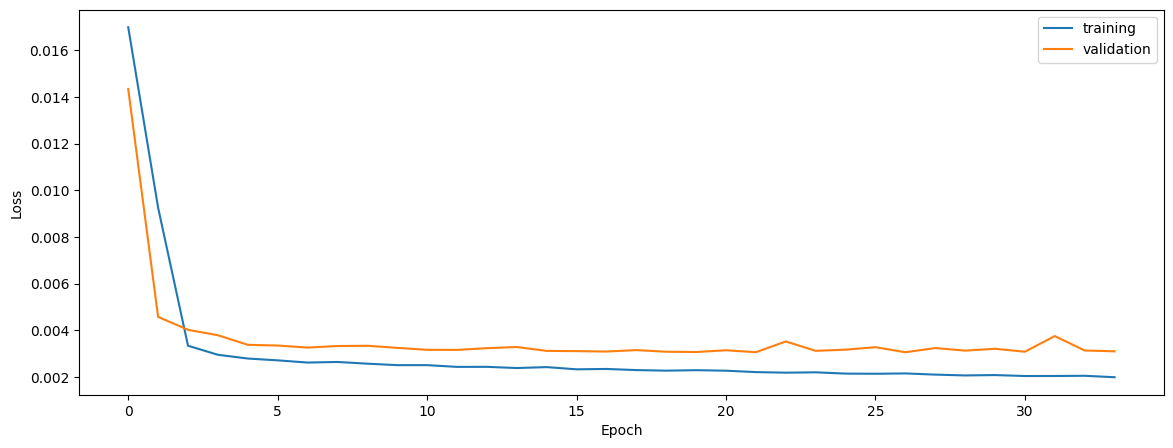

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.917225012985355
0.887853322203181
0.9072000310663126


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.917225012985355
0.887853322203181
0.9072000310663126


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.9231709822355595
0.8953281921241263
0.9224118060746045


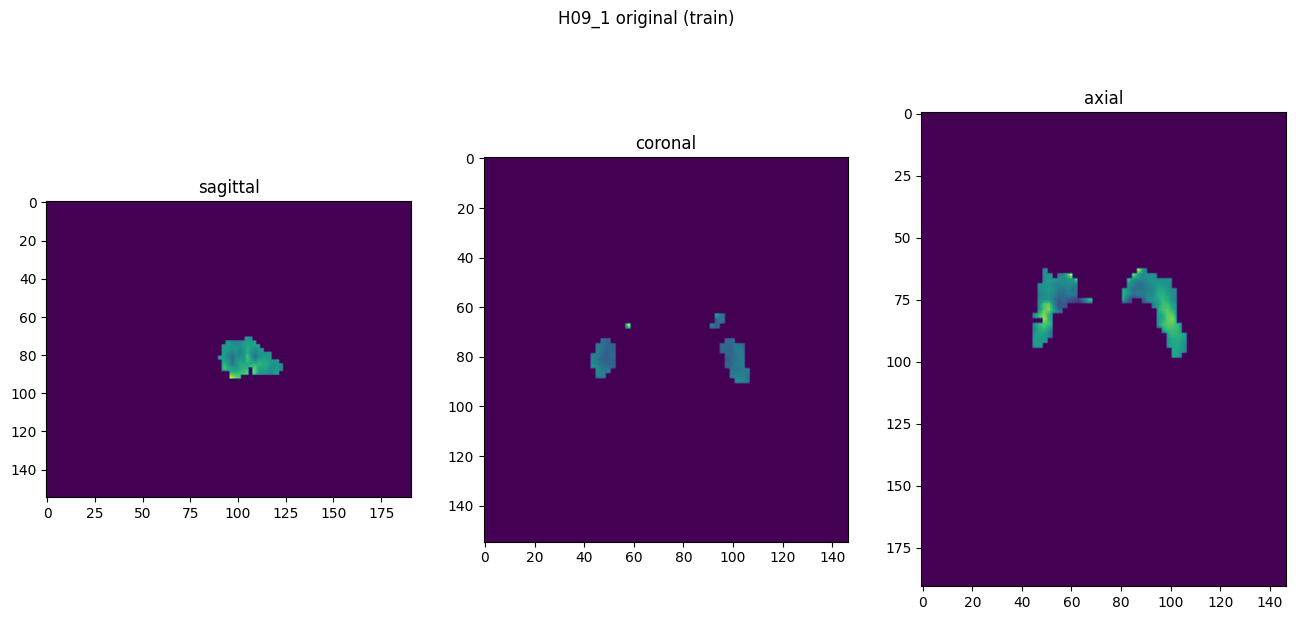

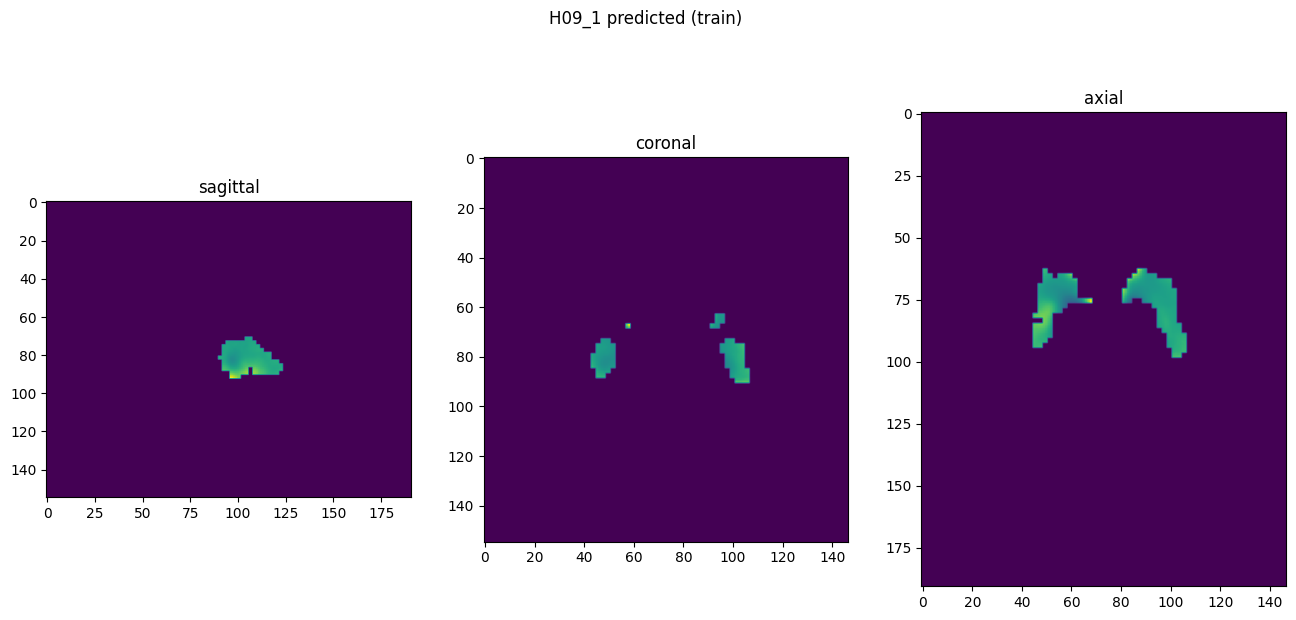

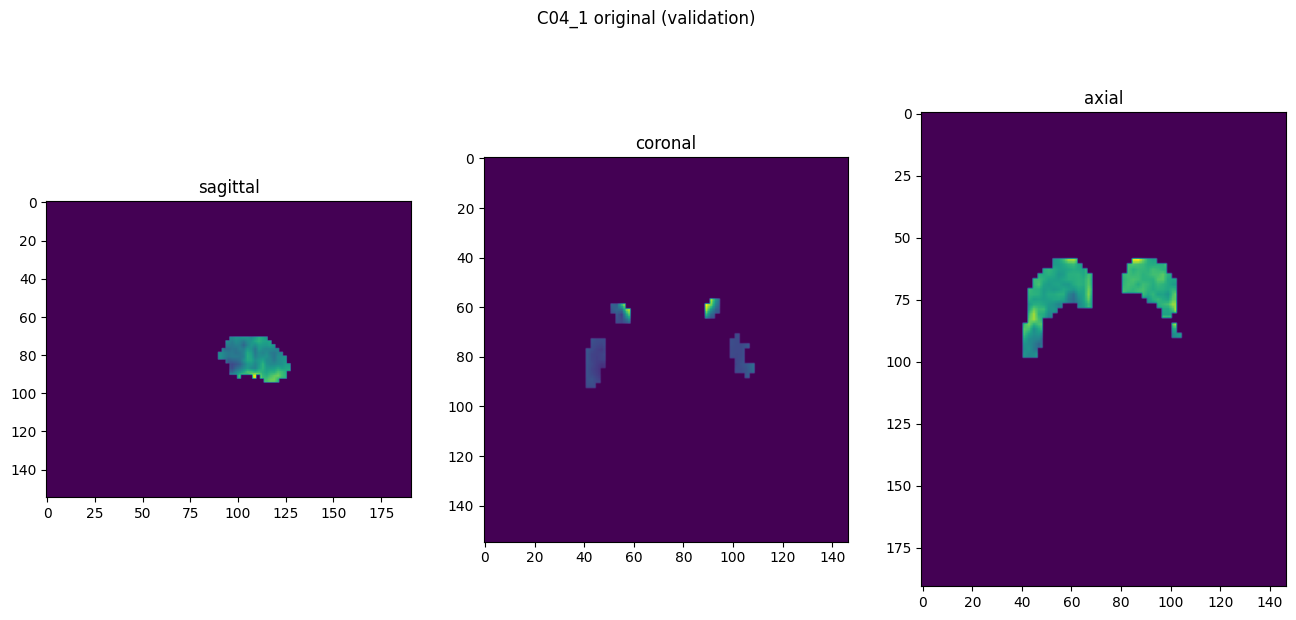

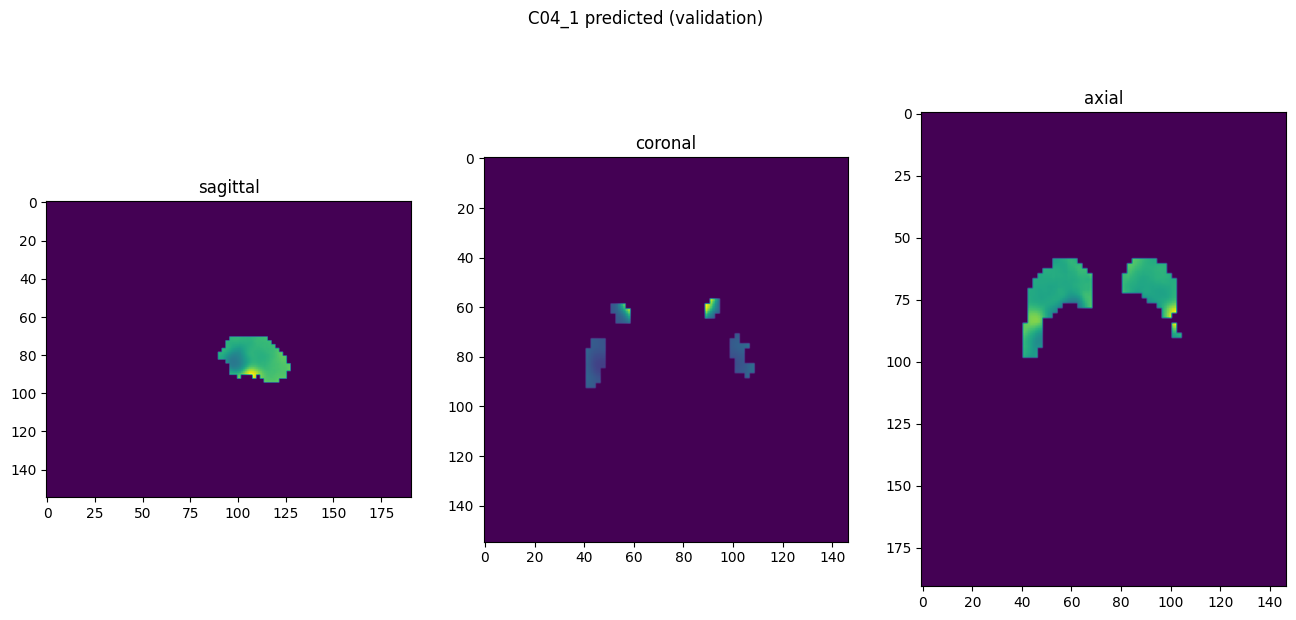

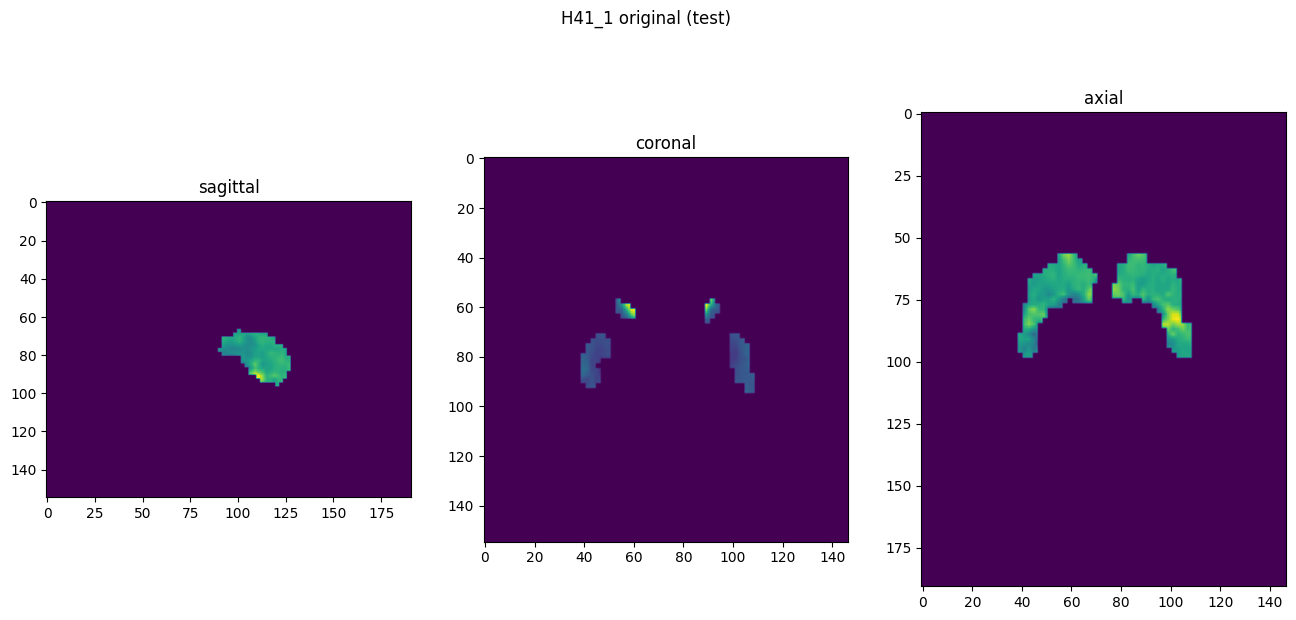

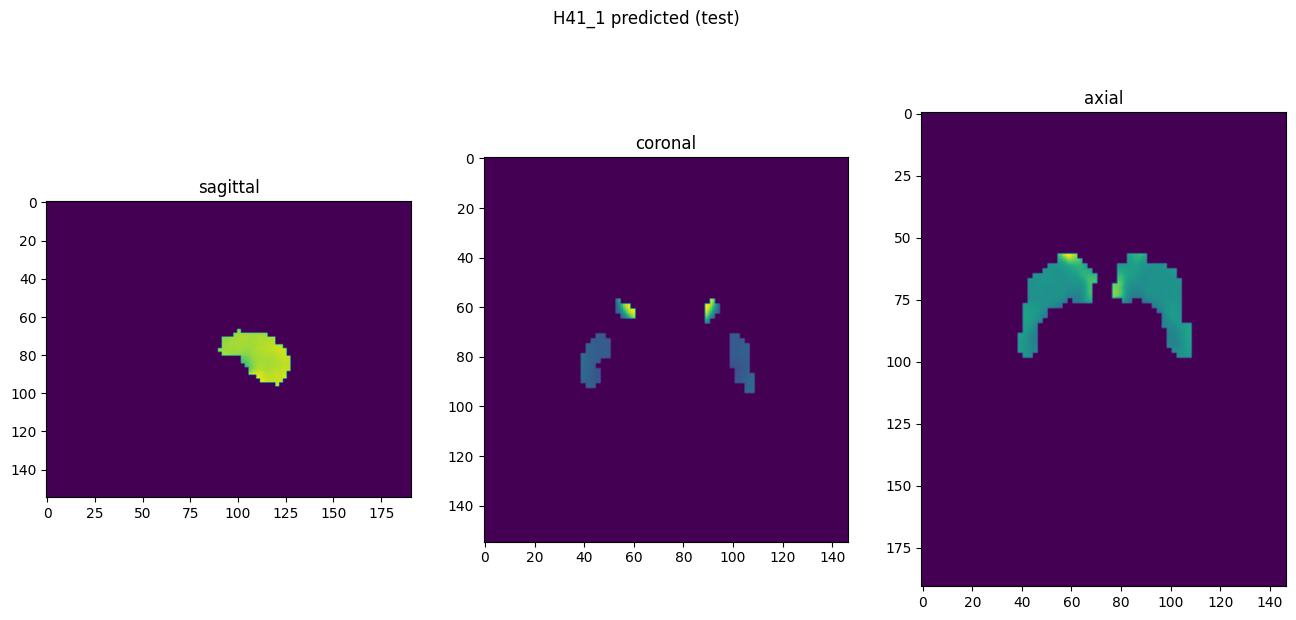

In [10]:
showResults(model, gen, threshold=None, background=False)